In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import uncertainties as unc
from uncertainties import unumpy

In [2]:
from src.plotting_tools.cms_format import cms_format_fig, cms_style
cms_style()
from src.data_tools.get_file_list import get_file_df
from src.data_tools.apply_cuts_v2 import  process_sample
from src.plotting_tools.SysHist import make_sys_hist, SysHist
from src.assets.lumi import lumi_dict
from src.assets.regions import region_and_label

/cvmfs/cms.cern.ch/slc7_amd64_gcc900/external/py3-scipy/1.7.1-c59502069094870046fda47cb5a5065e/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [3]:
def isKthBitSet(value, k):
    return bool(value & (1 << k))

In [4]:
# 0j: 0,1, 1b: 2,3,4, 1s: 5,6, 1b+1s: 7,8,9,10, 2b: 11,12,13,14
def is0b(value):
    return isKthBitSet(value, 0) or isKthBitSet(value, 1)

def is1b(value):
    return isKthBitSet(value, 2) or isKthBitSet(value, 3) or isKthBitSet(value, 4)

def is1s(value):
    return isKthBitSet(value, 5) or isKthBitSet(value, 6)

def is1b1s(value):
    return isKthBitSet(value, 7) or isKthBitSet(value, 8) or isKthBitSet(value, 9) or isKthBitSet(value, 10)

def is2b(value):
    return isKthBitSet(value, 11) or isKthBitSet(value, 12) or isKthBitSet(value, 13) or isKthBitSet(value, 14)

In [5]:
output_dir = '/eos/cms/store/group/phys_exotica/bffZprime/assets_may_23'
era='2018'

In [6]:
skimmed_df = get_file_df(path = "{}/data".format(output_dir))
skimmed_df = skimmed_df[skimmed_df.category=='BFF']

In [6]:
unskimmed_df = get_file_df(path = "{}/data_gen_b_s".format(output_dir))
unskimmed_df = unskimmed_df[unskimmed_df.category=='BFF']

In [22]:
def multiplicity(value):
    return np.log(value)/np.log(2)

In [31]:
file = unskimmed_df[(unskimmed_df.mass==200) &
            (unskimmed_df.era==2016) &
            (unskimmed_df.dbs==0.5)].iloc[0].file


df = pd.read_csv(file)


In [32]:
df['multiplicity'] = df.GenMultiplicity.apply(multiplicity)

In [33]:
// 0j: 0,1, 1b: 2,3,4, 1s: 5,6, 1b+1s: 7,8,9,10, 2b: 11,12,13,14, 2s: 15, 16, underlying: 17

SyntaxError: invalid syntax (2070941918.py, line 1)

In [34]:
def filter_hist():
    unique = multiplicity(df.GenMultiplicity.unique())
    return sorted({k: '{:.2f}'.format((df['multiplicity']==k).sum()/df.shape[0]) for k in unique}.items(), key=lambda x: x[0])
filter_hist()

/tmp/rymuelle/ipykernel_28881/689822871.py:2: RuntimeWarning: divide by zero encountered in log
  return np.log(value)/np.log(2)


[(-inf, '0.00'),
 (0.0, '0.56'),
 (2.0, '0.07'),
 (3.0, '0.04'),
 (4.0, '0.00'),
 (5.0, '0.02'),
 (6.0, '0.00'),
 (8.0, '0.00'),
 (10.0, '0.00'),
 (11.000704269011248, '0.00'),
 (12.0003521774803, '0.00'),
 (13.0, '0.00'),
 (14.0, '0.00'),
 (15.000044026886826, '0.00'),
 (15.169964136519175, '0.00'),
 (16.00002201361136, '0.00'),
 (17.000011006847668, '0.29')]

In [11]:
names = ['unlabled', '0b', '1b', '1s', '1b+1s', '2b']

In [10]:
def make_hist(df, draw=False, **kwargs):
    hist  = np.histogram(df.GenMultiplicity, bins=np.linspace(-1.5, 4.5, 7), **kwargs)
    if draw: fig = draw_bar(hist[0])
    else: fig = 0
    return {"fig": fig, "hist": hist[0]}

In [12]:
reg_hist = []
for i, row in skimmed_df.iterrows():
    print("-----")
    
    if not row["mass"] in [125, 150, 175, 200, 350]: continue
    era = row.era
    print(row)
    tudf = unskimmed_df[(unskimmed_df.mass==row.mass)&
                       (unskimmed_df.dbs==row.dbs) & 
                       (unskimmed_df.era==row.era)]
    if tudf.shape[0] != 1:continue
    urow = tudf.iloc[0]
    udf = pd.read_csv(urow.file)
    df = process_sample(row, era, verbose=True, trigger_fix=True)
    
    #make unskimmed histogram
    uhist = make_hist(udf)['hist']
    #normalization for unskimmed
    unskimmed_xsec = tudf.xsec
    lumi = lumi_dict[str(row.era)]
    nEvents = udf.shape[0]
    weight = float(unskimmed_xsec)*lumi/float(nEvents)
    uhist = uhist
    denom = unumpy.uarray(uhist, (uhist)**.5)*weight
    # this accounts for divide by 0 errors
    denom[denom==0] = -1
    
    for reg in ['SR1_jet_nom_muon_corrected_pt_ele_pt', 'SR2_jet_nom_muon_corrected_pt_ele_pt']:
        
        tdf = df[df[reg] == 1]
        rhist = make_hist(tdf)['hist']
        # calc efficencies
        nom = unumpy.uarray(rhist, (rhist)**.5)*tdf.Weight.mean()
        ratio  = nom/denom
        nom, std = unumpy.nominal_values(ratio), unumpy.std_devs(ratio)
        region_eff = {r:v for r,v in zip(names, ratio)}
        regstr = 'SR1' if 'SR1' in reg else 'SR2'
        reg_hist.append({"era": row.era, "mass": int(row.mass), "dbs": row.dbs,
                         "reg": regstr,
                         "uncut_hist": uhist, "region_hist": rhist, 
                         "weight":weight,   "tdf_weight":tdf.Weight.mean(),
                         "nom":nom, "std": std, **region_eff})


-----
type                                                         sig
category                                                     BFF
file           /eos/cms/store/group/phys_exotica/bffZprime/as...
mass                                                       125.0
dbs                                                         0.04
gmu                                                         0.17
gb                                                          0.02
era                                                         2016
xsec                                                      1528.0
sample_name                        BFFZprimeToMuMu_M_125_dbs0p04
Name: 0, dtype: object
BFFZprimeToMuMu_M_125_dbs0p04
	0.9408806653342789 remaining
-----
type                                                         sig
category                                                     BFF
file           /eos/cms/store/group/phys_exotica/bffZprime/as...
mass                                                       1

BFFZprimeToMuMu_M_200_dbs1p0
	0.9323101230109468 remaining
-----
-----
-----
type                                                         sig
category                                                     BFF
file           /eos/cms/store/group/phys_exotica/bffZprime/as...
mass                                                       350.0
dbs                                                         0.04
gmu                                                         0.17
gb                                                          0.02
era                                                         2016
xsec                                                       31.04
sample_name                        BFFZprimeToMuMu_M_350_dbs0p04
Name: 14, dtype: object
BFFZprimeToMuMu_M_350_dbs0p04
	0.8553766590573928 remaining
-----
type                                                         sig
category                                                     BFF
file           /eos/cms/store/group/phys_exotica/bffZ

-----
type                                                         sig
category                                                     BFF
file           /eos/cms/store/group/phys_exotica/bffZprime/as...
mass                                                       175.0
dbs                                                          1.0
gmu                                                         0.17
gb                                                          0.02
era                                                         2017
xsec                                                      2541.0
sample_name                         BFFZprimeToMuMu_M_175_dbs1p0
Name: 30, dtype: object
BFFZprimeToMuMu_M_175_dbs1p0
	0.887942277756742 remaining
-----
type                                                         sig
category                                                     BFF
file           /eos/cms/store/group/phys_exotica/bffZprime/as...
mass                                                       20

BFFZprimeToMuMu_M_125_dbs1p0
	0.9272518059195807 remaining
-----
type                                                         sig
category                                                     BFF
file           /eos/cms/store/group/phys_exotica/bffZprime/as...
mass                                                       150.0
dbs                                                         0.04
gmu                                                         0.17
gb                                                          0.02
era                                                         2018
xsec                                                       871.1
sample_name                        BFFZprimeToMuMu_M_150_dbs0p04
Name: 50, dtype: object
BFFZprimeToMuMu_M_150_dbs0p04
	0.9262467806134395 remaining
-----
type                                                         sig
category                                                     BFF
file           /eos/cms/store/group/phys_exotica/bffZprime/as...


-----
type                                                         sig
category                                                     BFF
file           /eos/cms/store/group/phys_exotica/bffZprime/as...
mass                                                       350.0
dbs                                                          1.0
gmu                                                         0.17
gb                                                          0.02
era                                                         2018
xsec                                                       178.0
sample_name                         BFFZprimeToMuMu_M_350_dbs1p0
Name: 63, dtype: object
BFFZprimeToMuMu_M_350_dbs1p0
	0.8289428196086566 remaining
-----
-----
-----
-----
-----
-----


In [13]:
df = pd.DataFrame(reg_hist)
df[['era', 'mass', 'dbs', 'reg', 'unlabled', '0b', '1b', '1s', '1b+1s', '2b']]

,era,mass,dbs,reg,unlabled,0b,1b,1s,1b+1s,2b
0,2016,125,0.04,SR1,-0.0+/-0,0.01936+/-0.00025,0.0600+/-0.0013,0.0+/-0,0.08+/-0.09,0.0144+/-0.0029
1,2016,125,0.04,SR2,-0.0+/-0,0.00262+/-0.00009,0.0284+/-0.0009,0.017+/-0.017,0.08+/-0.09,0.057+/-0.006
2,2016,125,0.50,SR1,0.022+/-0.022,0.01517+/-0.00022,0.0607+/-0.0015,0.0035+/-0.0009,0.017+/-0.004,0.015+/-0.004
3,2016,125,0.50,SR2,0.022+/-0.022,0.00200+/-0.00008,0.0262+/-0.0010,0.0094+/-0.0014,0.034+/-0.006,0.052+/-0.008
4,2016,125,1.00,SR1,0.054+/-0.028,0.01261+/-0.00020,0.0619+/-0.0017,0.0026+/-0.0006,0.0180+/-0.0034,0.021+/-0.007
...,...,...,...,...,...,...,...,...,...,...
89,2018,350,0.04,SR2,0.32+/-0.26,0.01833+/-0.00022,0.0974+/-0.0010,0.056+/-0.018,0.049+/-0.029,0.131+/-0.005
90,2018,350,0.50,SR1,0.047+/-0.018,0.0703+/-0.0005,0.2161+/-0.0019,0.0084+/-0.0009,0.066+/-0.005,0.038+/-0.004
91,2018,350,0.50,SR2,0.122+/-0.031,0.01343+/-0.00019,0.0939+/-0.0012,0.0343+/-0.0018,0.105+/-0.007,0.149+/-0.008
92,2018,350,1.00,SR1,0.062+/-0.016,0.0585+/-0.0004,0.2213+/-0.0020,0.0114+/-0.0008,0.061+/-0.004,0.036+/-0.005


In [14]:
df.to_csv(output_dir+"/data_gen_b_s/efficency_df.csv")

In [15]:
df = pd.read_csv(output_dir+"/data_gen_b_s/efficency_df.csv")
df['0b'] = df['0b'].apply(unc.ufloat_fromstr)
df['1b'] = df['1b'].apply(unc.ufloat_fromstr)
df['1s'] = df['1s'].apply(unc.ufloat_fromstr)
df['1b+1s'] = df['1b+1s'].apply(unc.ufloat_fromstr)
df['2b'] = df['2b'].apply(unc.ufloat_fromstr)

In [16]:
def print_table(tdf):
    print(tdf[['era', 'mass', 'dbs', 'reg', 'unlabled', '0b', '1b', '1s', '1b+1s', '2b']].to_latex(index=False))


In [17]:
def average_df(**kwargs):
    df_filter = []
    for k,v in kwargs.items():
        if len(df_filter) == 0 : df_filter = (df[k] == v)
        else: df_filter = df_filter & (df[k] == v)   
    
    tdf = df[df_filter]
    
    multiplicities = tdf[['0b', '1b', '1s', '1b+1s', '2b']]
    average = multiplicities.sum()/tdf.shape[0]*100
    return {**kwargs, **average.to_dict()}

In [18]:
def get_nom_values(series):
    nom, err = series.apply(unumpy.nominal_values), series.apply(unumpy.std_devs)
    return nom.to_numpy(), err.to_numpy()

In [19]:
def plot_series(ax, key):
    mass = tdf['mass']
    nom, err = get_nom_values(tdf[key])
    plt.errorbar(mass, nom, yerr=err, label=key)

In [34]:
'{}/gen_b_s/SR2_acceptance.pdf'.format(output_dir)

'/eos/cms/store/group/phys_exotica/bffZprime/assets_may_23/gen_b_s/SR2_acceptance.pdf'

In [32]:
!ls /eos/cms/store/group/phys_exotica/bffZprime/assets_feb_23/

data  data_gen_b_s


\begin{tabular}{rllllll}
\toprule
 mass & reg &              0b &          1b &          1s &     1b+1s &           2b \\
\midrule
  125 & SR2 & 0.1920+/-0.0027 & 2.89+/-0.04 & 0.81+/-0.26 & 5.4+/-2.6 &    9.2+/-0.5 \\
  150 & SR2 &   0.444+/-0.004 & 4.24+/-0.04 & 1.67+/-0.28 & 5.3+/-1.2 &  8.23+/-0.33 \\
  175 & SR2 &   0.691+/-0.005 & 5.96+/-0.04 & 1.89+/-0.28 & 8.2+/-1.7 &   10.9+/-0.4 \\
  200 & SR2 &   0.868+/-0.005 & 7.17+/-0.04 & 2.88+/-0.32 & 8.3+/-1.0 & 12.05+/-0.30 \\
  350 & SR2 &   1.431+/-0.007 & 9.30+/-0.04 & 3.53+/-0.28 & 9.6+/-0.7 & 15.11+/-0.27 \\
\bottomrule
\end{tabular}



,mass,reg,0b,1b,1s,1b+1s,2b
0,125,SR2,0.1920+/-0.0027,2.89+/-0.04,0.81+/-0.26,5.4+/-2.6,9.2+/-0.5
1,150,SR2,0.444+/-0.004,4.24+/-0.04,1.67+/-0.28,5.3+/-1.2,8.23+/-0.33
2,175,SR2,0.691+/-0.005,5.96+/-0.04,1.89+/-0.28,8.2+/-1.7,10.9+/-0.4
3,200,SR2,0.868+/-0.005,7.17+/-0.04,2.88+/-0.32,8.3+/-1.0,12.05+/-0.30
4,350,SR2,1.431+/-0.007,9.30+/-0.04,3.53+/-0.28,9.6+/-0.7,15.11+/-0.27


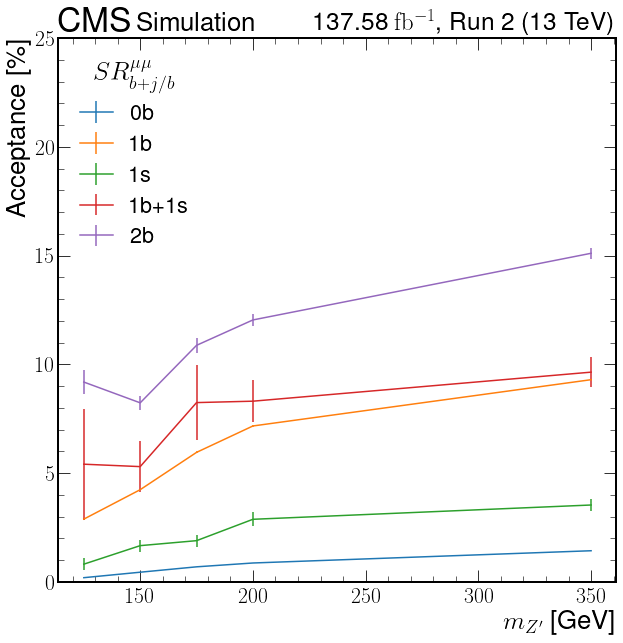

In [35]:
dbs_test = []
for mass in df.mass.unique():
    dbs_test.append(average_df(mass=mass, reg='SR2'))
    
tdf = pd.DataFrame(dbs_test)

fig, ax = plt.subplots(figsize=[10,10])
plot_series(ax, '0b')
plot_series(ax, '1b')
plot_series(ax, '1s')
plot_series(ax, '1b+1s')
plot_series(ax, '2b')
ax.legend(title='${}$'.format(region_and_label['SR2']))
ax.set_ylim(0,25)
cms_format_fig('Run 2', ax)
ax.set_ylabel('Acceptance [\%]')
ax.set_xlabel('$m_{Z^{\prime}}$ [GeV]')


fig.savefig('{}/gen_b_s/SR2_acceptance.pdf'.format(output_dir))
print(tdf.to_latex(index=False))

tdf

\begin{tabular}{rllllll}
\toprule
 mass & reg &            0b &           1b &            1s &       1b+1s &          2b \\
\midrule
  125 & SR1 & 1.577+/-0.008 &  7.11+/-0.06 & 0.123+/-0.015 &   1.6+/-1.0 & 3.29+/-0.31 \\
  150 & SR1 & 3.755+/-0.012 & 10.60+/-0.06 & 0.389+/-0.025 & 2.11+/-0.12 & 2.66+/-0.18 \\
  175 & SR1 & 5.239+/-0.015 & 15.30+/-0.07 &     1.4+/-0.4 & 2.82+/-0.13 & 3.64+/-0.20 \\
  200 & SR1 & 6.154+/-0.013 & 18.37+/-0.06 &   1.08+/-0.21 &   4.3+/-0.7 & 4.21+/-0.16 \\
  350 & SR1 & 7.498+/-0.015 & 20.79+/-0.06 &   0.94+/-0.11 &   5.5+/-0.5 & 4.86+/-0.14 \\
\bottomrule
\end{tabular}



,mass,reg,0b,1b,1s,1b+1s,2b
0,125,SR1,1.577+/-0.008,7.11+/-0.06,0.123+/-0.015,1.6+/-1.0,3.29+/-0.31
1,150,SR1,3.755+/-0.012,10.60+/-0.06,0.389+/-0.025,2.11+/-0.12,2.66+/-0.18
2,175,SR1,5.239+/-0.015,15.30+/-0.07,1.4+/-0.4,2.82+/-0.13,3.64+/-0.20
3,200,SR1,6.154+/-0.013,18.37+/-0.06,1.08+/-0.21,4.3+/-0.7,4.21+/-0.16
4,350,SR1,7.498+/-0.015,20.79+/-0.06,0.94+/-0.11,5.5+/-0.5,4.86+/-0.14


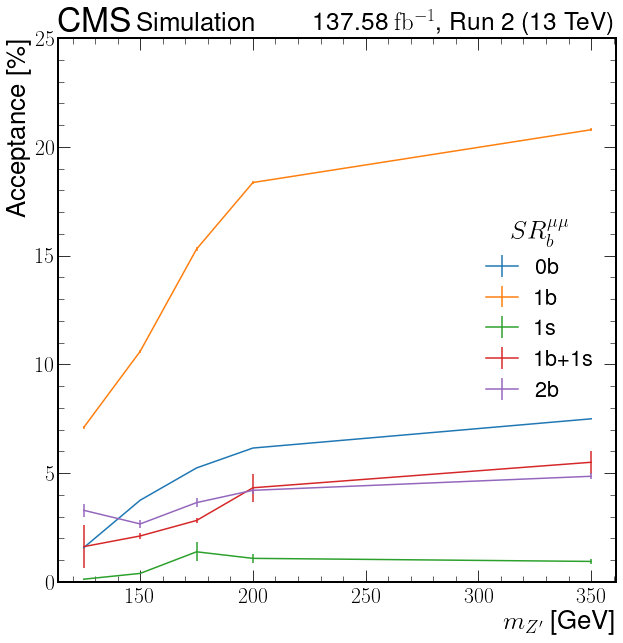

In [36]:
dbs_test = []
for mass in df.mass.unique():
    dbs_test.append(average_df(mass=mass, reg='SR1'))
    
tdf = pd.DataFrame(dbs_test)

fig, ax = plt.subplots(figsize=[10,10])
plot_series(ax, '0b')
plot_series(ax, '1b')
plot_series(ax, '1s')
plot_series(ax, '1b+1s')
plot_series(ax, '2b')
ax.legend(title='${}$'.format(region_and_label['SR1']))
cms_format_fig('Run 2', ax)
ax.set_ylim(0,25)
ax.set_ylabel('Acceptance [\%]')
ax.set_xlabel('$m_{Z^{\prime}}$ [GeV]')
fig.savefig('{}/gen_b_s/SR1_acceptance.pdf'.format(output_dir))

print(tdf.to_latex(index=False))

tdf

In [46]:
def draw_bar(values, log = False, **kwargs):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(['0b', '1b', '1s', '1b+1s', '2b'], values, **kwargs)
    ax.set_ylim([0,.5])
    if log: plt.yscale('log')    
    return fig, ax

In [12]:
def comparison_bar(uncut, region, reg):
    # The data
    indices = range(len(nom))
    names = ["", '0b', '1b', '1s', '1b+1s', '2b']
    # Calculate optimal width
    width = np.min(np.diff(indices))/3.
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(indices-width/2.,uncut/np.sum(uncut),width,color='b',label='pre-cuts')
    ax.bar(indices+width/2.,region/np.sum(uncut),width,color='r',label='{}'.format(reg))
    #tiks = ax.get_xticks().tolist()
    ax.axes.set_xticklabels(names)
    #plt.yscale("log")
    return fig, ax


/tmp/rymuelle/ipykernel_15867/1905170658.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.axes.set_xticklabels(names)


--------
125 GeV $\delta_{bs}=0.04$ SR1_jet_nom_muon_corrected_pt_ele_pt 2016
0b & 1.71 & 88.57 & 1.93 & 0.06 \\
1b & 0.65 & 10.91 & 5.98 & 0.32 \\
1s & 0.00 & 0.02 & 0.00 & 0.00 \\
1b+1s & 0.00 & 0.00 & 8.14 & 21.12 \\
2b & 0.01 & 0.50 & 1.44 & 0.72 \\
--------
125 GeV $\delta_{bs}=0.04$ SR2_jet_nom_muon_corrected_pt_ele_pt 2016
0b & 0.23 & 88.57 & 0.26 & 0.02 \\
1b & 0.30 & 10.91 & 2.78 & 0.22 \\
1s & 0.00 & 0.02 & 1.66 & 4.17 \\
1b+1s & 0.00 & 0.00 & 8.14 & 21.12 \\
2b & 0.03 & 0.50 & 5.58 & 1.45 \\


--------
125 GeV $\delta_{bs}=0.5$ SR1_jet_nom_muon_corrected_pt_ele_pt 2016
0b & 1.36 & 89.89 & 1.51 & 0.04 \\
1b & 0.50 & 8.30 & 6.03 & 0.26 \\
1s & 0.00 & 1.31 & 0.34 & 0.15 \\
1b+1s & 0.00 & 0.26 & 1.72 & 0.77 \\
2b & 0.00 & 0.24 & 1.51 & 0.75 \\
--------
125 GeV $\delta_{bs}=0.5$ SR2_jet_nom_muon_corrected_pt_ele_pt 2016
0b & 0.18 & 89.89 & 0.20 & 0.01 \\
1b & 0.21 & 8.30 & 2.57 & 0.17 \\
1s & 0.01 & 1.31 & 0.93 & 0.25 \\
1b+1s & 0.01 & 0.26 & 3.33 & 1.08 \\
2b & 0.01 & 0.24 & 5.09 & 1.39 \\


--------
125 GeV $\delta_{bs}=1.0$ SR1_jet_nom_muon_corrected_pt_ele_pt 2016
0b & 1.14 & 90.69 & 1.25 & 0.02 \\
1b & 0.41 & 6.68 & 6.14 & 0.18 \\
1s & 0.01 & 2.08 & 0.25 & 0.07 \\
1b+1s & 0.01 & 0.44 & 1.78 & 0.38 \\
2b & 0.00 & 0.11 & 2.05 & 0.82 \\
--------
125 GeV $\delta_{bs}=1.0$ SR2_jet_nom_muon_corrected_pt_ele_pt 2016
0b & 0.13 & 90.69 & 0.15 & 0.01 \\
1b & 0.17 & 6.68 & 2.50 & 0.12 \\
1s & 0.02 & 2.08 & 1.19 & 0.14 \\
1b+1s & 0.02 & 0.44 & 3.69 & 0.55 \\
2b & 0.01 & 0.11 & 4.88 & 1.29 \\


--------
200 GeV $\delta_{bs}=0.04$ SR1_jet_nom_muon_corrected_pt_ele_pt 2016
0b & 6.66 & 82.81 & 8.04 & 0.32 \\
1b & 2.83 & 16.21 & 17.45 & 1.10 \\
1s & 0.00 & 0.02 & 1.79 & 8.60 \\
1b+1s & 0.00 & 0.01 & 0.00 & 0.00 \\
2b & 0.04 & 0.95 & 4.24 & 2.10 \\
--------
200 GeV $\delta_{bs}=0.04$ SR2_jet_nom_muon_corrected_pt_ele_pt 2016
0b & 1.05 & 82.81 & 1.27 & 0.12 \\
1b & 1.29 & 16.21 & 7.97 & 0.71 \\
1s & 0.00 & 0.02 & 3.58 & 12.27 \\
1b+1s & 0.00 & 0.01 & 12.62 & 45.05 \\
2b & 0.12 & 0.95 & 12.38 & 3.73 \\


/tmp/rymuelle/ipykernel_15867/2161471297.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


--------
200 GeV $\delta_{bs}=0.5$ SR1_jet_nom_muon_corrected_pt_ele_pt 2016
0b & 5.24 & 85.00 & 6.16 & 0.19 \\
1b & 2.18 & 12.13 & 17.99 & 0.90 \\
1s & 0.03 & 1.94 & 1.37 & 0.58 \\
1b+1s & 0.02 & 0.49 & 4.25 & 2.05 \\
2b & 0.02 & 0.45 & 5.09 & 2.36 \\
--------
200 GeV $\delta_{bs}=0.5$ SR2_jet_nom_muon_corrected_pt_ele_pt 2016
0b & 0.81 & 85.00 & 0.95 & 0.07 \\
1b & 0.92 & 12.13 & 7.58 & 0.56 \\
1s & 0.06 & 1.94 & 3.17 & 0.89 \\
1b+1s & 0.04 & 0.49 & 8.71 & 3.00 \\
2b & 0.06 & 0.45 & 14.42 & 4.14 \\


--------
200 GeV $\delta_{bs}=1.0$ SR1_jet_nom_muon_corrected_pt_ele_pt 2016
0b & 4.51 & 85.97 & 5.24 & 0.11 \\
1b & 1.83 & 9.99 & 18.28 & 0.63 \\
1s & 0.03 & 3.12 & 0.99 & 0.24 \\
1b+1s & 0.03 & 0.74 & 4.36 & 1.07 \\
2b & 0.01 & 0.18 & 3.43 & 1.93 \\


--------
200 GeV $\delta_{bs}=1.0$ SR2_jet_nom_muon_corrected_pt_ele_pt 2016
0b & 0.65 & 85.97 & 0.76 & 0.04 \\
1b & 0.71 & 9.99 & 7.06 & 0.37 \\
1s & 0.10 & 3.12 & 3.18 & 0.44 \\
1b+1s & 0.07 & 0.74 & 9.02 & 1.57 \\
2b & 0.02 & 0.18 & 12.54 & 3.86 \\
--------
350 GeV $\delta_{bs}=0.04$ SR1_jet_nom_muon_corrected_pt_ele_pt 2016
0b & 7.48 & 75.48 & 9.90 & 1.13 \\
1b & 4.46 & 22.59 & 19.73 & 3.05 \\
1s & 0.00 & 0.04 & 0.51 & 10.71 \\
1b+1s & 0.00 & 0.01 & 4.48 & 55.27 \\
2b & 0.10 & 1.87 & 5.35 & 5.17 \\
--------
350 GeV $\delta_{bs}=0.04$ SR2_jet_nom_muon_corrected_pt_ele_pt 2016
0b & 1.53 & 75.48 & 2.03 & 0.49 \\
1b & 2.34 & 22.59 & 10.34 & 2.12 \\
1s & 0.00 & 0.04 & 4.60 & 32.78 \\
1b+1s & 0.00 & 0.01 & 10.45 & 86.80 \\
2b & 0.30 & 1.87 & 16.28 & 9.48 \\


--------
350 GeV $\delta_{bs}=0.5$ SR1_jet_nom_muon_corrected_pt_ele_pt 2016
0b & 5.98 & 78.69 & 7.60 & 0.66 \\
1b & 3.42 & 16.94 & 20.21 & 2.46 \\
1s & 0.03 & 2.68 & 1.11 & 1.33 \\
1b+1s & 0.05 & 0.81 & 5.62 & 5.57 \\
2b & 0.05 & 0.88 & 5.48 & 5.26 \\
--------
350 GeV $\delta_{bs}=0.5$ SR2_jet_nom_muon_corrected_pt_ele_pt 2016
0b & 1.18 & 78.69 & 1.50 & 0.29 \\
1b & 1.66 & 16.94 & 9.81 & 1.64 \\
1s & 0.10 & 2.68 & 3.69 & 2.45 \\
1b+1s & 0.09 & 0.81 & 11.09 & 8.02 \\
2b & 0.15 & 0.88 & 16.82 & 9.69 \\


--------
350 GeV $\delta_{bs}=1.0$ SR1_jet_nom_muon_corrected_pt_ele_pt 2016
0b & 5.07 & 80.21 & 6.32 & 0.37 \\
1b & 2.89 & 14.12 & 20.47 & 1.70 \\
1s & 0.05 & 4.15 & 1.27 & 0.72 \\
1b+1s & 0.07 & 1.19 & 6.07 & 3.00 \\
2b & 0.02 & 0.33 & 5.03 & 5.16 \\
--------
350 GeV $\delta_{bs}=1.0$ SR2_jet_nom_muon_corrected_pt_ele_pt 2016
0b & 0.99 & 80.21 & 1.23 & 0.16 \\
1b & 1.30 & 14.12 & 9.17 & 1.09 \\
1s & 0.16 & 4.15 & 3.94 & 1.28 \\
1b+1s & 0.13 & 1.19 & 11.30 & 4.19 \\
2b & 0.06 & 0.33 & 16.74 & 9.91 \\


--------
125 GeV $\delta_{bs}=0.04$ SR1_jet_nom_muon_corrected_pt_ele_pt 2017
0b & 1.47 & 89.09 & 1.64 & 0.05 \\
1b & 0.65 & 10.44 & 6.23 & 0.31 \\
1s & 0.00 & 0.02 & 0.00 & 0.00 \\
1b+1s & 0.00 & 0.00 & 0.00 & 0.00 \\
2b & 0.01 & 0.45 & 1.53 & 0.73 \\
--------
125 GeV $\delta_{bs}=0.04$ SR2_jet_nom_muon_corrected_pt_ele_pt 2017
0b & 0.17 & 89.09 & 0.19 & 0.02 \\
1b & 0.25 & 10.44 & 2.40 & 0.19 \\
1s & 0.00 & 0.02 & 0.00 & 0.00 \\
1b+1s & 0.00 & 0.00 & 18.52 & 35.53 \\
2b & 0.02 & 0.45 & 4.70 & 1.29 \\


--------
125 GeV $\delta_{bs}=0.5$ SR1_jet_nom_muon_corrected_pt_ele_pt 2017
0b & 1.18 & 90.15 & 1.31 & 0.03 \\
1b & 0.48 & 8.10 & 5.90 & 0.24 \\
1s & 0.00 & 1.22 & 0.20 & 0.11 \\
1b+1s & 0.01 & 0.26 & 1.97 & 0.76 \\
2b & 0.00 & 0.27 & 1.75 & 0.71 \\
--------
125 GeV $\delta_{bs}=0.5$ SR2_jet_nom_muon_corrected_pt_ele_pt 2017
0b & 0.13 & 90.15 & 0.15 & 0.01 \\
1b & 0.18 & 8.10 & 2.17 & 0.14 \\
1s & 0.01 & 1.22 & 0.89 & 0.24 \\
1b+1s & 0.01 & 0.26 & 3.81 & 1.06 \\
2b & 0.01 & 0.27 & 4.35 & 1.13 \\


--------
125 GeV $\delta_{bs}=1.0$ SR1_jet_nom_muon_corrected_pt_ele_pt 2017
0b & 1.47 & 90.99 & 1.61 & 0.02 \\
1b & 0.65 & 6.52 & 9.97 & 0.22 \\
1s & 0.00 & 1.99 & 0.00 & 0.00 \\
1b+1s & 0.00 & 0.39 & 0.00 & 0.00 \\
2b & 0.01 & 0.11 & 6.02 & 1.30 \\
--------
125 GeV $\delta_{bs}=1.0$ SR2_jet_nom_muon_corrected_pt_ele_pt 2017
0b & 0.17 & 90.99 & 0.19 & 0.01 \\
1b & 0.25 & 6.52 & 3.85 & 0.14 \\
1s & 0.00 & 1.99 & 0.00 & 0.00 \\
1b+1s & 0.00 & 0.39 & 0.13 & 0.10 \\
2b & 0.02 & 0.11 & 18.49 & 2.40 \\


--------
200 GeV $\delta_{bs}=0.04$ SR1_jet_nom_muon_corrected_pt_ele_pt 2017
0b & 5.83 & 83.60 & 6.97 & 0.27 \\
1b & 2.78 & 15.56 & 17.87 & 1.04 \\
1s & 0.00 & 0.02 & 0.00 & 0.00 \\
1b+1s & 0.00 & 0.01 & 1.73 & 11.55 \\
2b & 0.04 & 0.81 & 4.71 & 2.20 \\
--------
200 GeV $\delta_{bs}=0.04$ SR2_jet_nom_muon_corrected_pt_ele_pt 2017
0b & 0.80 & 83.60 & 0.96 & 0.10 \\
1b & 1.12 & 15.56 & 7.22 & 0.63 \\
1s & 0.00 & 0.02 & 2.48 & 9.59 \\
1b+1s & 0.00 & 0.01 & 3.46 & 16.48 \\
2b & 0.10 & 0.81 & 11.88 & 3.62 \\


--------
200 GeV $\delta_{bs}=0.04$ SR1_jet_nom_muon_corrected_pt_ele_pt 2017
0b & 5.89 & 83.60 & 7.04 & 0.27 \\
1b & 2.73 & 15.56 & 17.56 & 1.03 \\
1s & 0.00 & 0.02 & 3.07 & 10.69 \\
1b+1s & 0.00 & 0.01 & 4.28 & 18.39 \\
2b & 0.03 & 0.81 & 3.65 & 1.93 \\
--------
200 GeV $\delta_{bs}=0.04$ SR2_jet_nom_muon_corrected_pt_ele_pt 2017
0b & 0.83 & 83.60 & 1.00 & 0.10 \\
1b & 1.08 & 15.56 & 6.97 & 0.62 \\
1s & 0.00 & 0.02 & 1.02 & 6.11 \\
1b+1s & 0.00 & 0.01 & 6.42 & 22.75 \\
2b & 0.09 & 0.81 & 11.03 & 3.47 \\


--------
200 GeV $\delta_{bs}=0.5$ SR1_jet_nom_muon_corrected_pt_ele_pt 2017
0b & 4.63 & 85.15 & 5.43 & 0.16 \\
1b & 2.14 & 12.01 & 17.80 & 0.82 \\
1s & 0.02 & 1.94 & 0.91 & 0.43 \\
1b+1s & 0.02 & 0.41 & 4.34 & 2.06 \\
2b & 0.02 & 0.49 & 4.40 & 1.90 \\
--------
200 GeV $\delta_{bs}=0.5$ SR2_jet_nom_muon_corrected_pt_ele_pt 2017
0b & 0.61 & 85.15 & 0.71 & 0.06 \\
1b & 0.79 & 12.01 & 6.58 & 0.47 \\
1s & 0.06 & 1.94 & 2.90 & 0.77 \\
1b+1s & 0.04 & 0.41 & 8.69 & 2.97 \\
2b & 0.06 & 0.49 & 11.47 & 3.17 \\


--------
200 GeV $\delta_{bs}=0.5$ SR1_jet_nom_muon_corrected_pt_ele_pt 2017
0b & 4.55 & 85.15 & 5.34 & 0.16 \\
1b & 2.15 & 12.01 & 17.91 & 0.82 \\
1s & 0.02 & 1.94 & 0.97 & 0.44 \\
1b+1s & 0.02 & 0.41 & 4.80 & 2.17 \\
2b & 0.02 & 0.49 & 4.05 & 1.82 \\
--------
200 GeV $\delta_{bs}=0.5$ SR2_jet_nom_muon_corrected_pt_ele_pt 2017
0b & 0.59 & 85.15 & 0.69 & 0.06 \\
1b & 0.79 & 12.01 & 6.55 & 0.47 \\
1s & 0.05 & 1.94 & 2.42 & 0.70 \\
1b+1s & 0.03 & 0.41 & 8.07 & 2.85 \\
2b & 0.06 & 0.49 & 11.71 & 3.21 \\


--------
200 GeV $\delta_{bs}=1.0$ SR1_jet_nom_muon_corrected_pt_ele_pt 2017
0b & 3.94 & 86.31 & 4.56 & 0.09 \\
1b & 1.76 & 9.82 & 17.97 & 0.58 \\
1s & 0.02 & 2.99 & 0.81 & 0.20 \\
1b+1s & 0.03 & 0.68 & 4.98 & 1.09 \\
2b & 0.01 & 0.21 & 4.35 & 1.84 \\
--------
200 GeV $\delta_{bs}=1.0$ SR2_jet_nom_muon_corrected_pt_ele_pt 2017
0b & 0.49 & 86.31 & 0.56 & 0.03 \\
1b & 0.59 & 9.82 & 6.04 & 0.32 \\
1s & 0.07 & 2.99 & 2.36 & 0.35 \\
1b+1s & 0.06 & 0.68 & 8.23 & 1.42 \\
2b & 0.02 & 0.21 & 11.55 & 3.10 \\


--------
350 GeV $\delta_{bs}=0.04$ SR1_jet_nom_muon_corrected_pt_ele_pt 2017
0b & 6.52 & 75.86 & 8.60 & 0.94 \\
1b & 4.31 & 22.31 & 19.31 & 2.72 \\
1s & 0.00 & 0.04 & 0.50 & 10.13 \\
1b+1s & 0.00 & 0.01 & 5.63 & 58.20 \\
2b & 0.08 & 1.78 & 4.60 & 4.39 \\
--------
350 GeV $\delta_{bs}=0.04$ SR2_jet_nom_muon_corrected_pt_ele_pt 2017
0b & 1.22 & 75.86 & 1.61 & 0.39 \\
1b & 2.01 & 22.31 & 9.02 & 1.78 \\
1s & 0.00 & 0.04 & 0.50 & 10.13 \\
1b+1s & 0.00 & 0.01 & 7.04 & 65.50 \\
2b & 0.24 & 1.78 & 13.67 & 7.90 \\


--------
350 GeV $\delta_{bs}=0.5$ SR1_jet_nom_muon_corrected_pt_ele_pt 2017
0b & 5.10 & 78.91 & 6.47 & 0.54 \\
1b & 3.27 & 16.90 & 19.37 & 2.16 \\
1s & 0.03 & 2.63 & 0.99 & 1.14 \\
1b+1s & 0.04 & 0.72 & 5.34 & 5.15 \\
2b & 0.04 & 0.84 & 5.20 & 4.70 \\
--------
350 GeV $\delta_{bs}=0.5$ SR2_jet_nom_muon_corrected_pt_ele_pt 2017
0b & 0.90 & 78.91 & 1.14 & 0.22 \\
1b & 1.40 & 16.90 & 8.25 & 1.34 \\
1s & 0.08 & 2.63 & 3.04 & 2.01 \\
1b+1s & 0.07 & 0.72 & 9.80 & 7.13 \\
2b & 0.12 & 0.84 & 14.01 & 8.03 \\


--------
350 GeV $\delta_{bs}=1.0$ SR1_jet_nom_muon_corrected_pt_ele_pt 2017
0b & 4.43 & 80.65 & 5.49 & 0.31 \\
1b & 2.75 & 13.82 & 19.88 & 1.52 \\
1s & 0.04 & 4.03 & 1.01 & 0.58 \\
1b+1s & 0.07 & 1.16 & 5.72 & 2.64 \\
2b & 0.02 & 0.32 & 5.45 & 4.86 \\
--------
350 GeV $\delta_{bs}=1.0$ SR2_jet_nom_muon_corrected_pt_ele_pt 2017
0b & 0.77 & 80.65 & 0.95 & 0.13 \\
1b & 1.10 & 13.82 & 7.99 & 0.91 \\
1s & 0.12 & 4.03 & 2.95 & 1.00 \\
1b+1s & 0.11 & 1.16 & 9.42 & 3.44 \\
2b & 0.05 & 0.32 & 14.06 & 8.12 \\


--------
125 GeV $\delta_{bs}=0.04$ SR1_jet_nom_muon_corrected_pt_ele_pt 2018
0b & 1.56 & 89.11 & 1.75 & 0.05 \\
1b & 0.66 & 10.36 & 6.38 & 0.26 \\
1s & 0.00 & 0.02 & 0.00 & 0.00 \\
1b+1s & 0.00 & 0.00 & 0.00 & 0.00 \\
2b & 0.01 & 0.51 & 2.06 & 0.65 \\


--------
125 GeV $\delta_{bs}=0.04$ SR2_jet_nom_muon_corrected_pt_ele_pt 2018
0b & 0.19 & 89.11 & 0.22 & 0.02 \\
1b & 0.28 & 10.36 & 2.66 & 0.17 \\
1s & 0.00 & 0.02 & 1.60 & 3.20 \\
1b+1s & 0.00 & 0.00 & 6.87 & 14.06 \\
2b & 0.03 & 0.51 & 5.25 & 1.06 \\
--------
125 GeV $\delta_{bs}=0.5$ SR1_jet_nom_muon_corrected_pt_ele_pt 2018
0b & 1.20 & 90.23 & 1.33 & 0.03 \\
1b & 0.50 & 8.03 & 6.23 & 0.21 \\
1s & 0.00 & 1.25 & 0.30 & 0.11 \\
1b+1s & 0.00 & 0.25 & 1.08 & 0.48 \\
2b & 0.00 & 0.25 & 1.67 & 0.60 \\


--------
125 GeV $\delta_{bs}=0.5$ SR2_jet_nom_muon_corrected_pt_ele_pt 2018
0b & 0.14 & 90.23 & 0.15 & 0.01 \\
1b & 0.19 & 8.03 & 2.41 & 0.13 \\
1s & 0.01 & 1.25 & 0.93 & 0.20 \\
1b+1s & 0.01 & 0.25 & 3.41 & 0.86 \\
2b & 0.01 & 0.25 & 5.02 & 1.05 \\
--------
125 GeV $\delta_{bs}=1.0$ SR1_jet_nom_muon_corrected_pt_ele_pt 2018
0b & 1.56 & 91.22 & 1.71 & 0.02 \\
1b & 0.66 & 6.35 & 10.40 & 0.19 \\
1s & 0.00 & 1.95 & 0.00 & 0.00 \\
1b+1s & 0.00 & 0.38 & 0.00 & 0.00 \\
2b & 0.01 & 0.09 & 11.25 & 1.66 \\


--------
125 GeV $\delta_{bs}=1.0$ SR2_jet_nom_muon_corrected_pt_ele_pt 2018
0b & 0.19 & 91.22 & 0.21 & 0.01 \\
1b & 0.28 & 6.35 & 4.35 & 0.12 \\
1s & 0.00 & 1.95 & 0.01 & 0.01 \\
1b+1s & 0.00 & 0.38 & 0.07 & 0.06 \\
2b & 0.03 & 0.09 & 28.69 & 2.85 \\
--------
200 GeV $\delta_{bs}=0.04$ SR1_jet_nom_muon_corrected_pt_ele_pt 2018
0b & 6.09 & 83.20 & 7.32 & 0.23 \\
1b & 2.91 & 15.86 & 18.37 & 0.87 \\
1s & 0.00 & 0.02 & 0.00 & 0.00 \\
1b+1s & 0.00 & 0.00 & 7.90 & 31.25 \\
2b & 0.03 & 0.92 & 3.71 & 1.52 \\


--------
200 GeV $\delta_{bs}=0.04$ SR2_jet_nom_muon_corrected_pt_ele_pt 2018
0b & 0.89 & 83.20 & 1.07 & 0.08 \\
1b & 1.17 & 15.86 & 7.36 & 0.52 \\
1s & 0.00 & 0.02 & 4.65 & 11.45 \\
1b+1s & 0.00 & 0.00 & 7.90 & 31.25 \\
2b & 0.10 & 0.92 & 10.80 & 2.69 \\
--------
200 GeV $\delta_{bs}=0.5$ SR1_jet_nom_muon_corrected_pt_ele_pt 2018
0b & 4.83 & 85.54 & 5.65 & 0.14 \\
1b & 2.20 & 11.81 & 18.66 & 0.71 \\
1s & 0.02 & 1.88 & 0.94 & 0.37 \\
1b+1s & 0.02 & 0.37 & 4.60 & 1.86 \\
2b & 0.02 & 0.40 & 4.02 & 1.67 \\


--------
200 GeV $\delta_{bs}=0.5$ SR2_jet_nom_muon_corrected_pt_ele_pt 2018
0b & 0.68 & 85.54 & 0.79 & 0.05 \\
1b & 0.84 & 11.81 & 7.14 & 0.42 \\
1s & 0.05 & 1.88 & 2.82 & 0.64 \\
1b+1s & 0.03 & 0.37 & 8.65 & 2.60 \\
2b & 0.05 & 0.40 & 12.01 & 3.00 \\
--------
200 GeV $\delta_{bs}=1.0$ SR1_jet_nom_muon_corrected_pt_ele_pt 2018
0b & 4.17 & 86.75 & 4.80 & 0.08 \\
1b & 1.79 & 9.56 & 18.74 & 0.50 \\
1s & 0.02 & 2.89 & 0.79 & 0.17 \\
1b+1s & 0.04 & 0.63 & 5.57 & 1.00 \\
2b & 0.01 & 0.17 & 3.85 & 1.59 \\


--------
200 GeV $\delta_{bs}=1.0$ SR2_jet_nom_muon_corrected_pt_ele_pt 2018
0b & 0.52 & 86.75 & 0.60 & 0.03 \\
1b & 0.67 & 9.56 & 6.98 & 0.29 \\
1s & 0.08 & 2.89 & 2.63 & 0.32 \\
1b+1s & 0.05 & 0.63 & 7.46 & 1.16 \\
2b & 0.02 & 0.17 & 10.26 & 2.67 \\
--------
350 GeV $\delta_{bs}=0.04$ SR1_jet_nom_muon_corrected_pt_ele_pt 2018
0b & 7.04 & 77.80 & 9.04 & 0.80 \\
1b & 4.42 & 20.85 & 21.21 & 2.49 \\
1s & 0.00 & 0.04 & 1.01 & 11.74 \\
1b+1s & 0.00 & 0.01 & 3.19 & 37.37 \\
2b & 0.06 & 1.30 & 4.36 & 4.20 \\


--------
350 GeV $\delta_{bs}=0.04$ SR2_jet_nom_muon_corrected_pt_ele_pt 2018
0b & 1.41 & 77.80 & 1.81 & 0.35 \\
1b & 2.01 & 20.85 & 9.62 & 1.60 \\
1s & 0.00 & 0.04 & 5.58 & 28.14 \\
1b+1s & 0.00 & 0.01 & 4.79 & 46.12 \\
2b & 0.17 & 1.30 & 12.89 & 7.51 \\
--------
350 GeV $\delta_{bs}=0.5$ SR1_jet_nom_muon_corrected_pt_ele_pt 2018
0b & 5.59 & 80.49 & 6.94 & 0.47 \\
1b & 3.38 & 15.82 & 21.35 & 1.98 \\
1s & 0.02 & 2.47 & 0.83 & 0.90 \\
1b+1s & 0.04 & 0.59 & 6.49 & 5.30 \\
2b & 0.02 & 0.63 & 3.72 & 3.84 \\


--------
350 GeV $\delta_{bs}=0.5$ SR2_jet_nom_muon_corrected_pt_ele_pt 2018
0b & 1.06 & 80.49 & 1.32 & 0.20 \\
1b & 1.46 & 15.82 & 9.23 & 1.23 \\
1s & 0.08 & 2.47 & 3.37 & 1.84 \\
1b+1s & 0.06 & 0.59 & 10.35 & 6.81 \\
2b & 0.09 & 0.63 & 14.60 & 7.99 \\
--------
350 GeV $\delta_{bs}=1.0$ SR1_jet_nom_muon_corrected_pt_ele_pt 2018
0b & 4.75 & 82.09 & 5.78 & 0.26 \\
1b & 2.83 & 12.93 & 21.86 & 1.39 \\
1s & 0.04 & 3.79 & 1.13 & 0.53 \\
1b+1s & 0.06 & 0.93 & 6.02 & 2.54 \\
2b & 0.01 & 0.27 & 3.58 & 3.62 \\


--------
350 GeV $\delta_{bs}=1.0$ SR2_jet_nom_muon_corrected_pt_ele_pt 2018
0b & 0.87 & 82.09 & 1.06 & 0.11 \\
1b & 1.13 & 12.93 & 8.76 & 0.83 \\
1s & 0.14 & 3.79 & 3.62 & 0.97 \\
1b+1s & 0.10 & 0.93 & 10.60 & 3.44 \\
2b & 0.04 & 0.27 & 14.31 & 7.60 \\


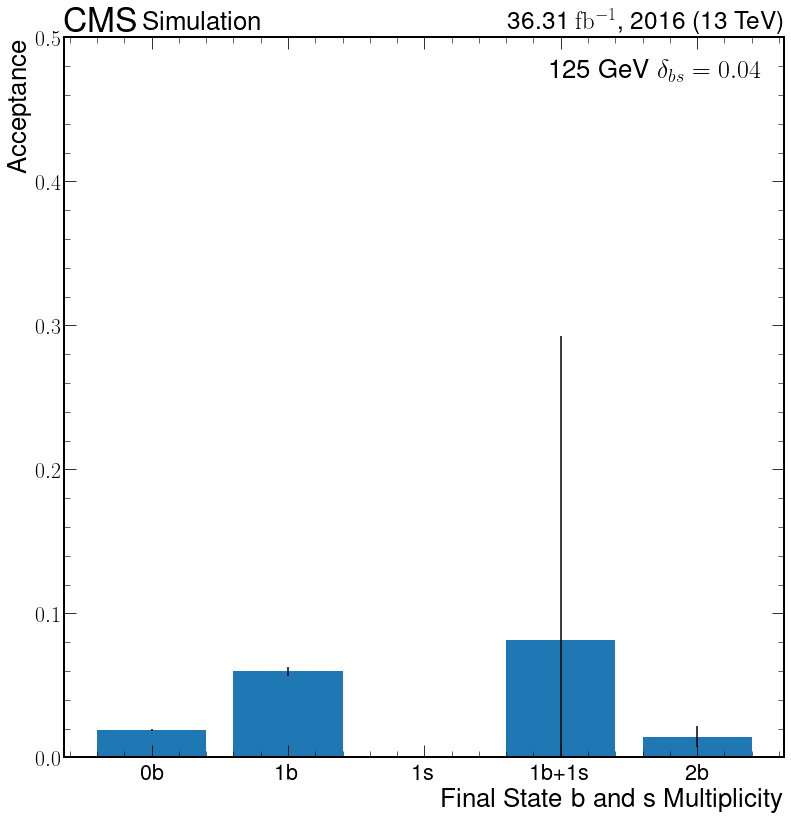

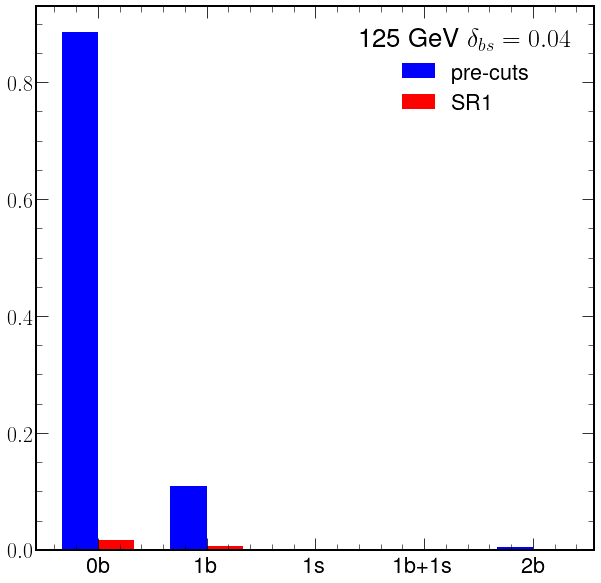

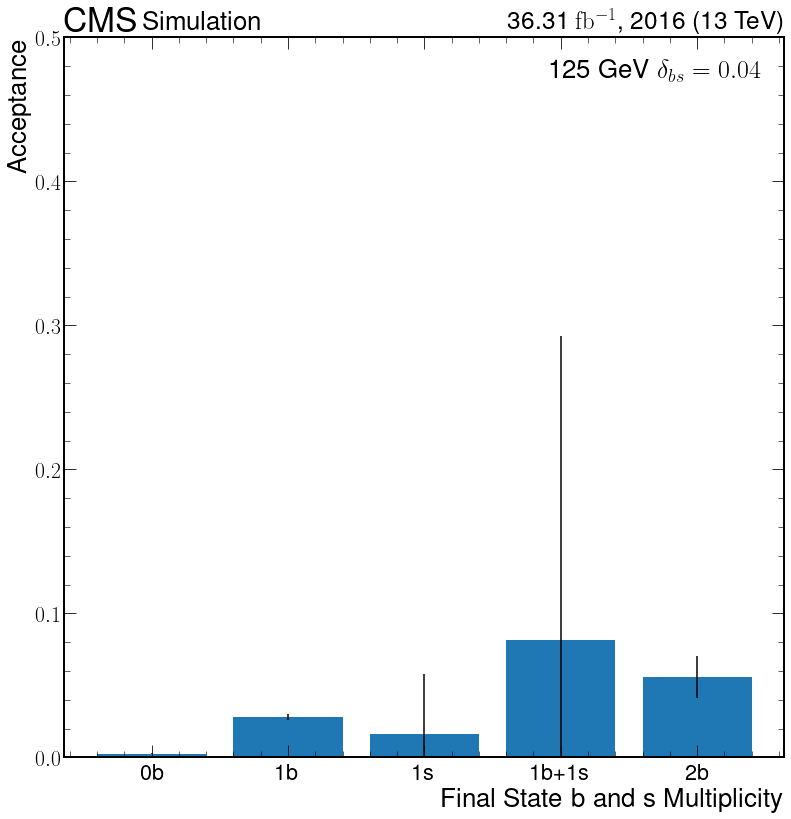

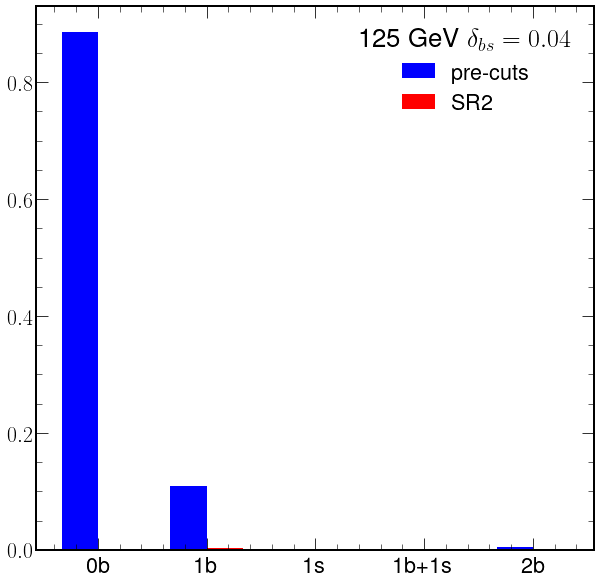

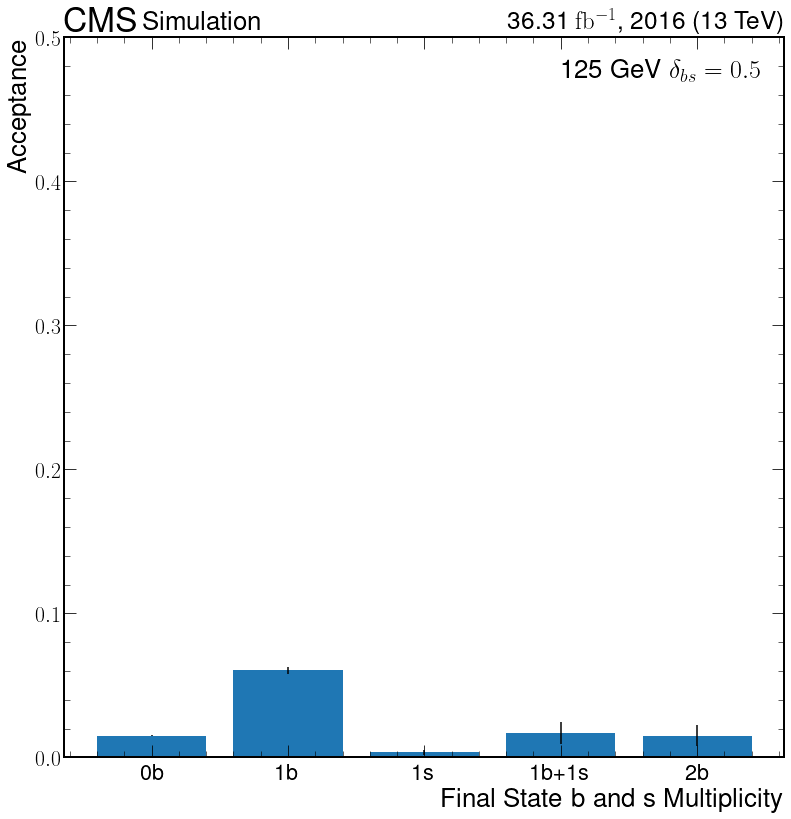

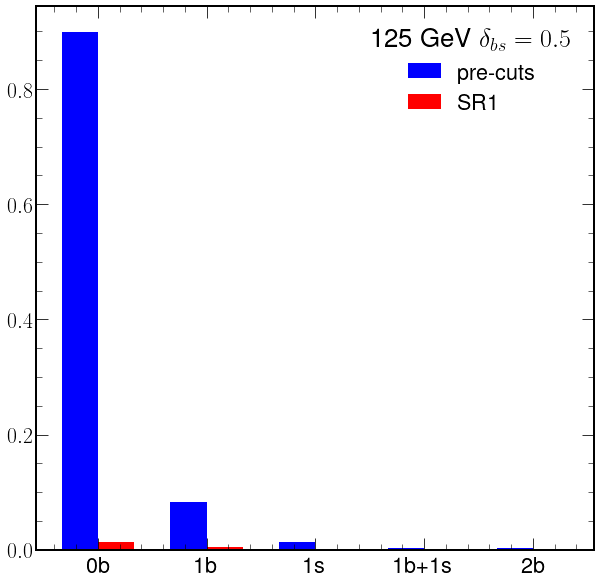

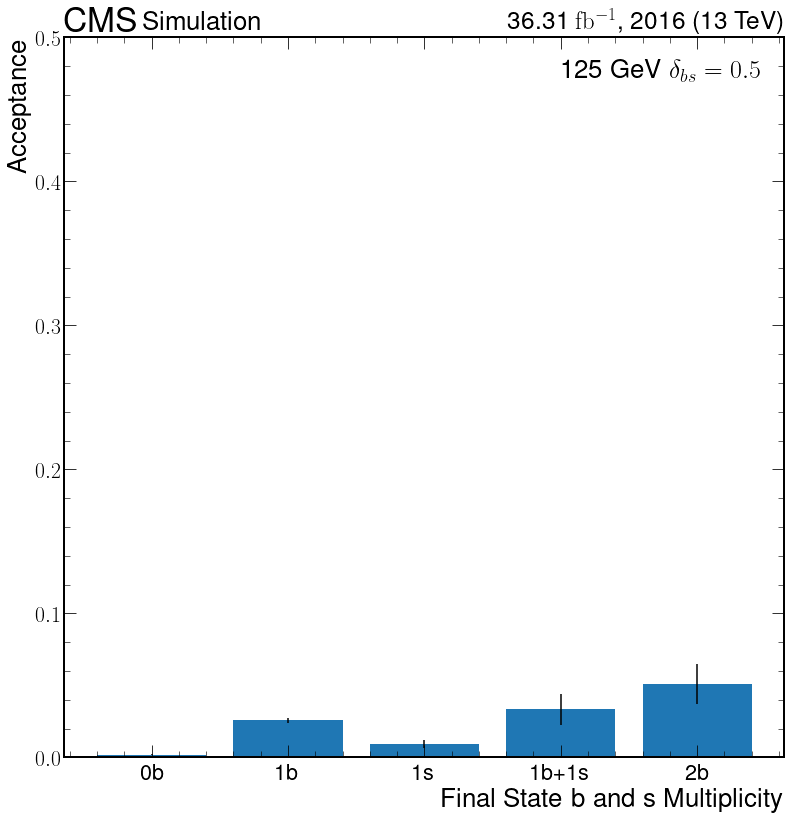

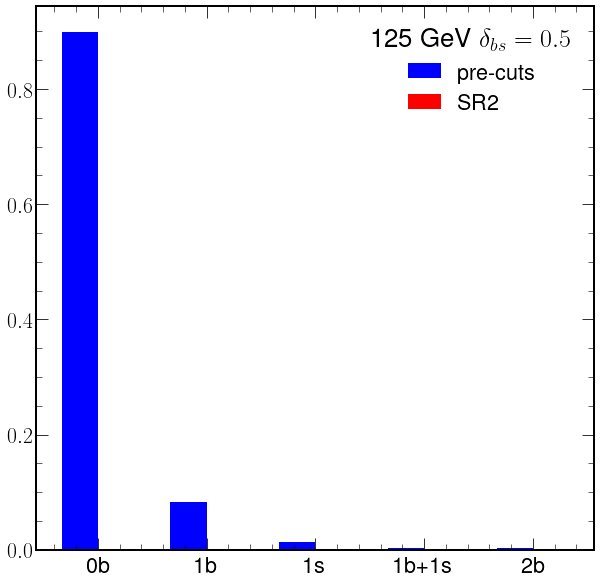

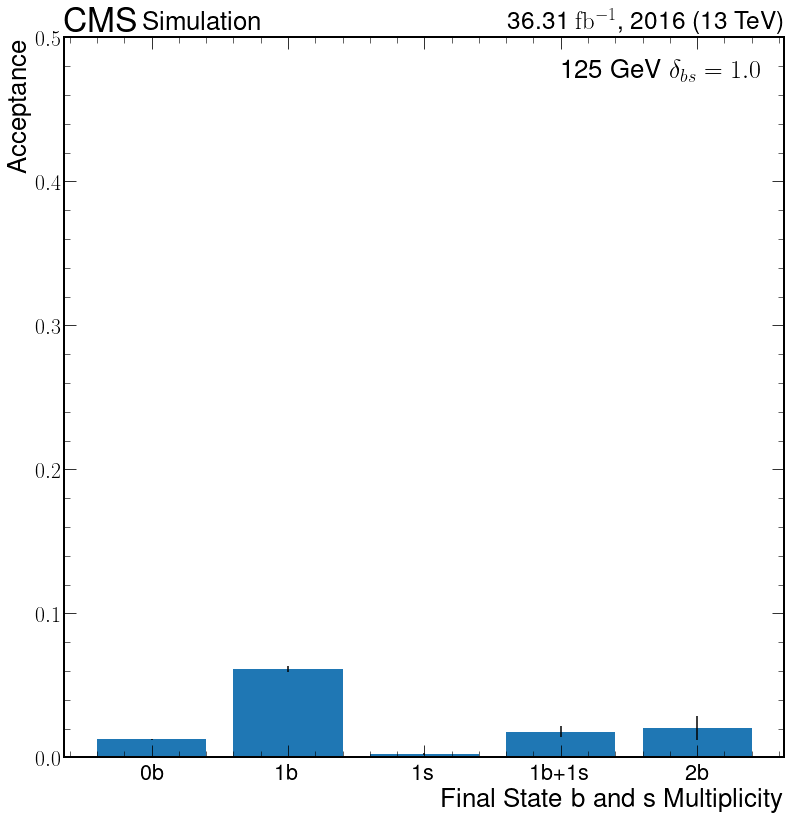

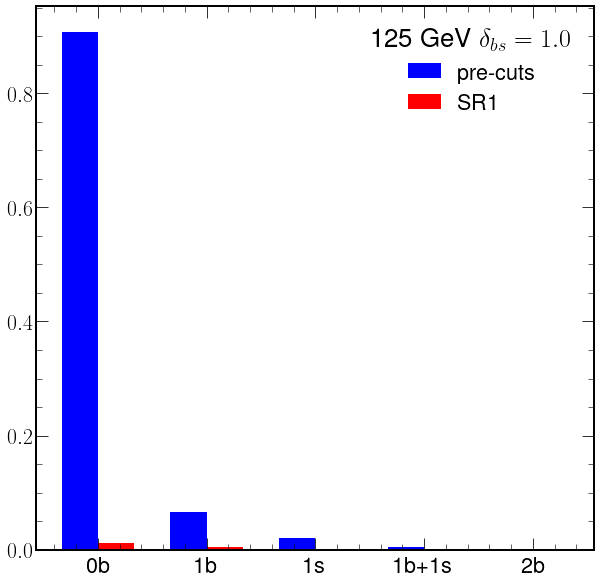

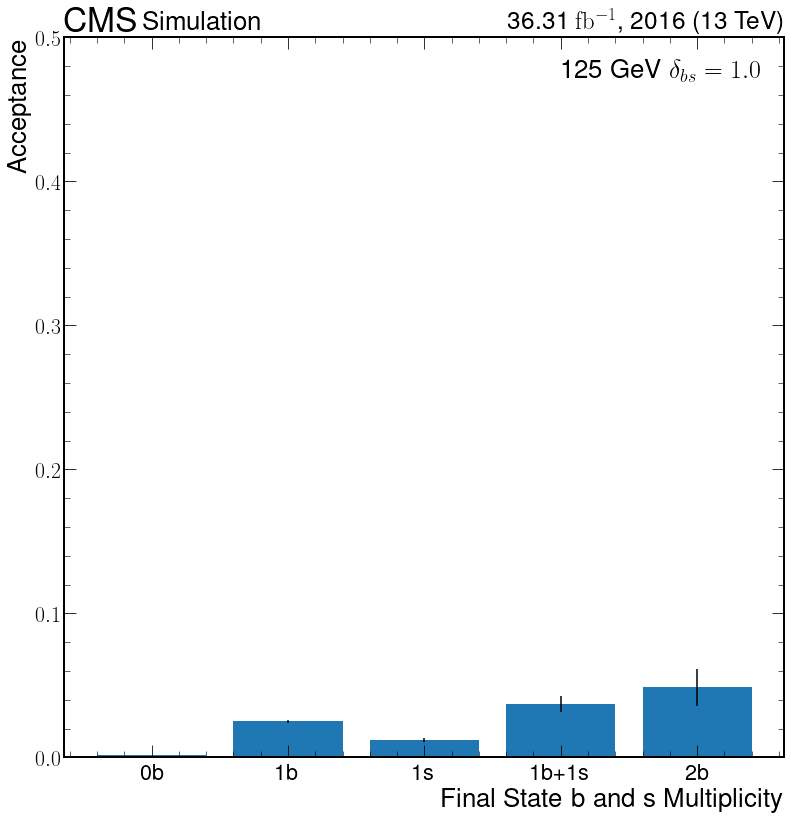

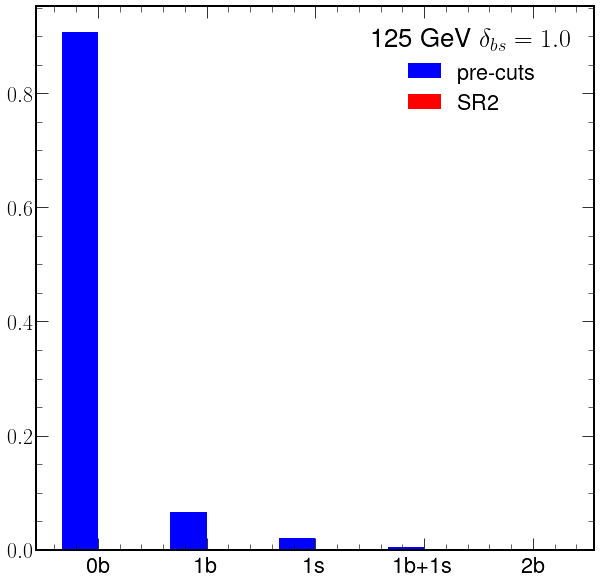

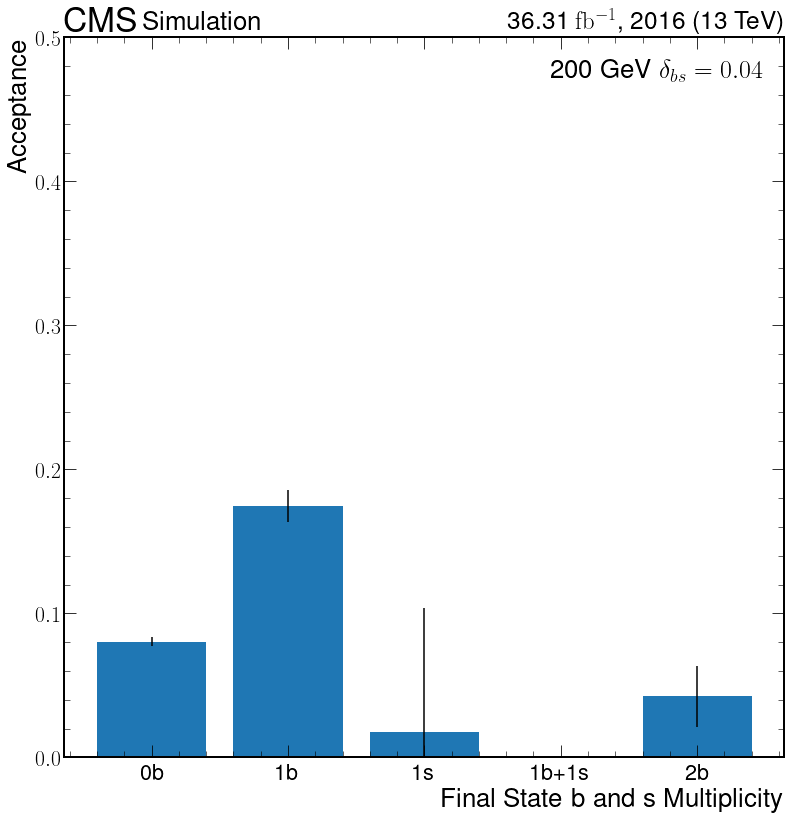

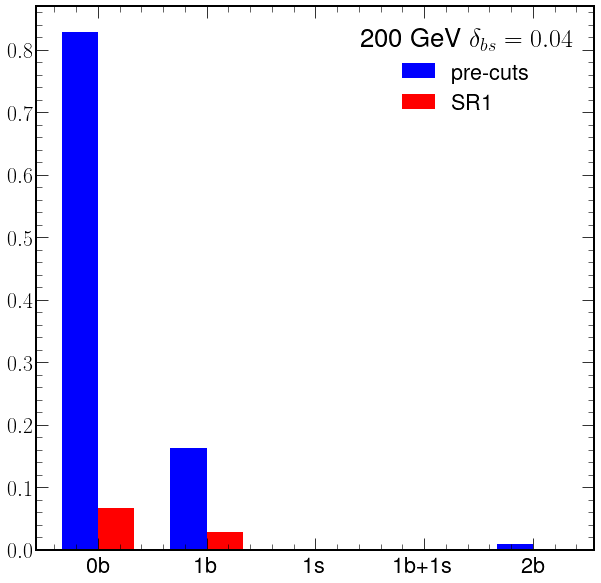

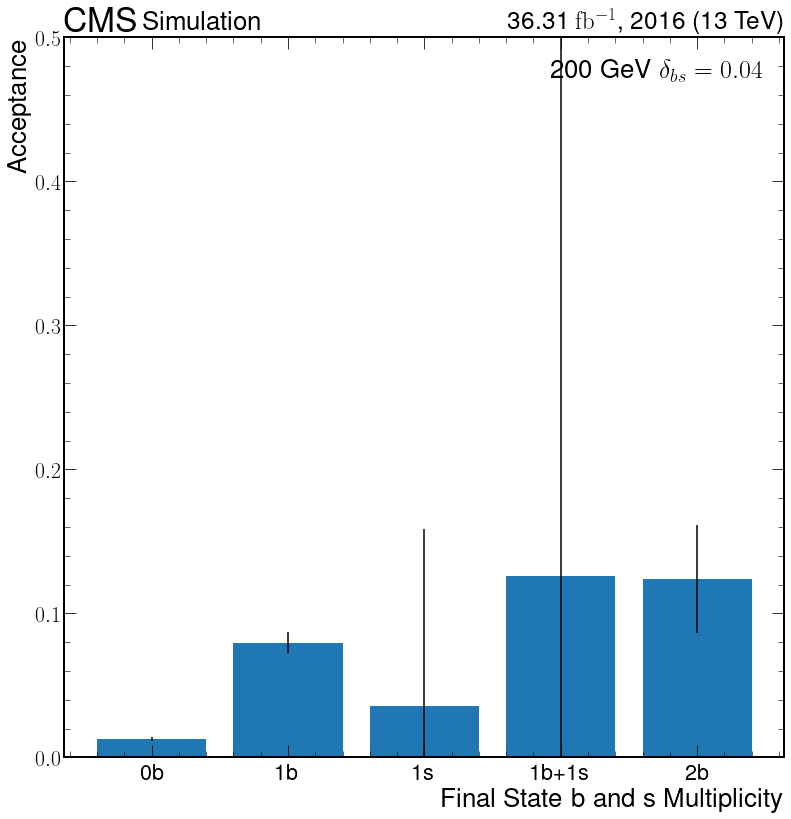

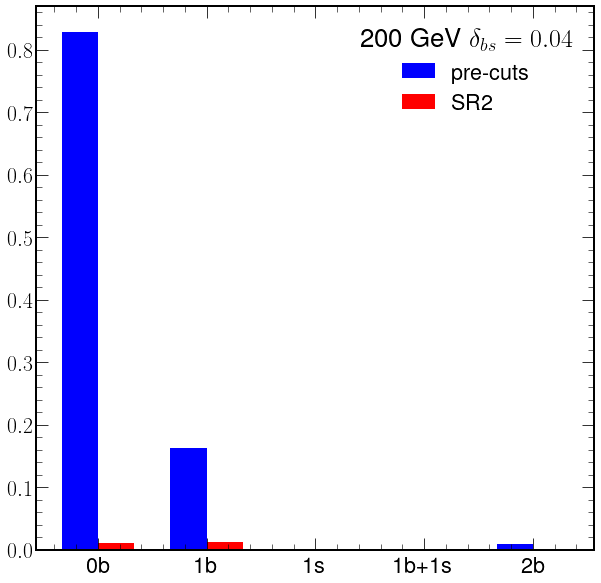

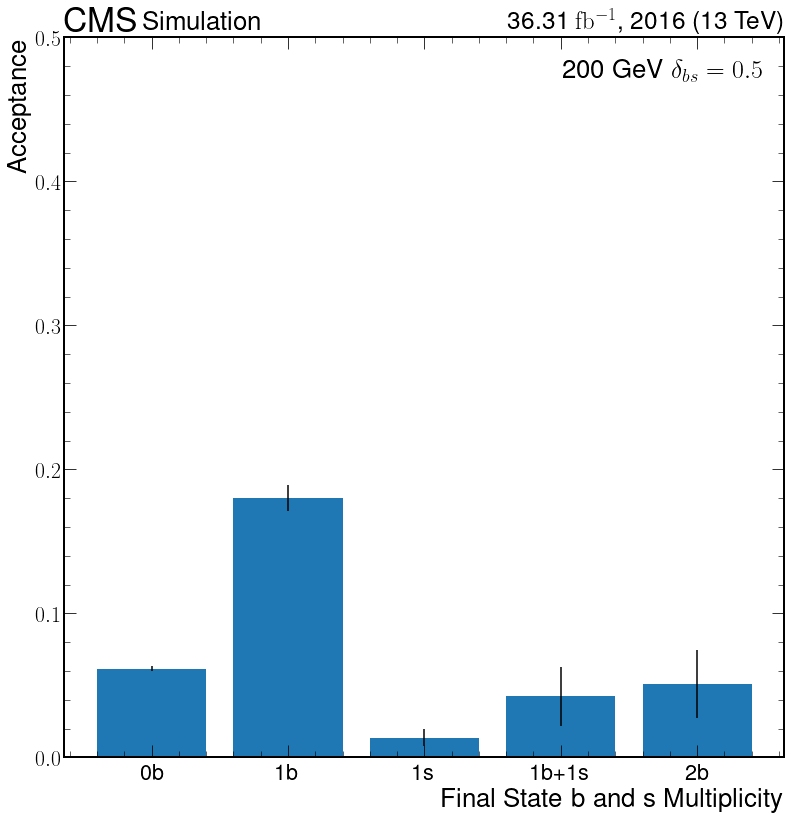

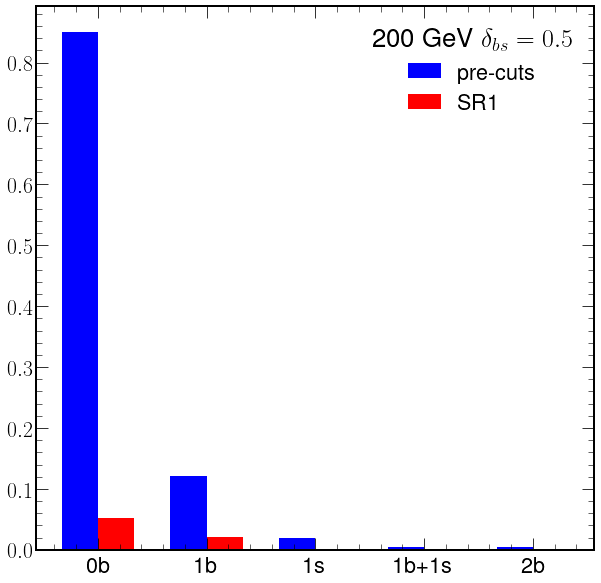

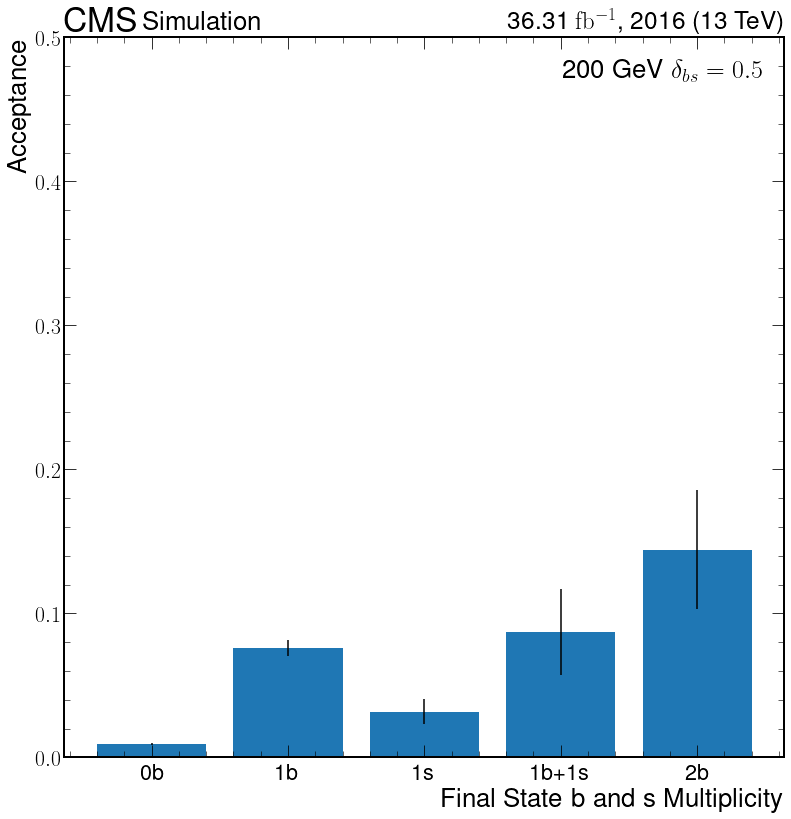

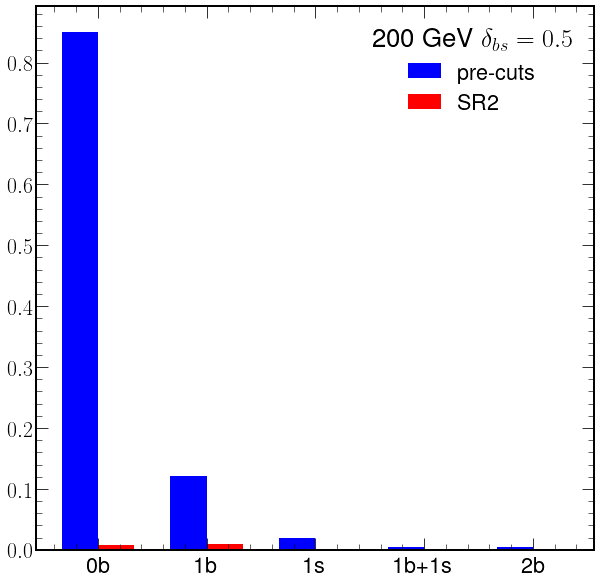

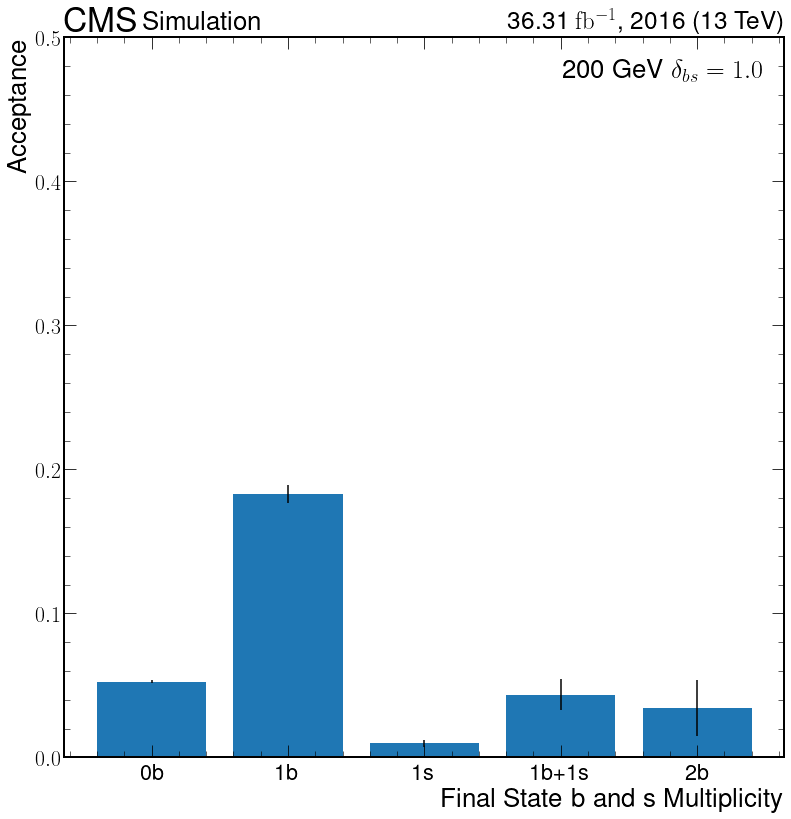

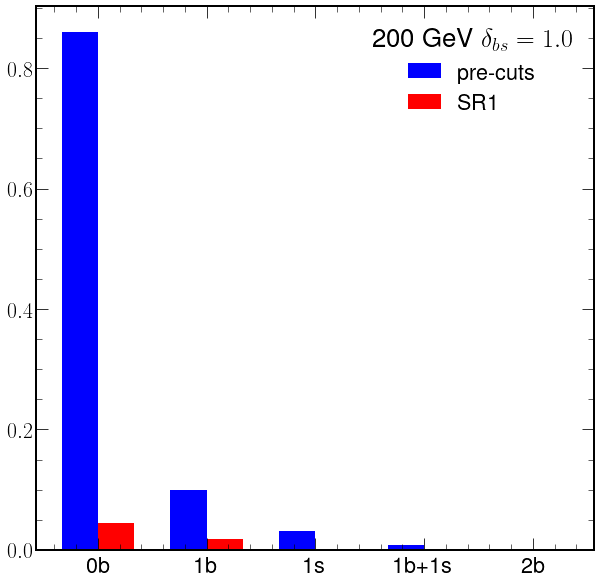

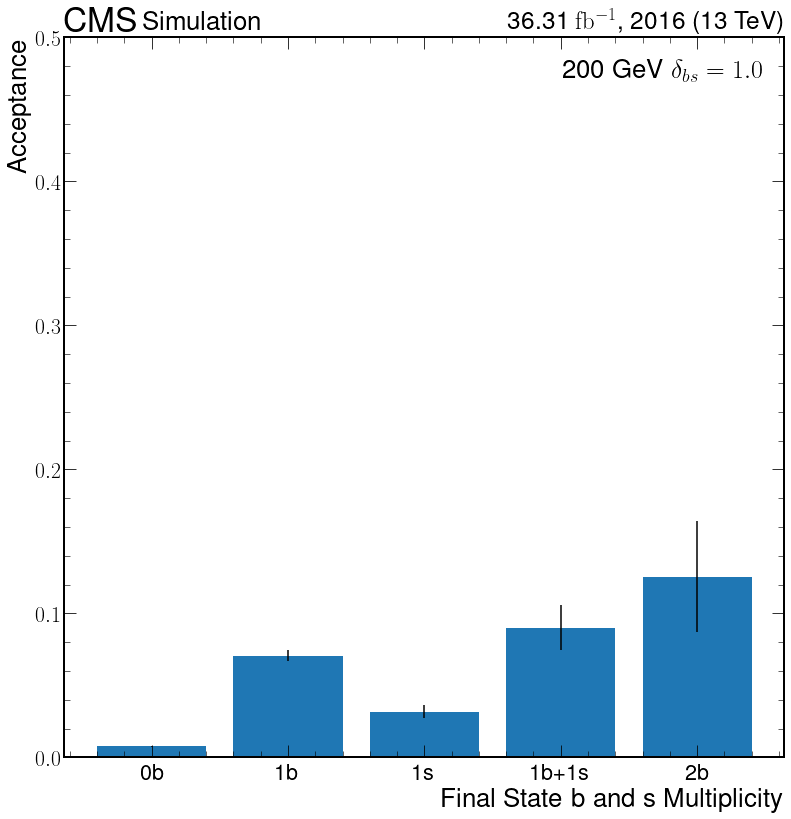

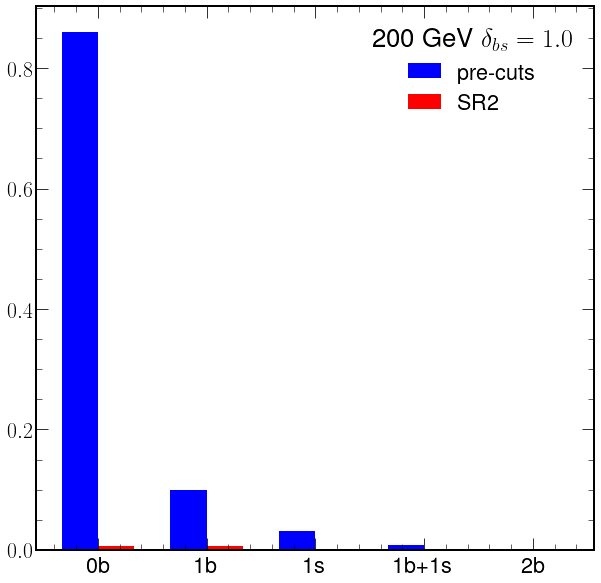

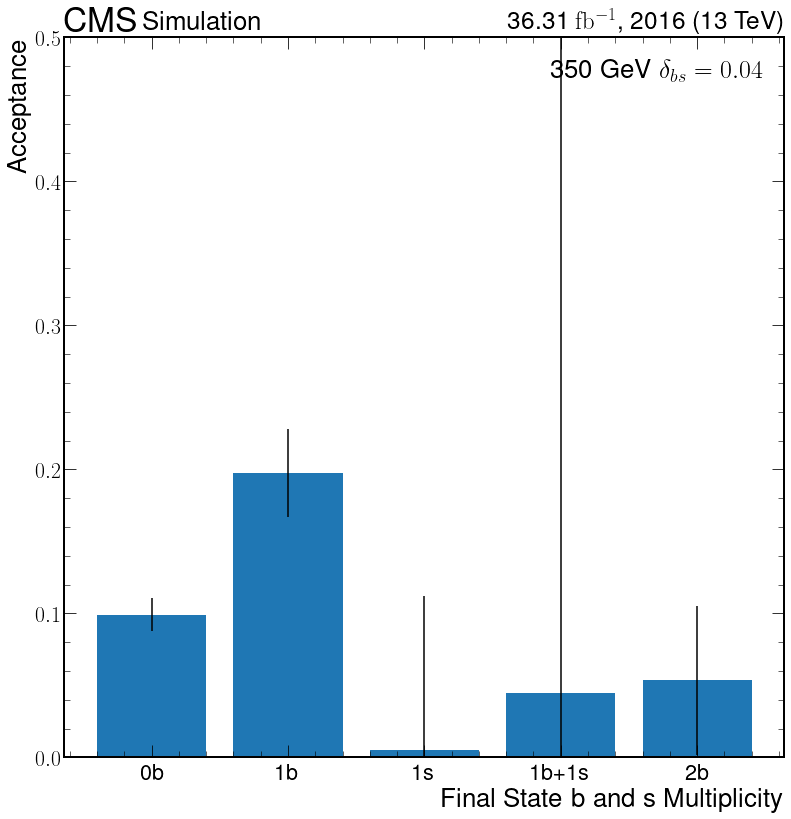

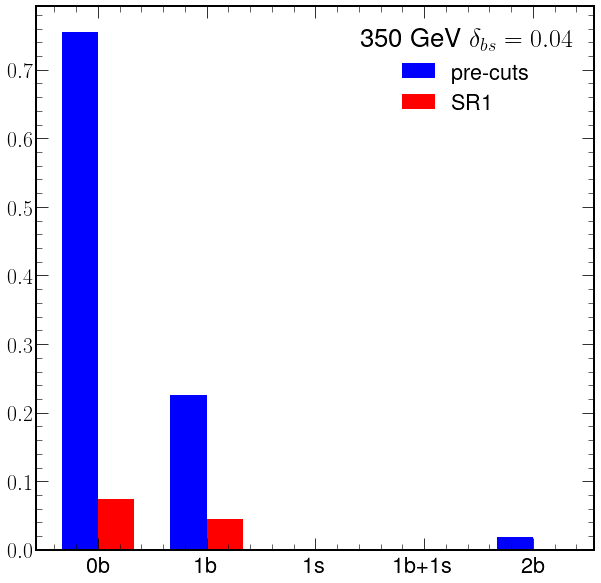

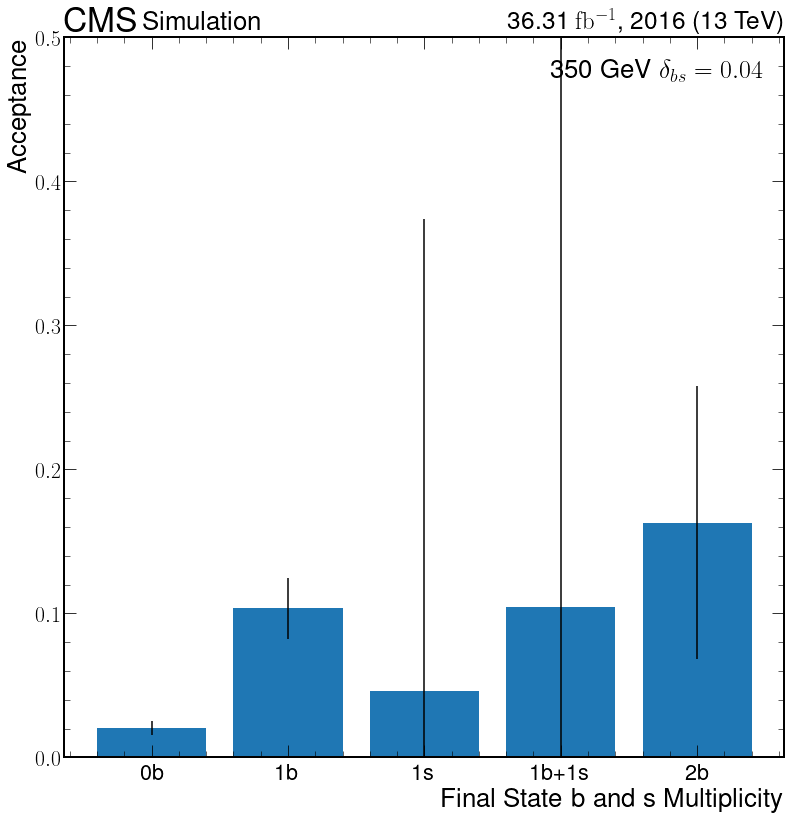

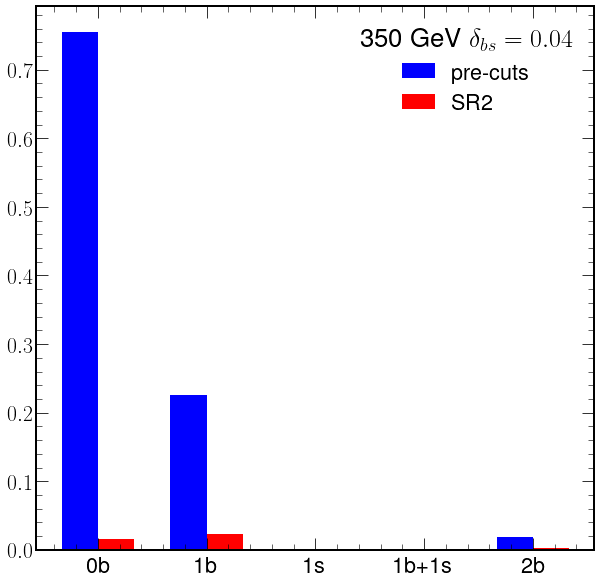

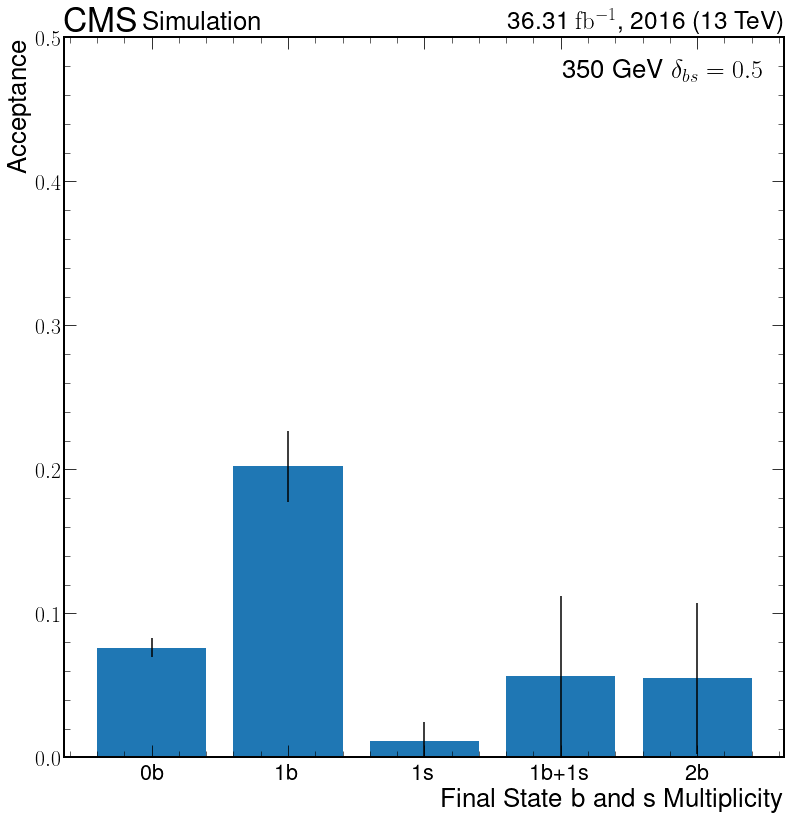

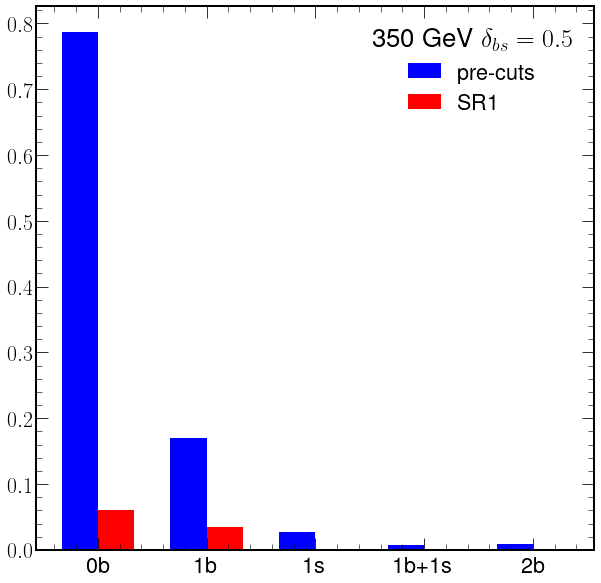

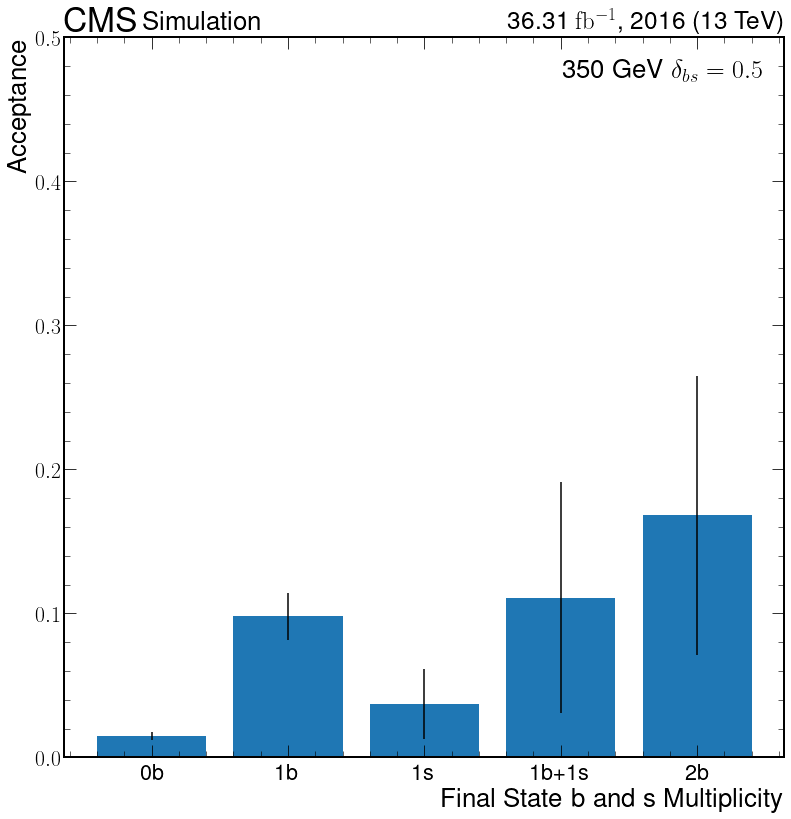

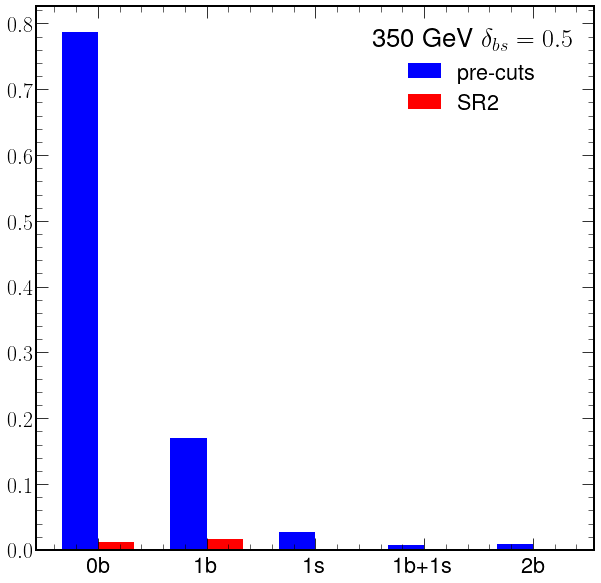

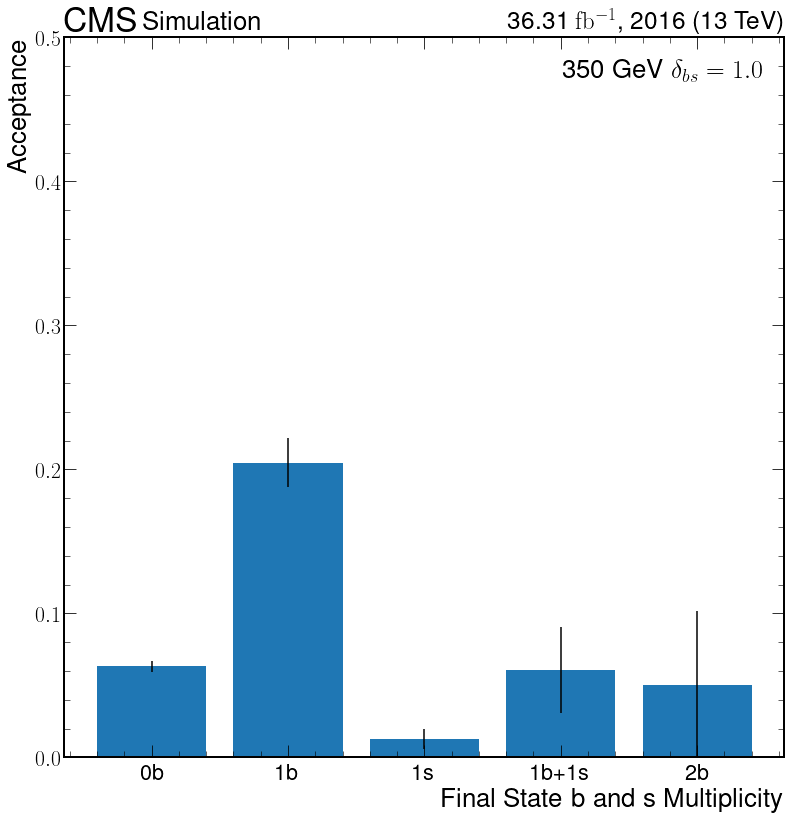

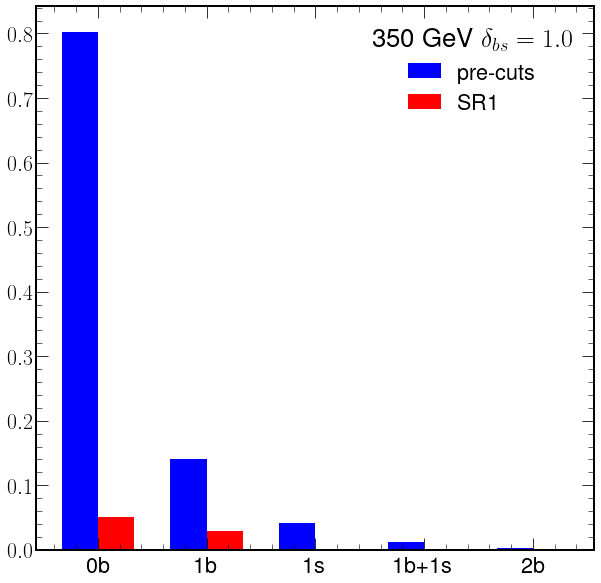

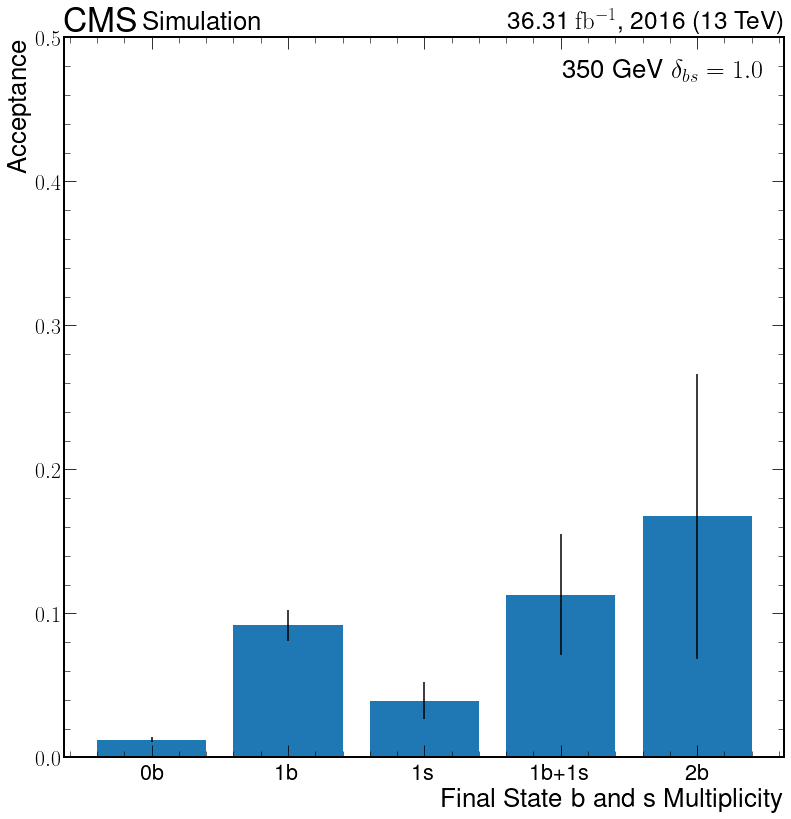

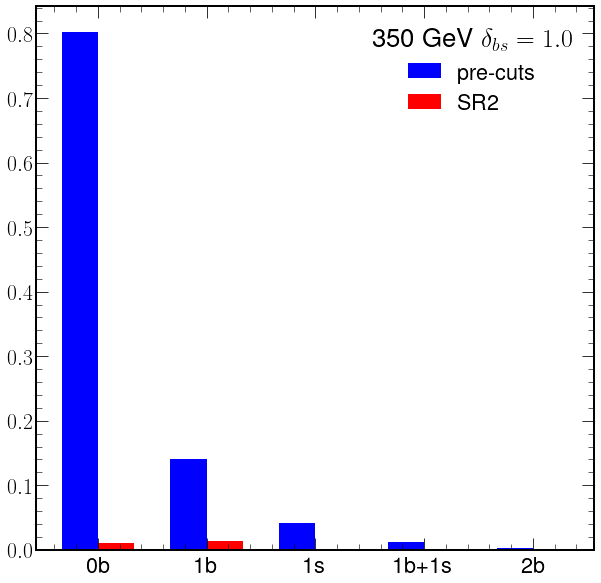

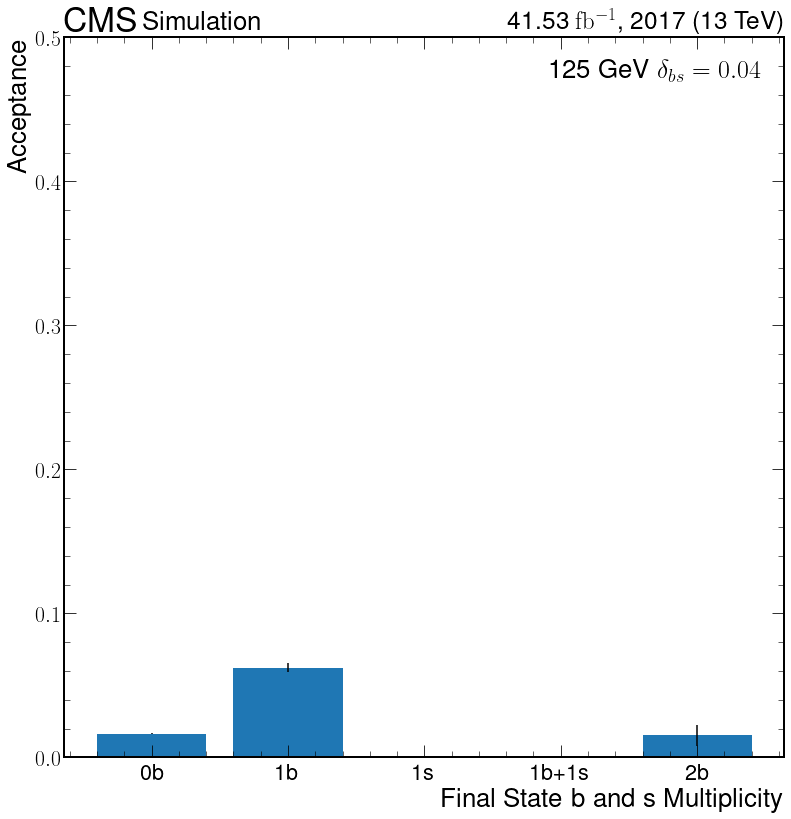

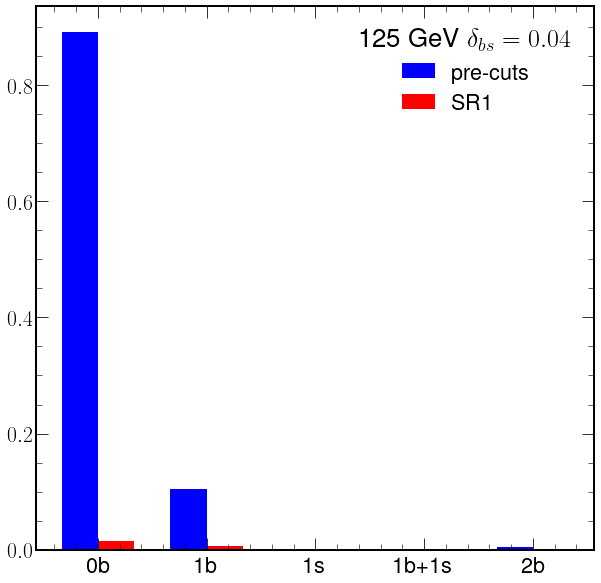

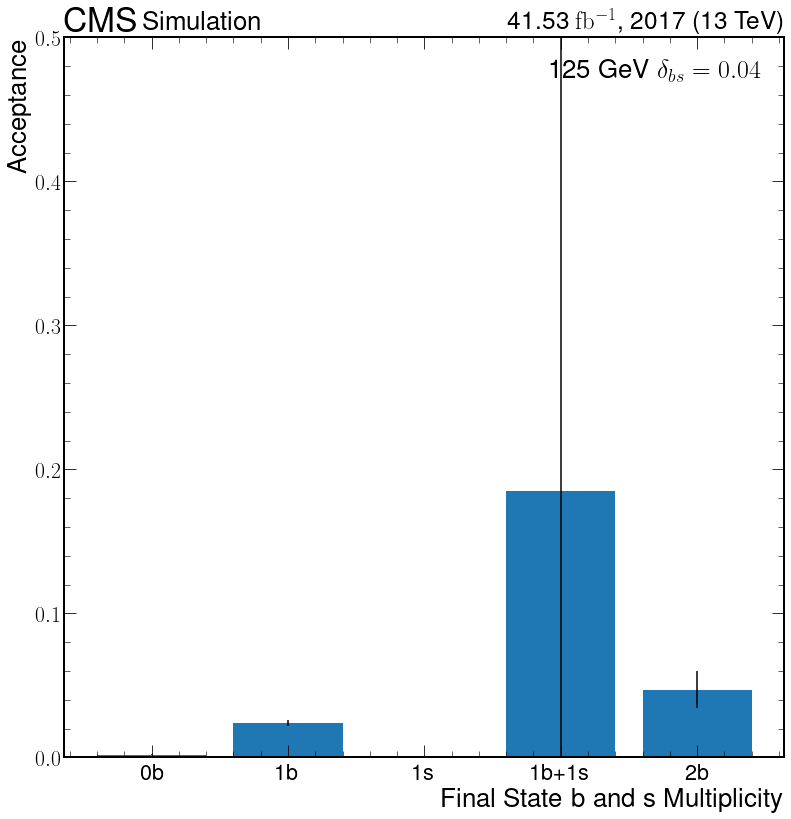

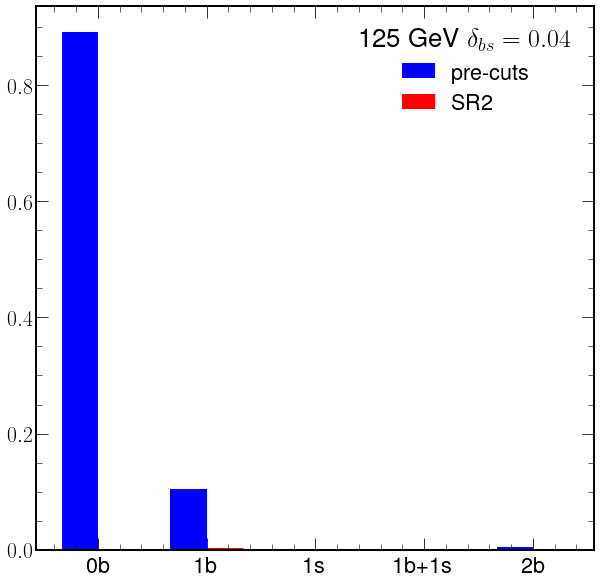

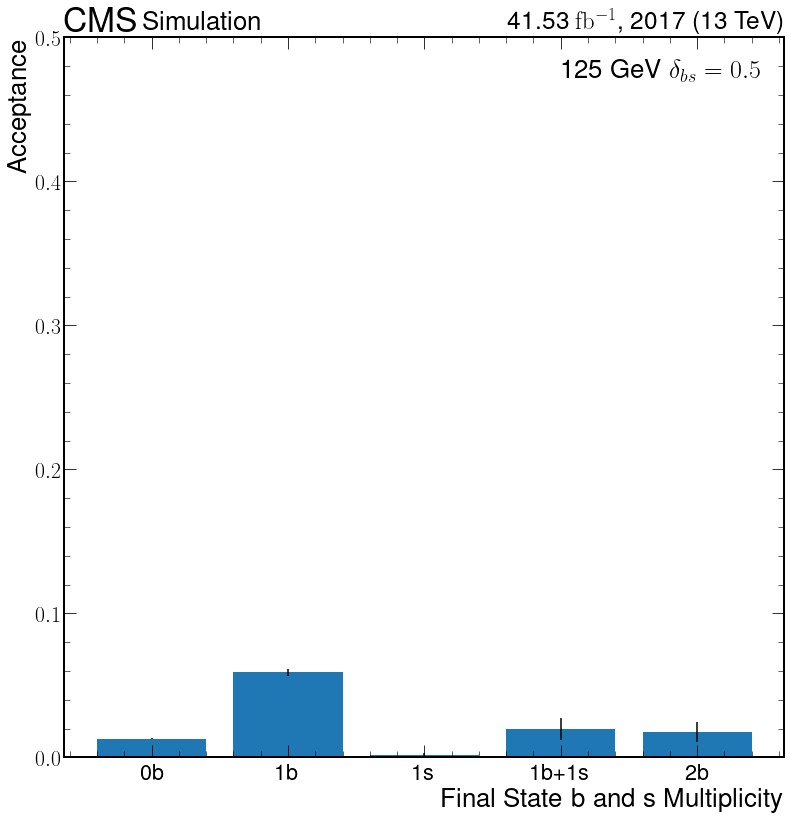

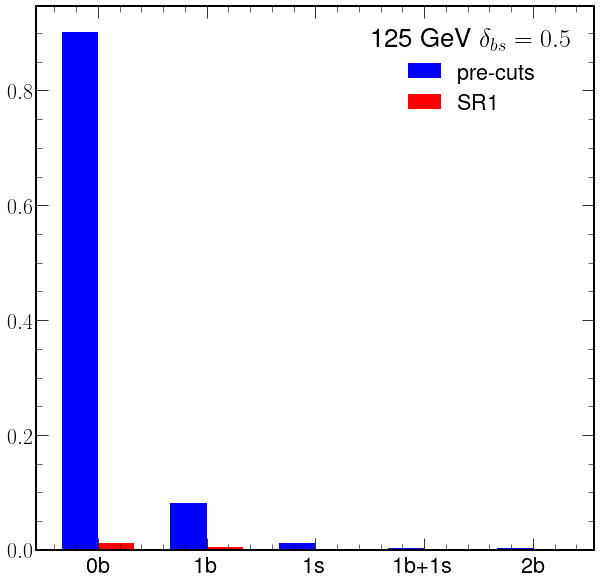

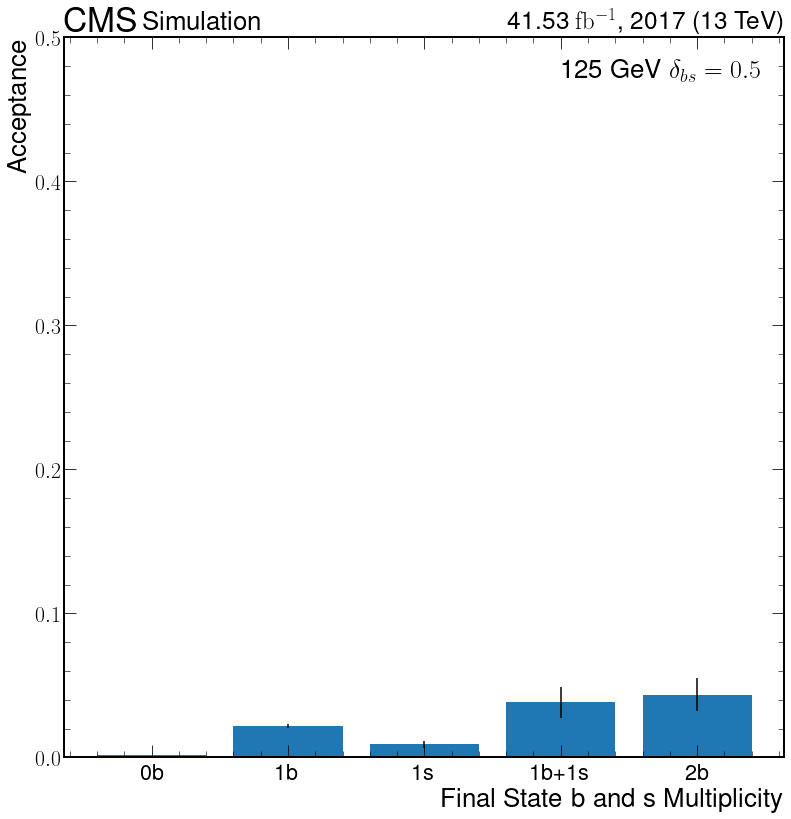

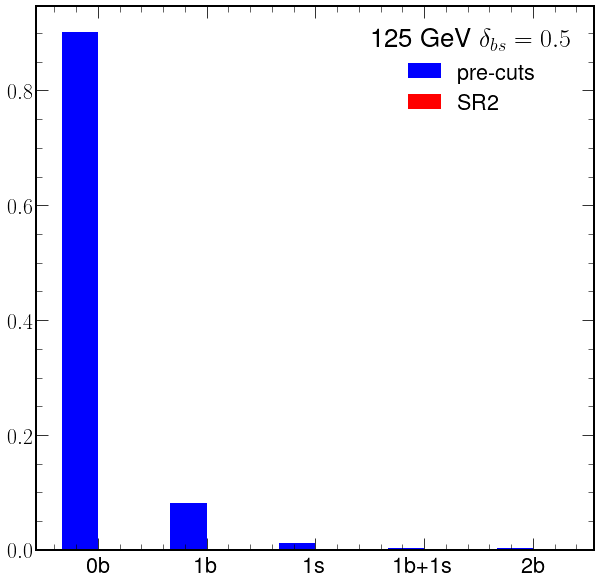

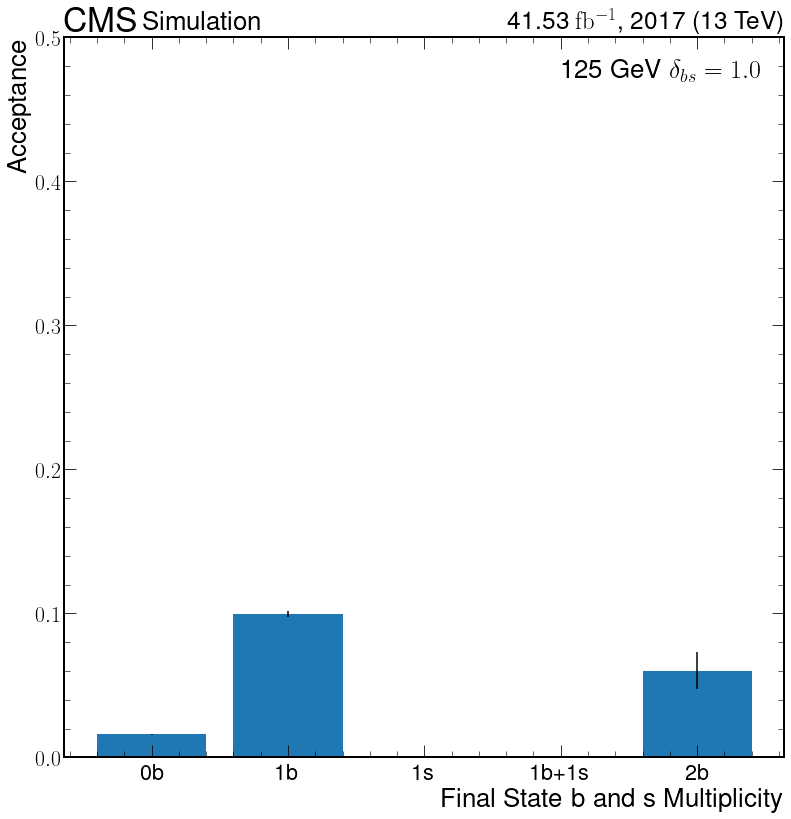

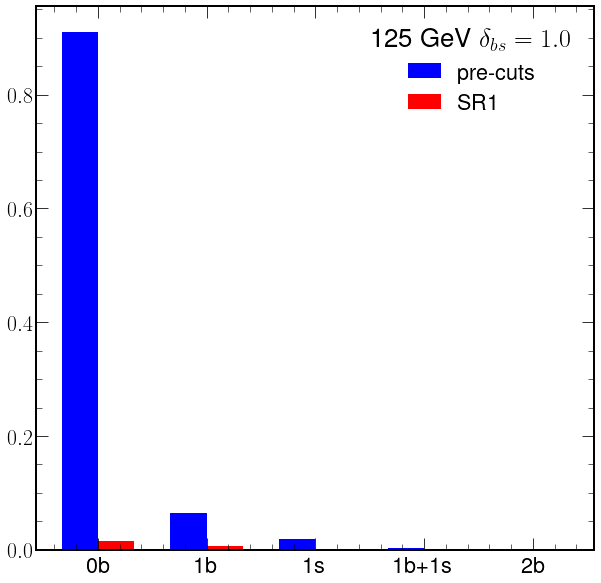

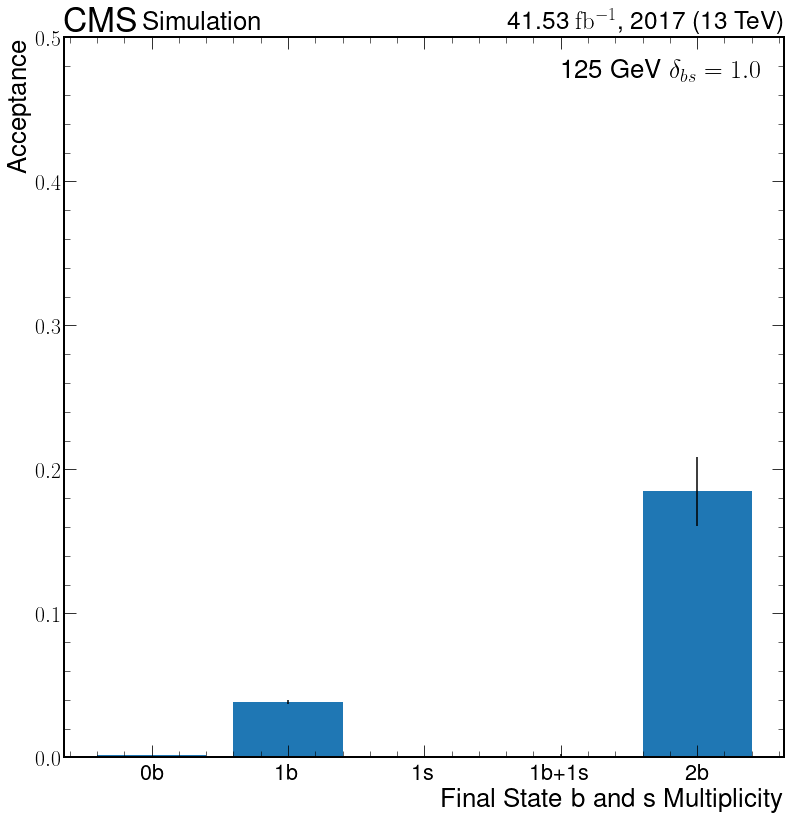

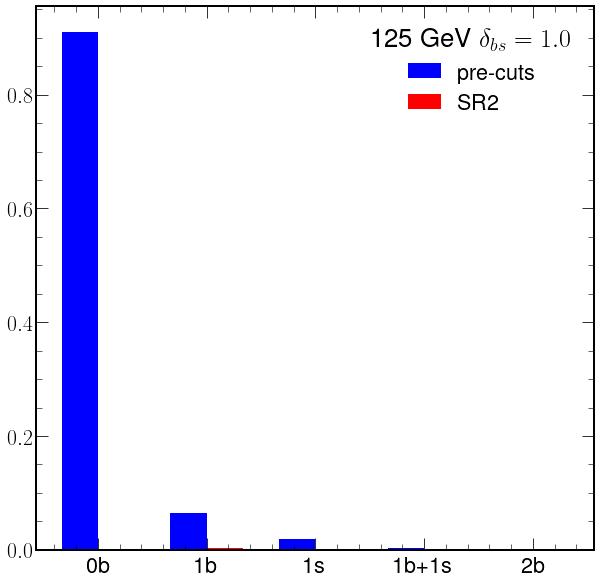

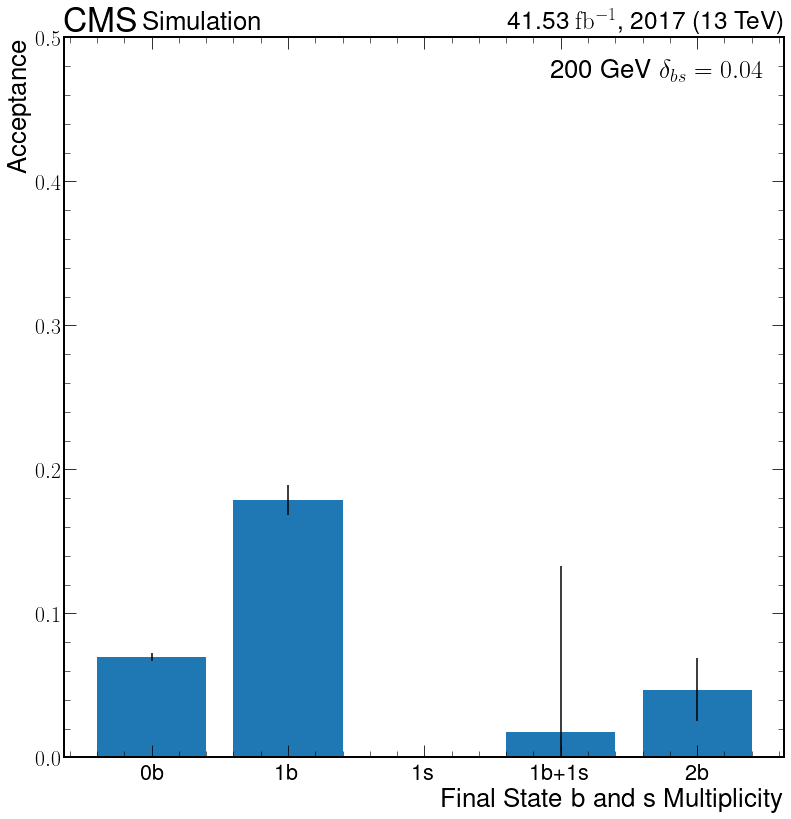

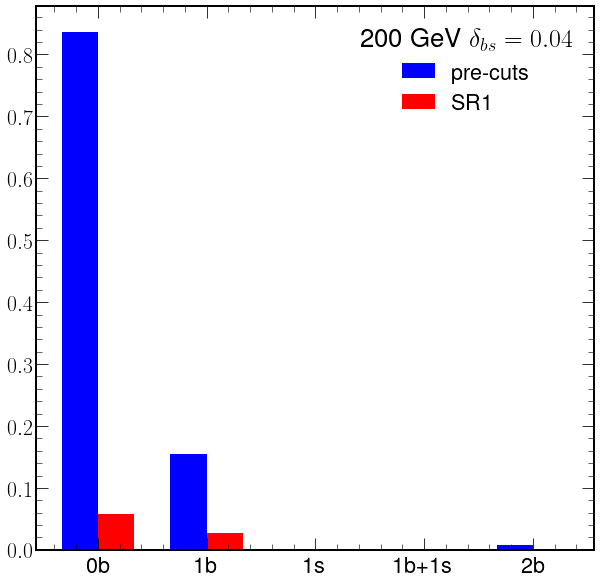

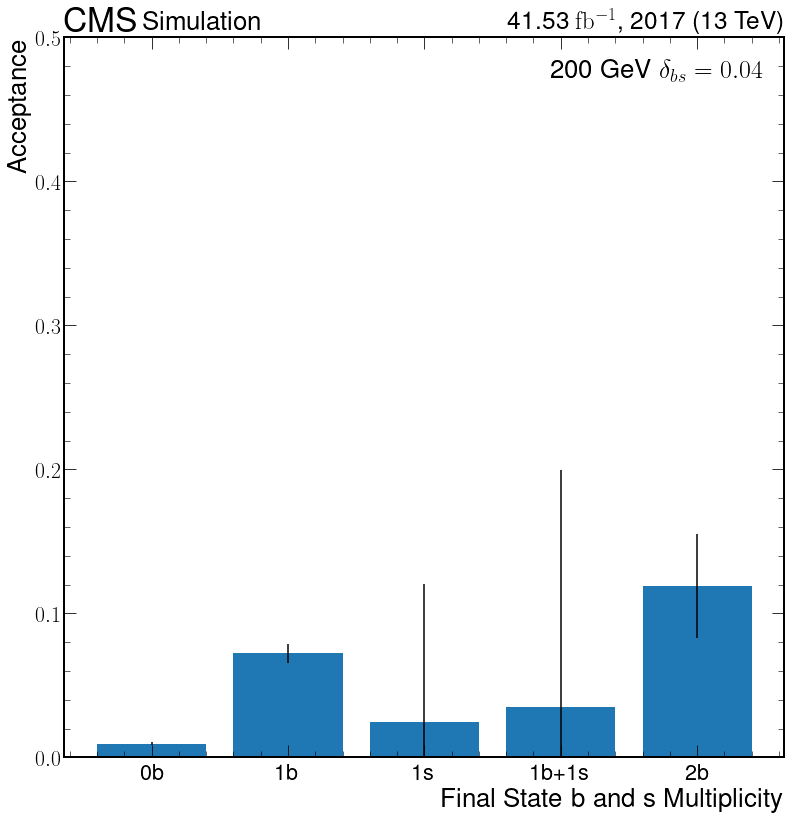

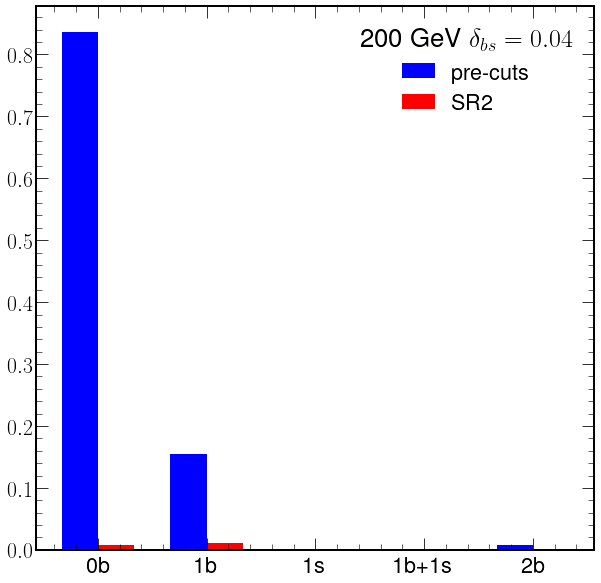

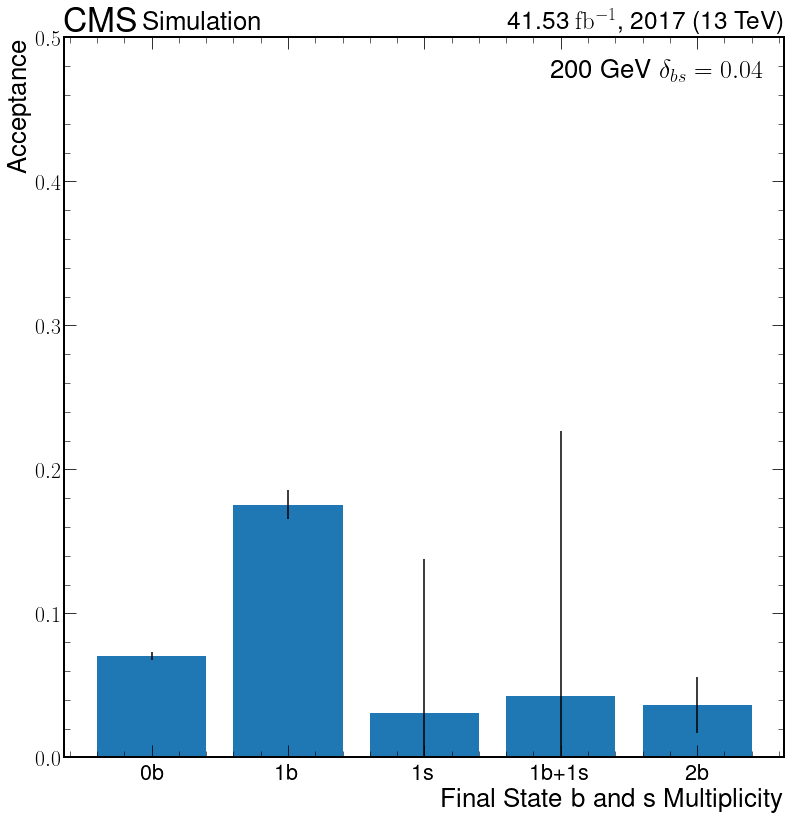

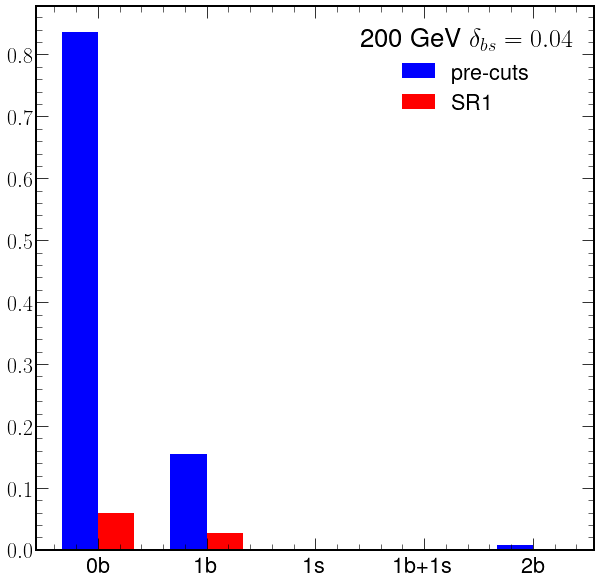

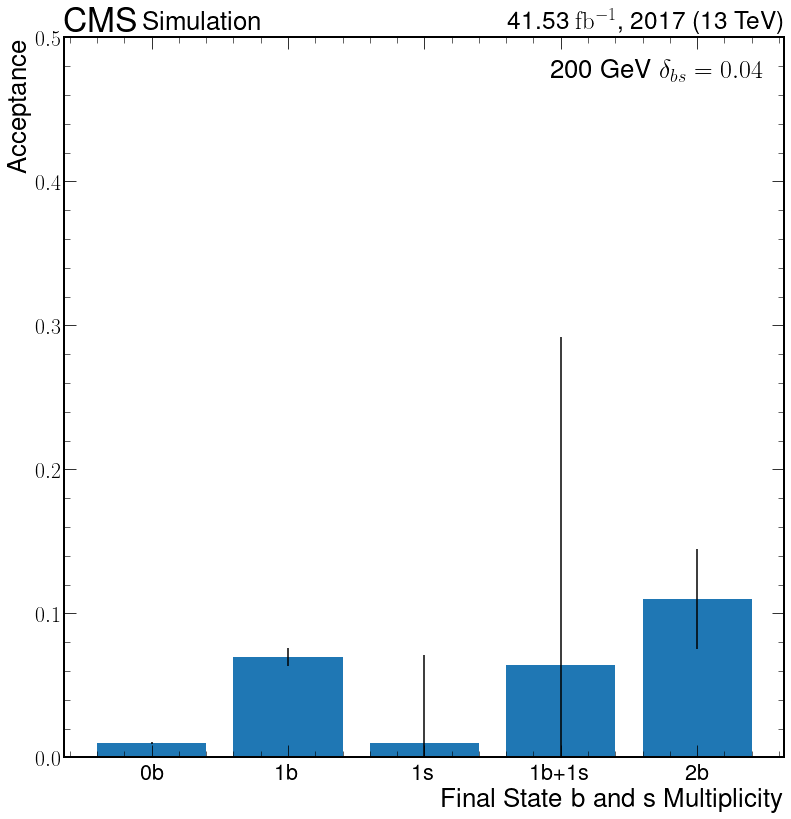

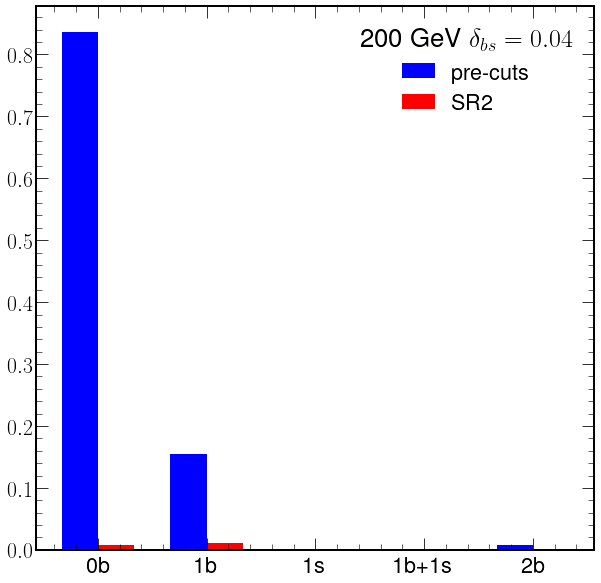

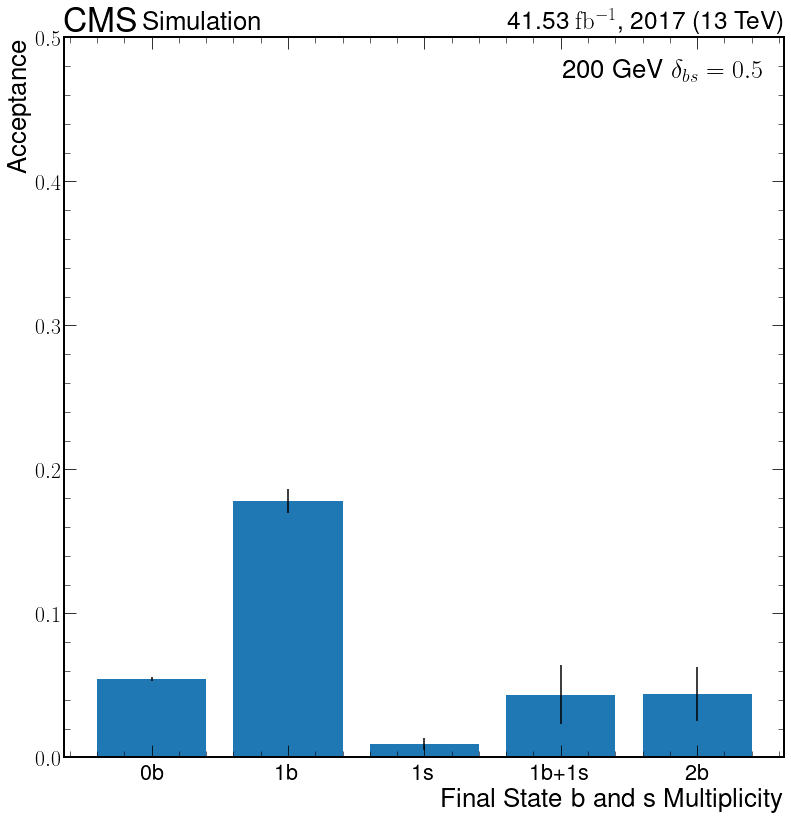

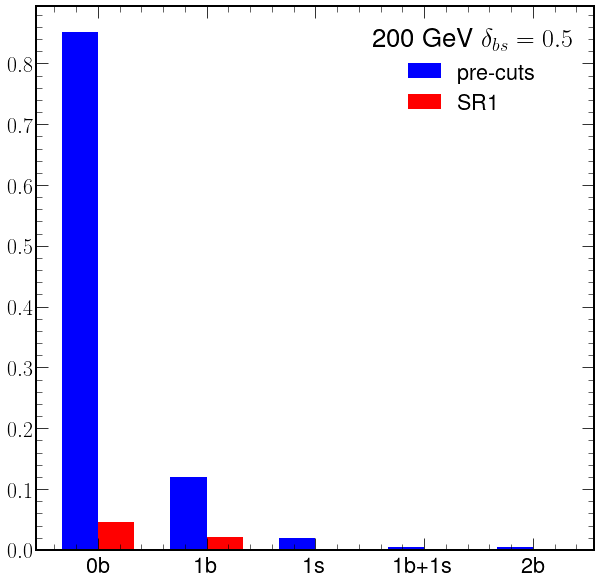

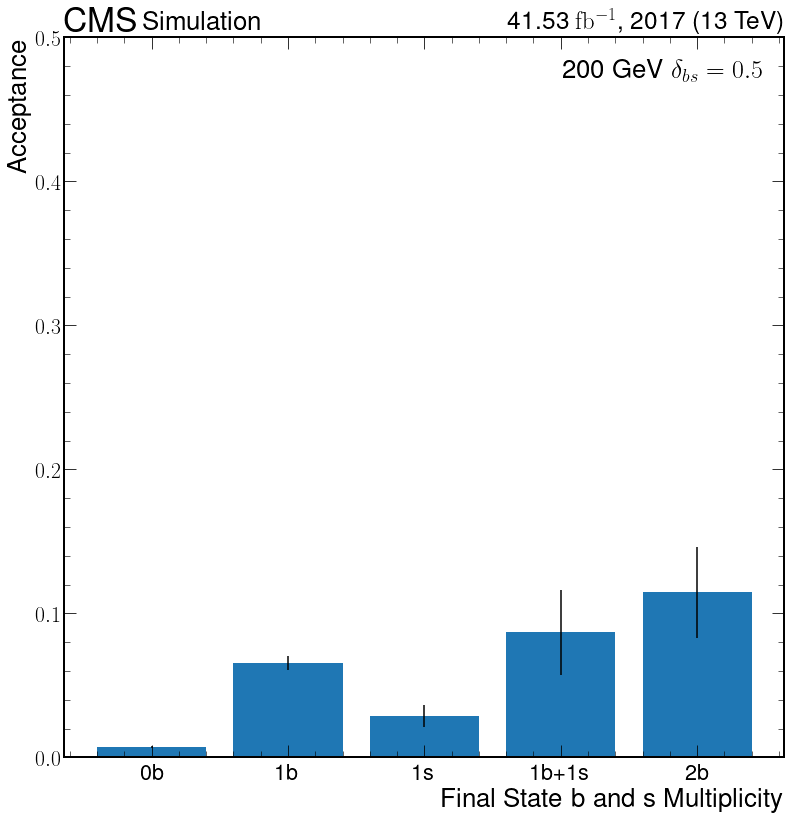

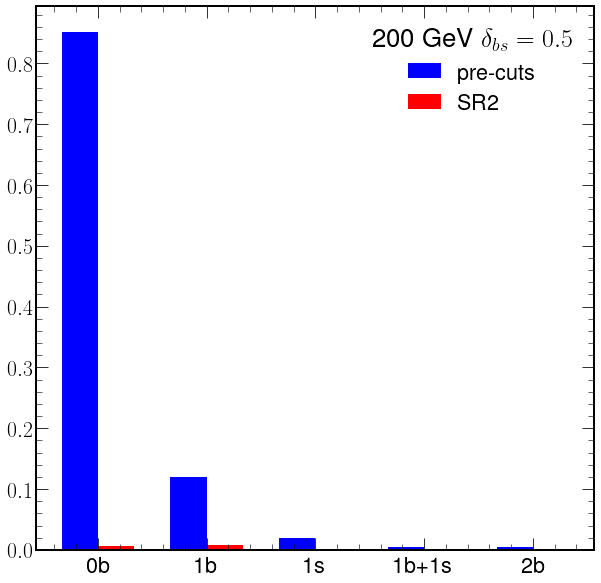

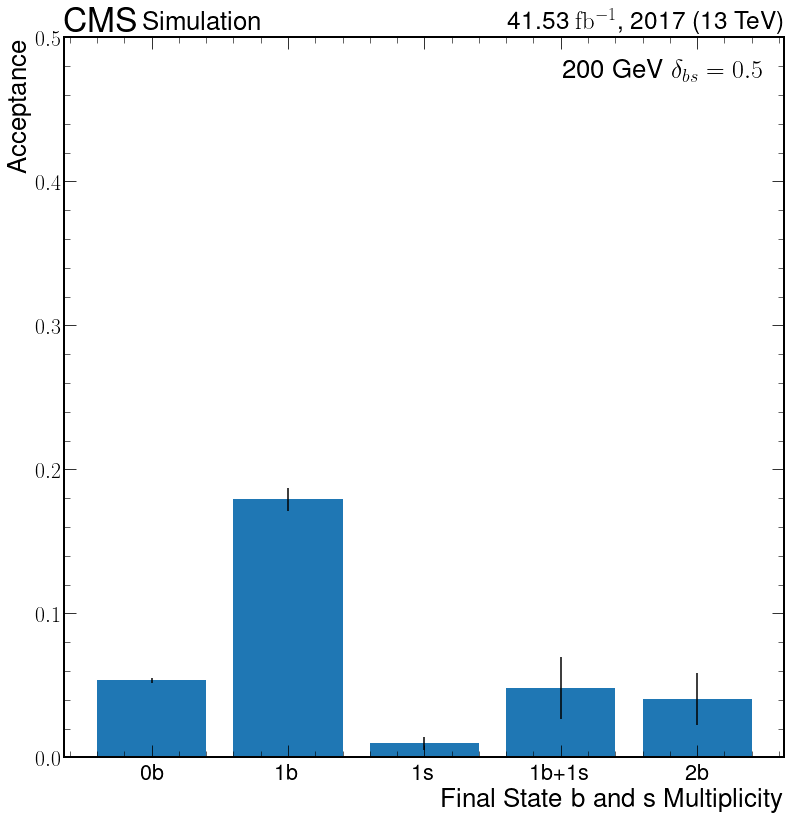

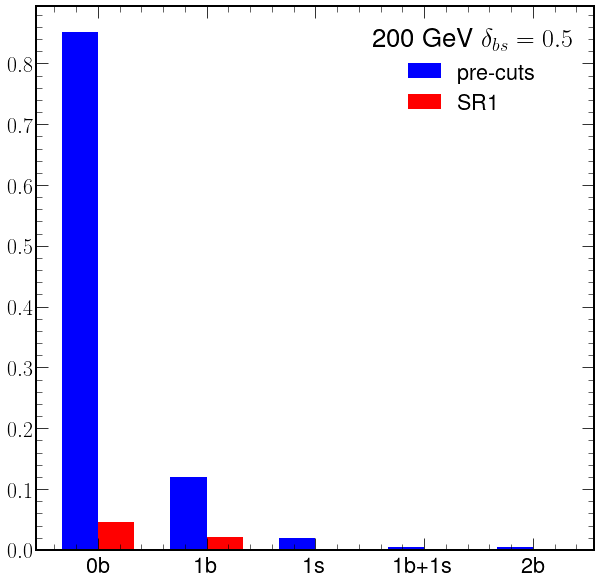

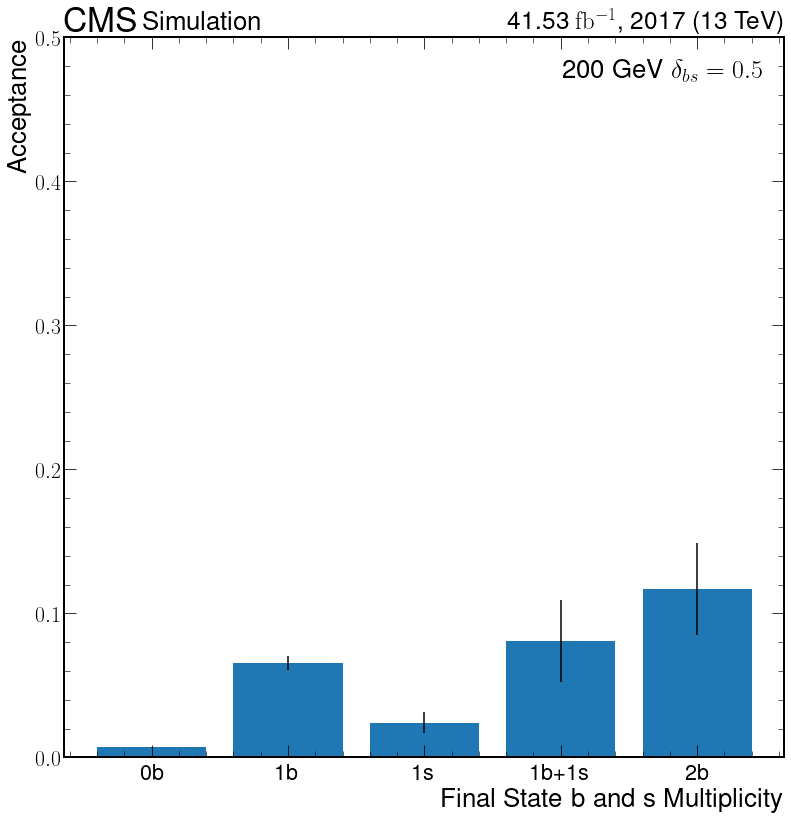

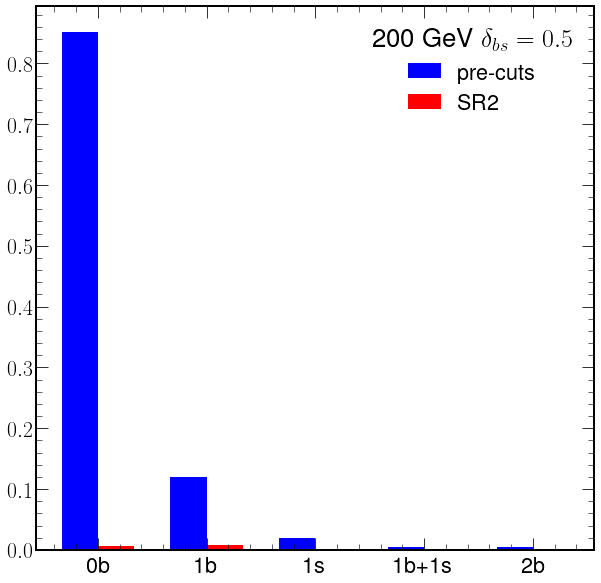

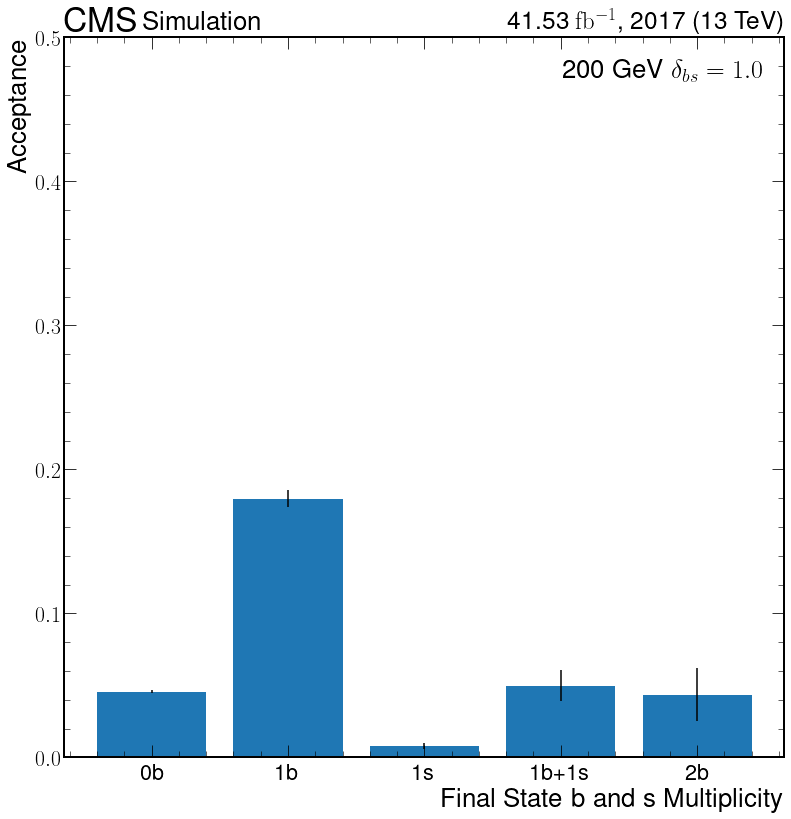

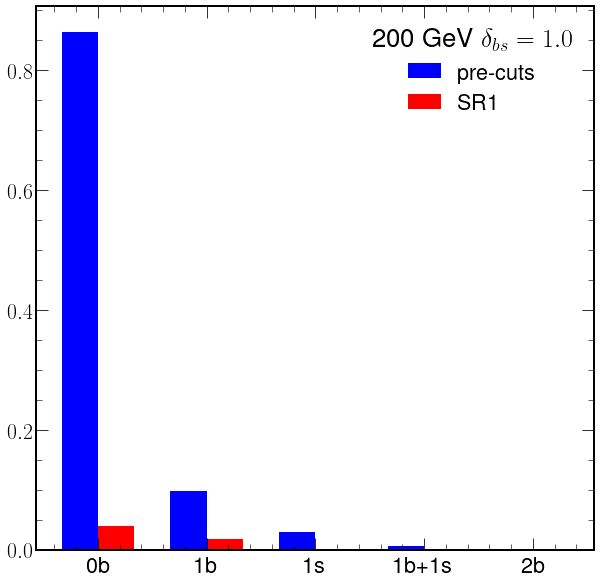

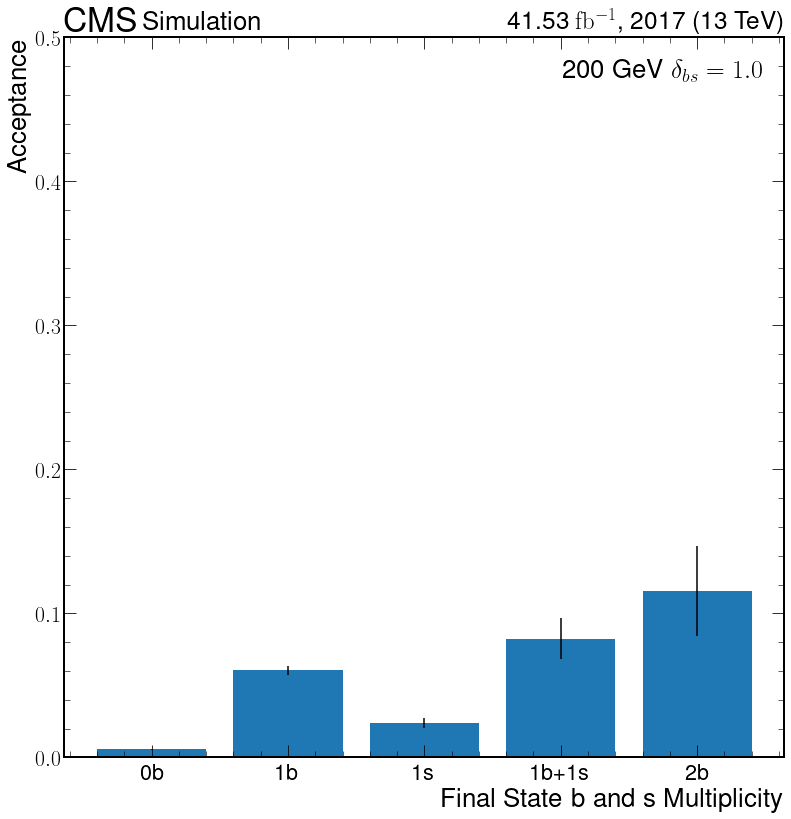

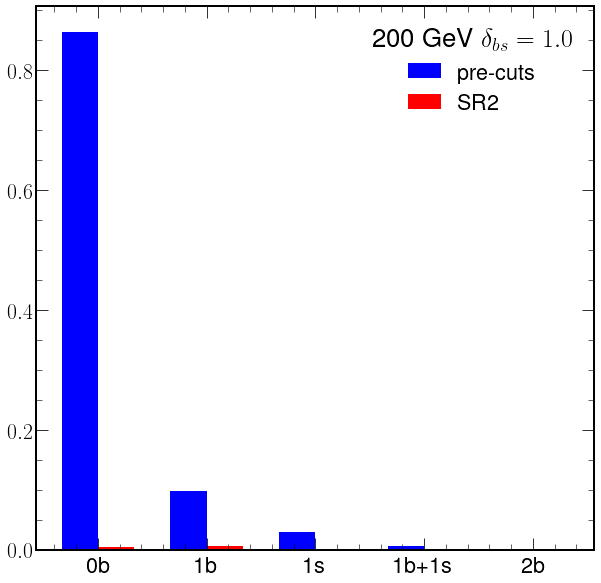

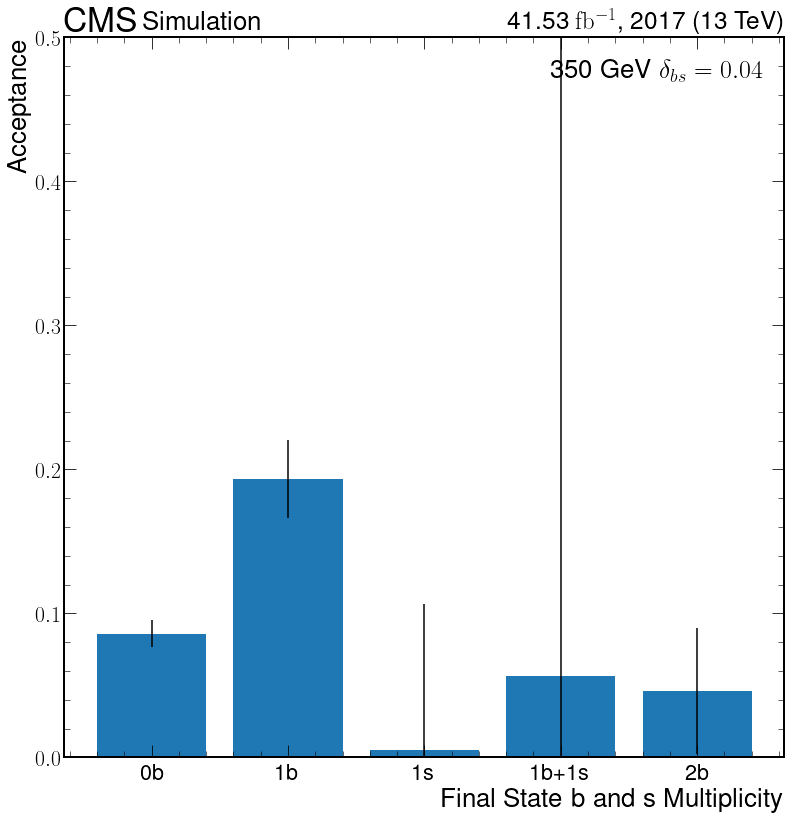

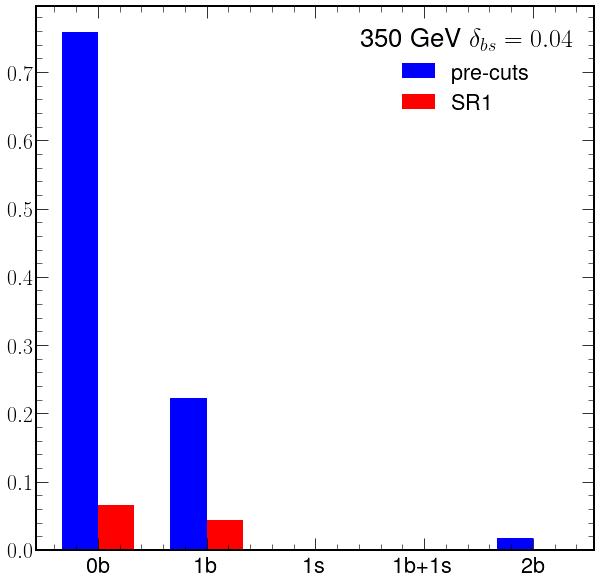

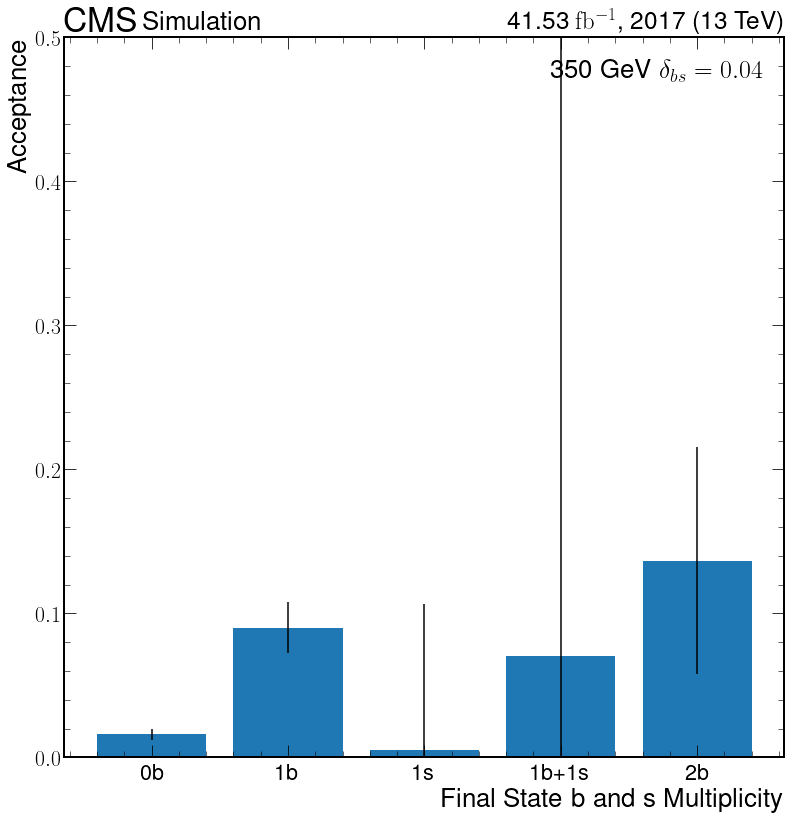

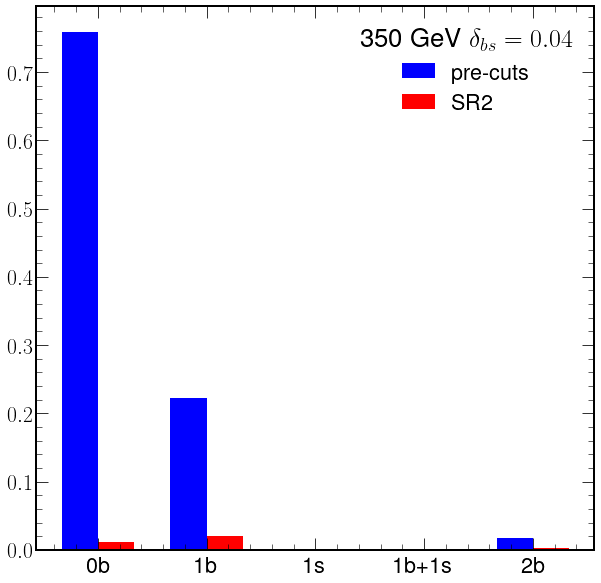

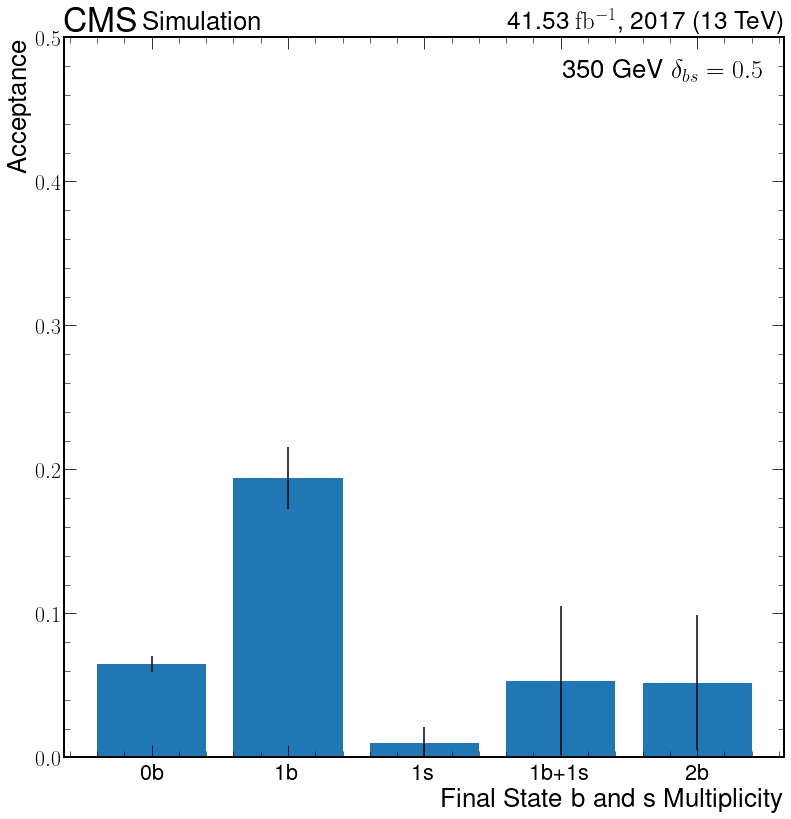

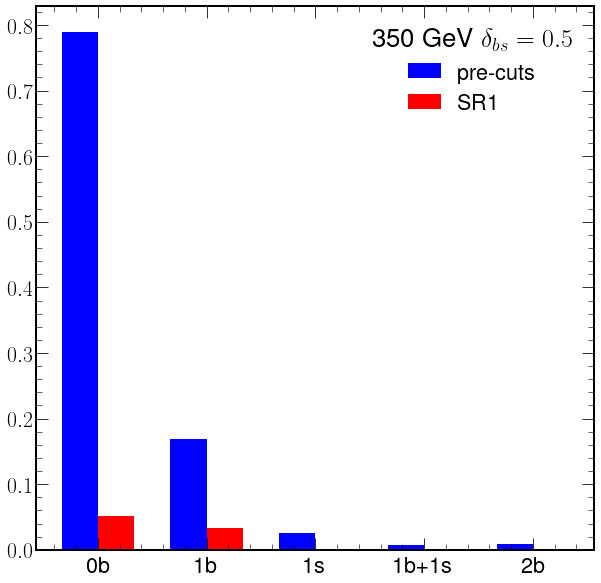

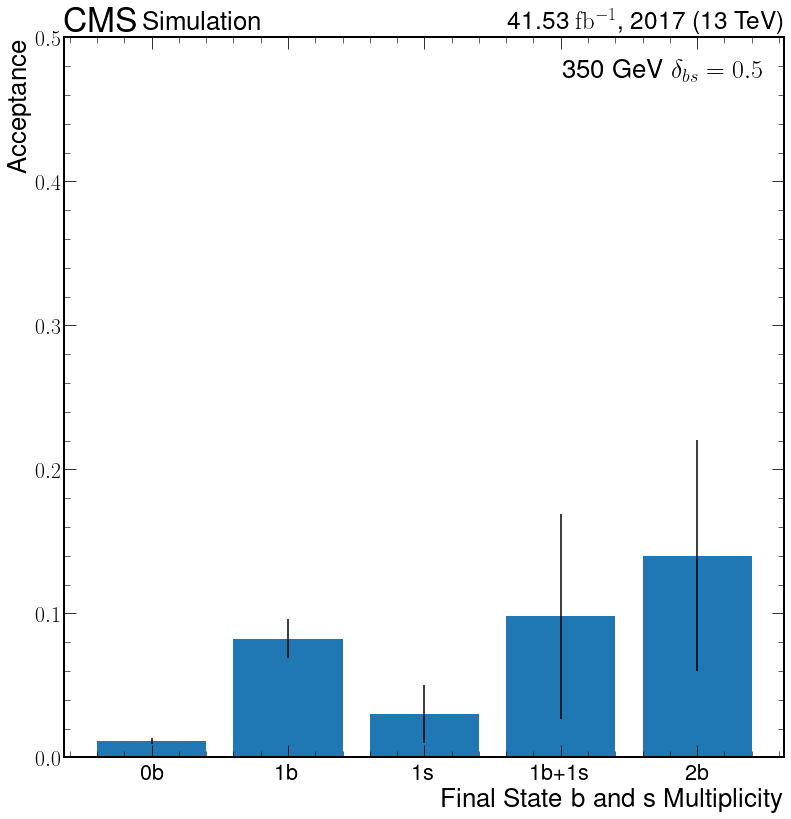

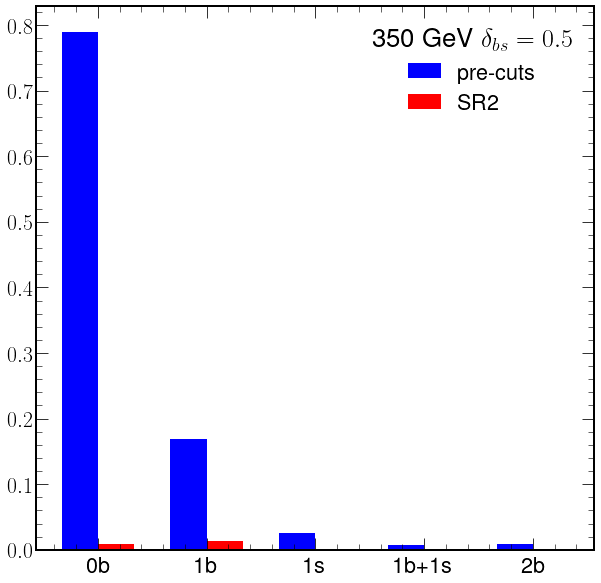

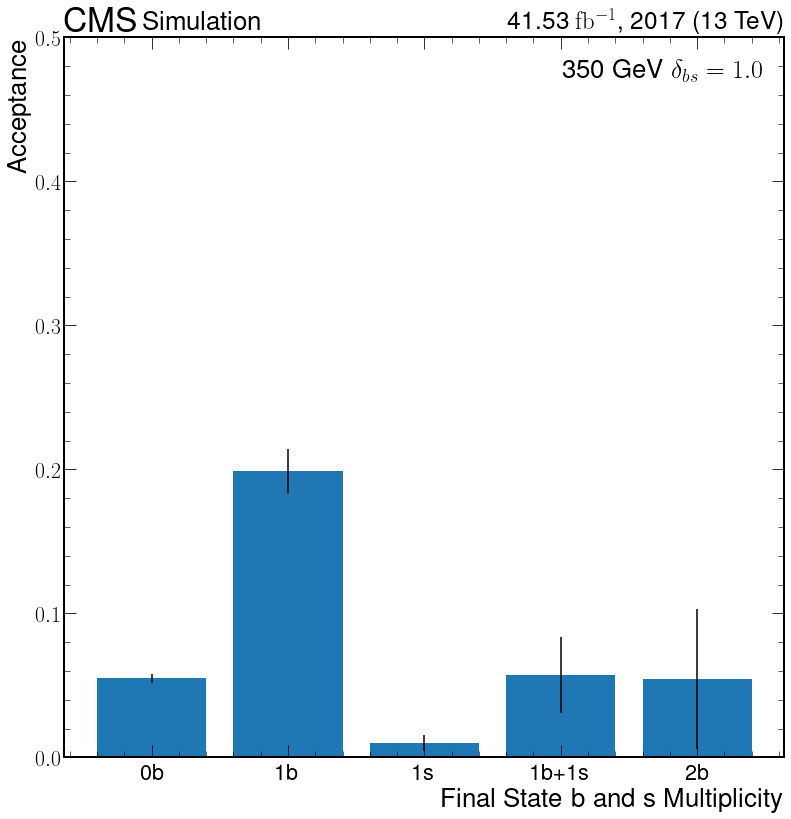

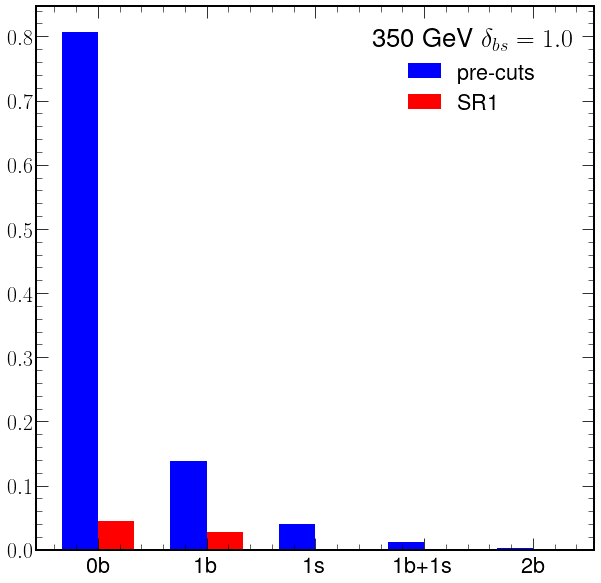

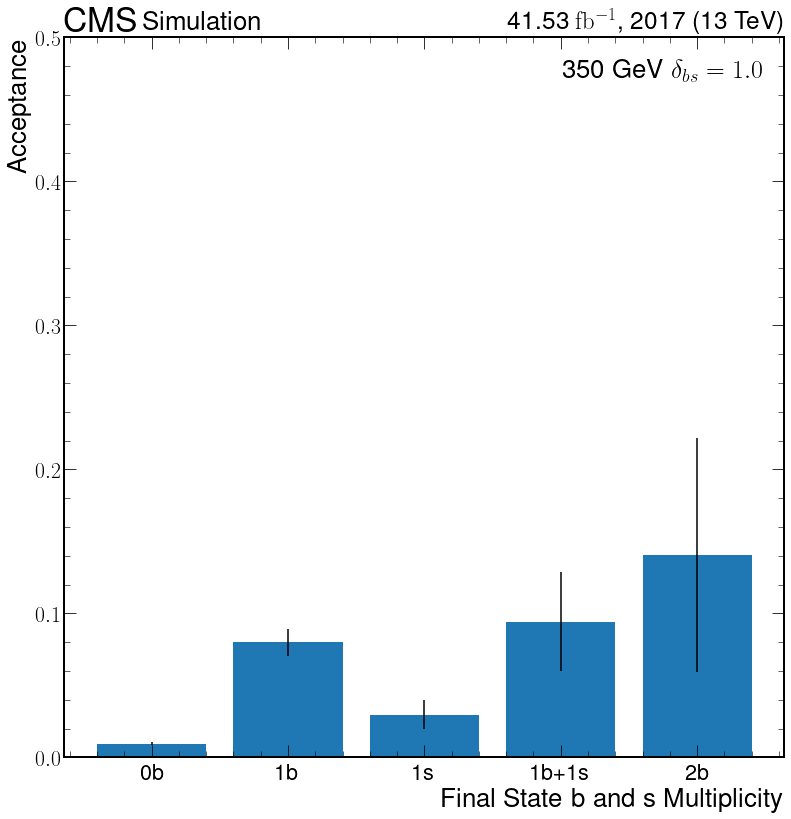

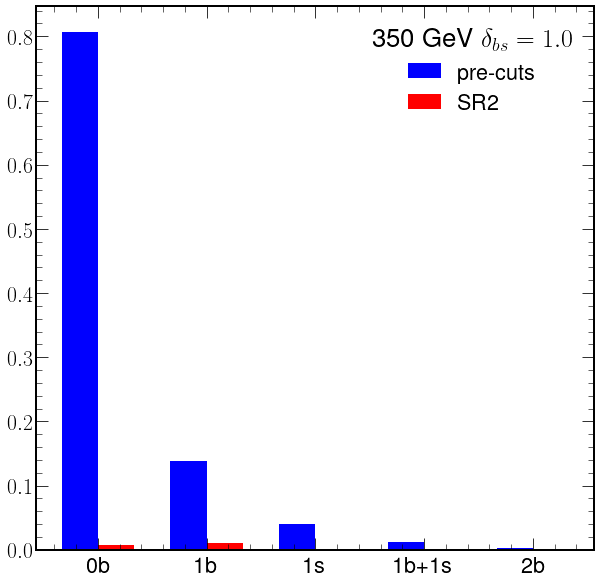

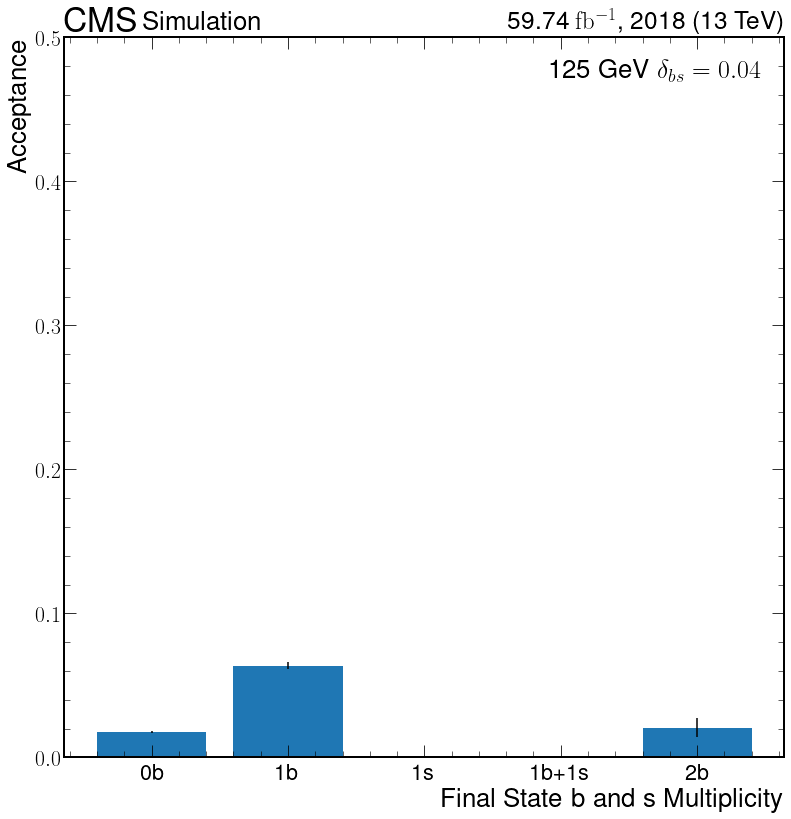

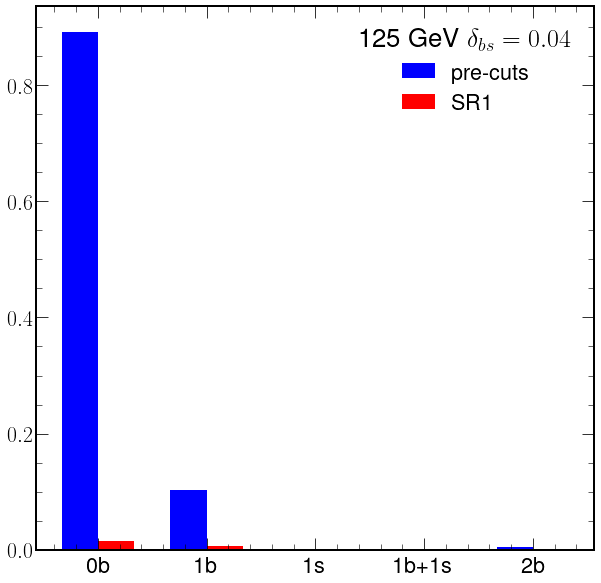

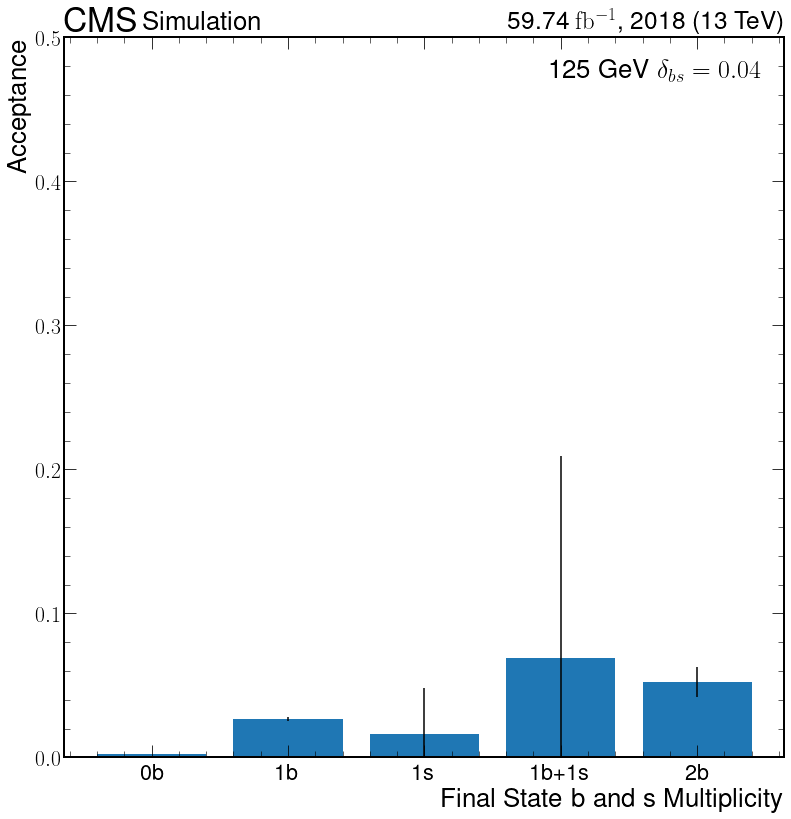

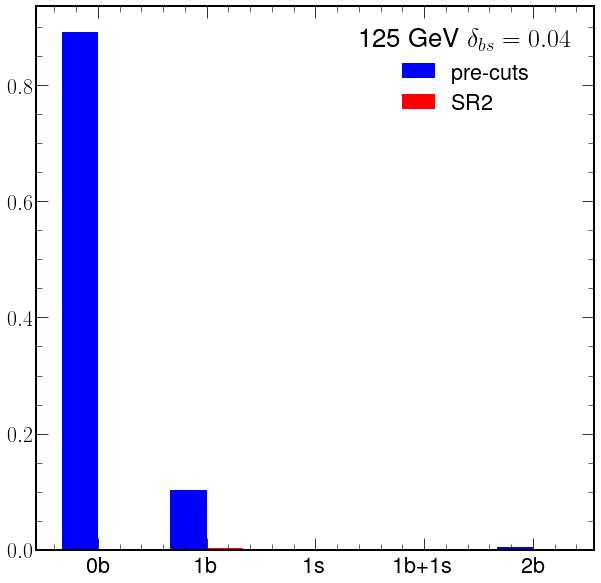

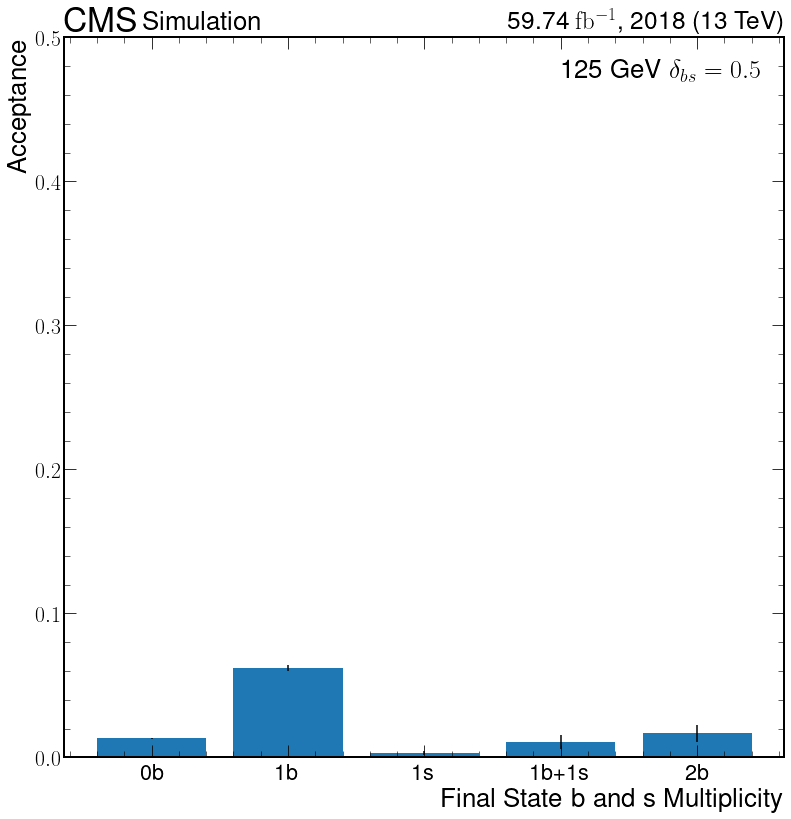

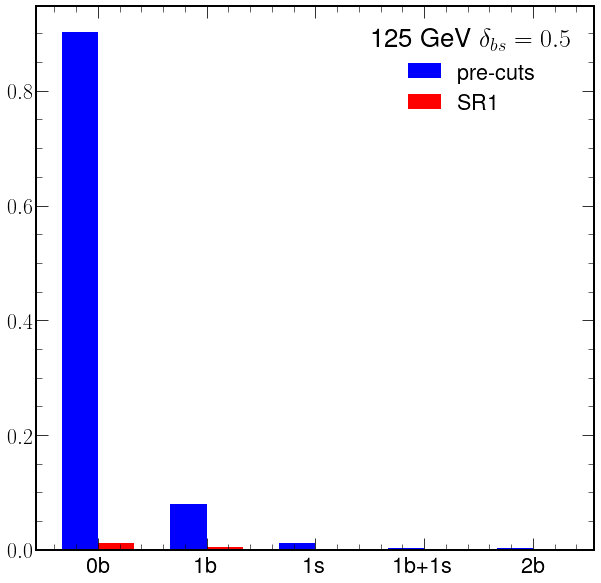

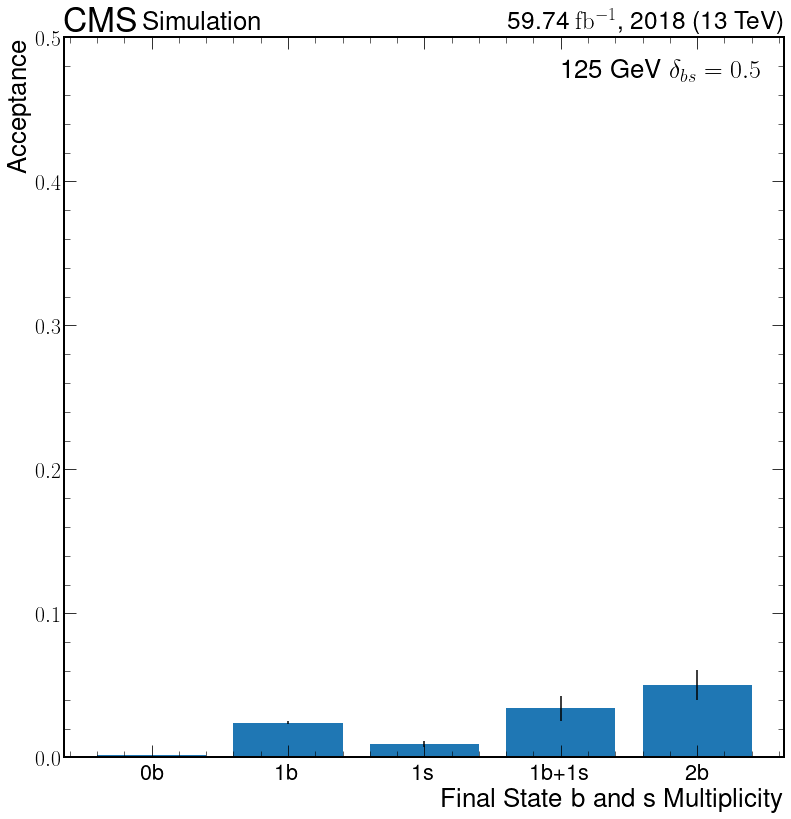

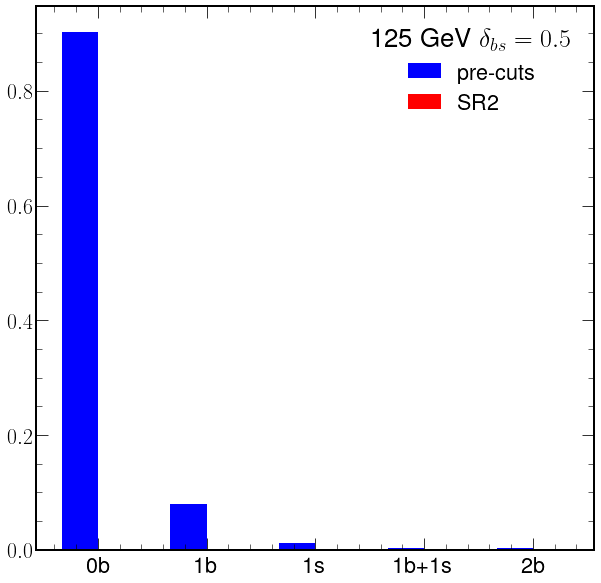

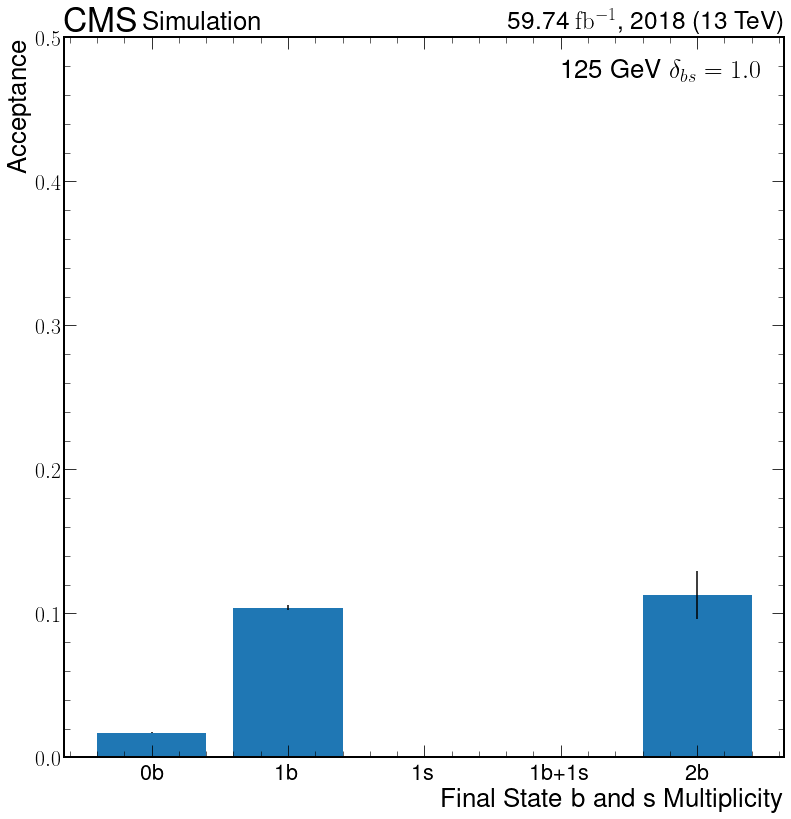

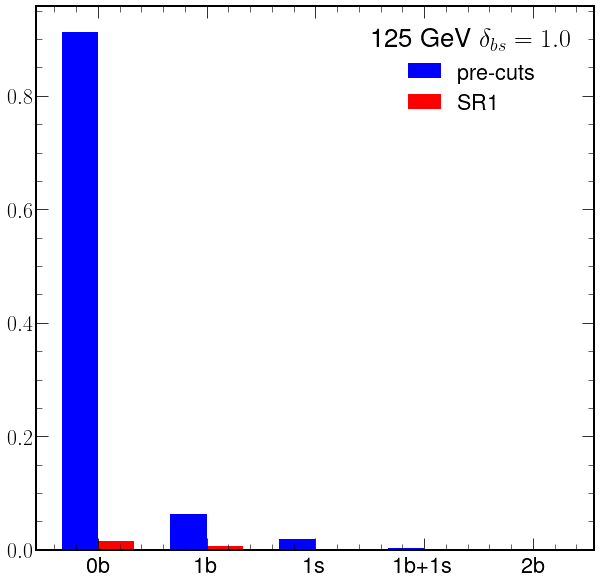

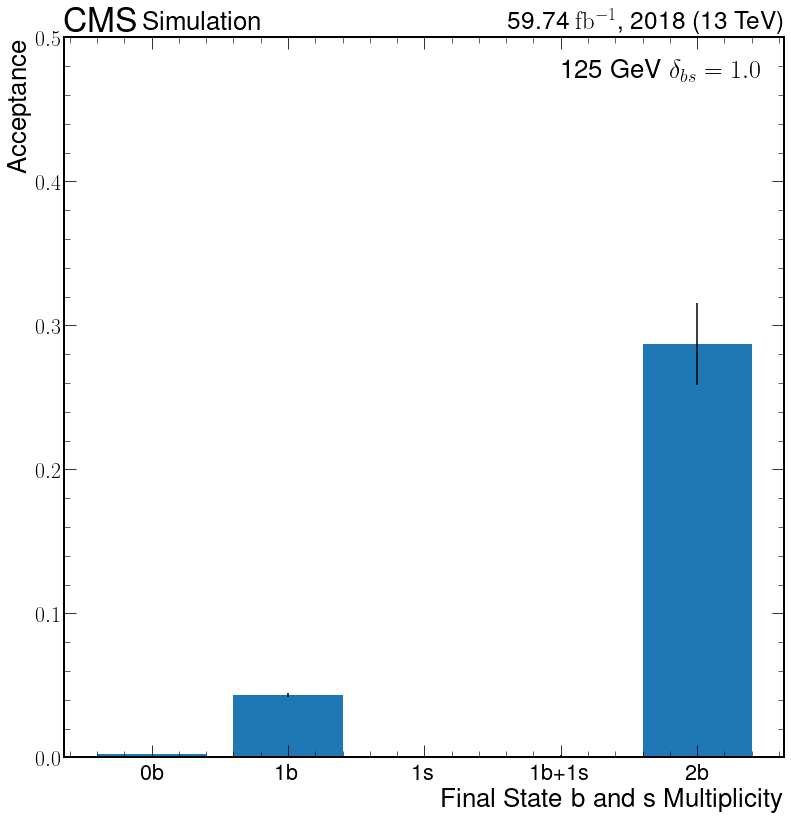

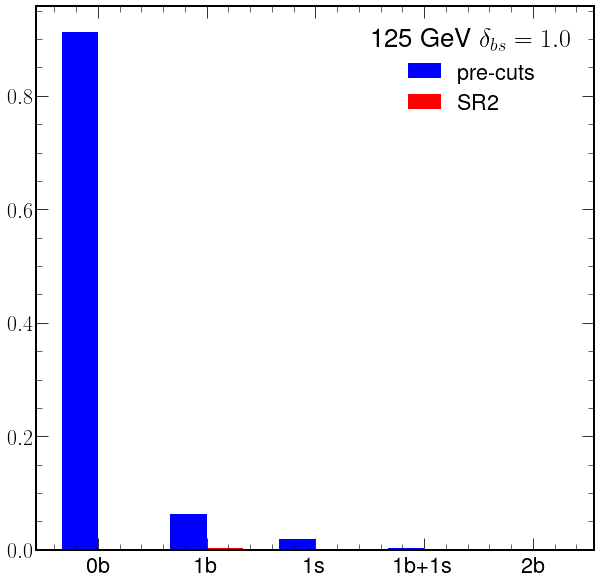

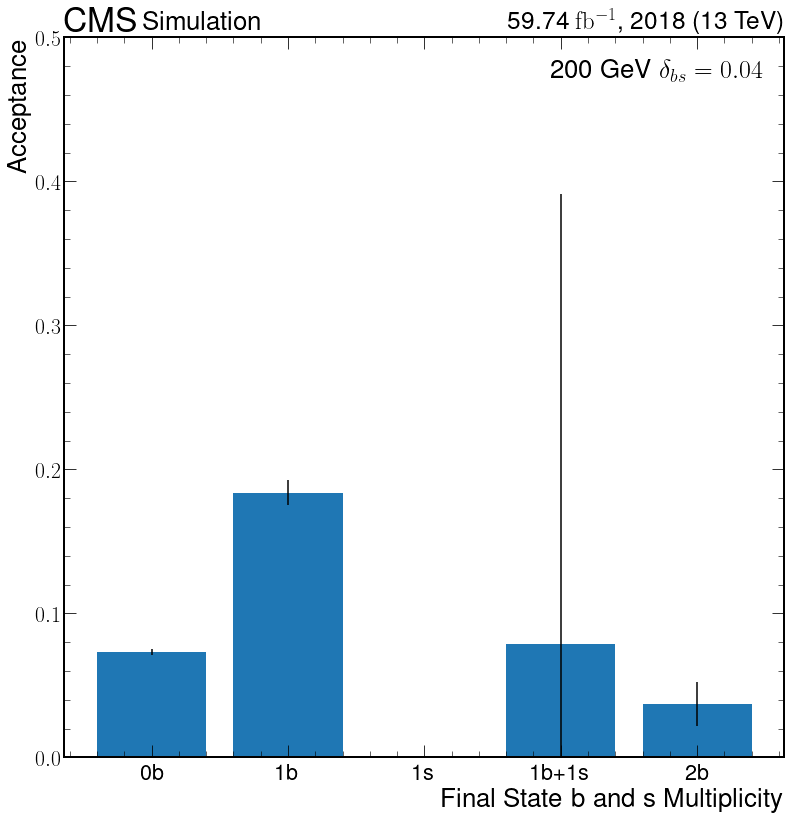

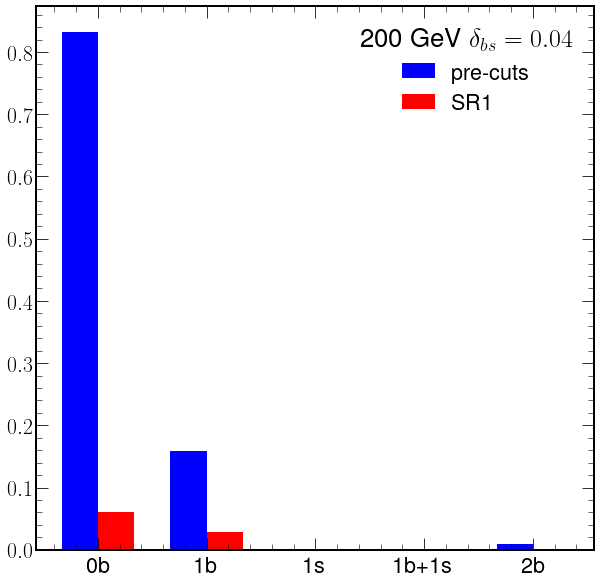

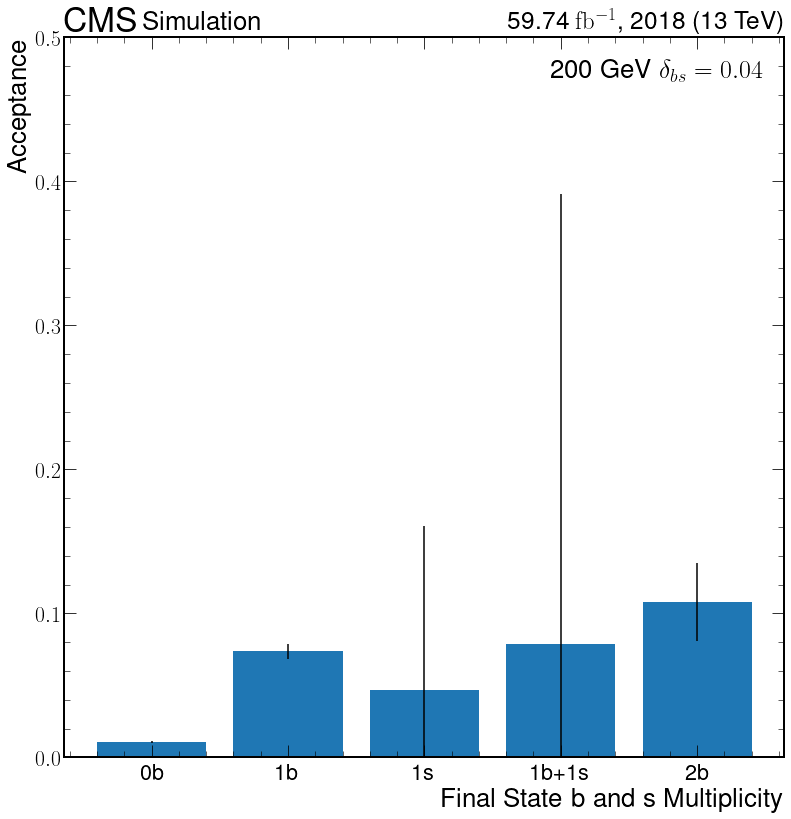

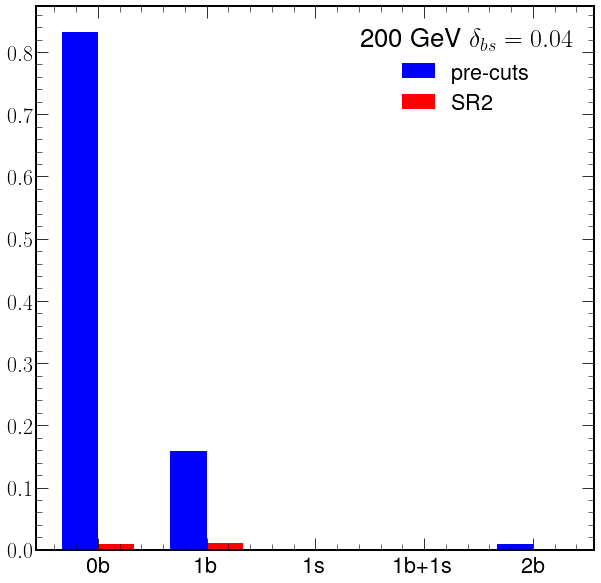

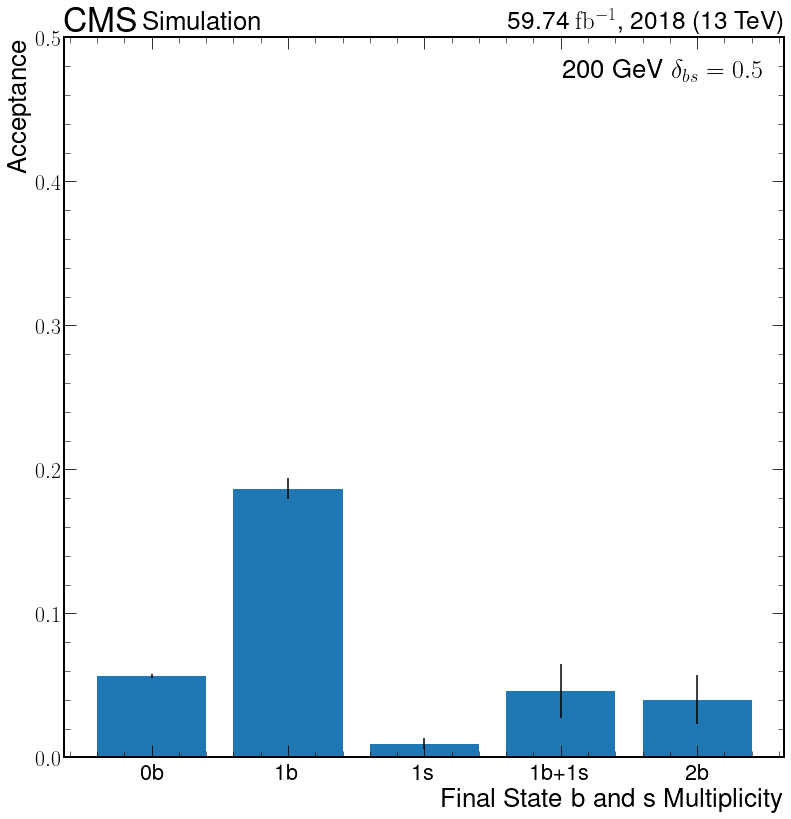

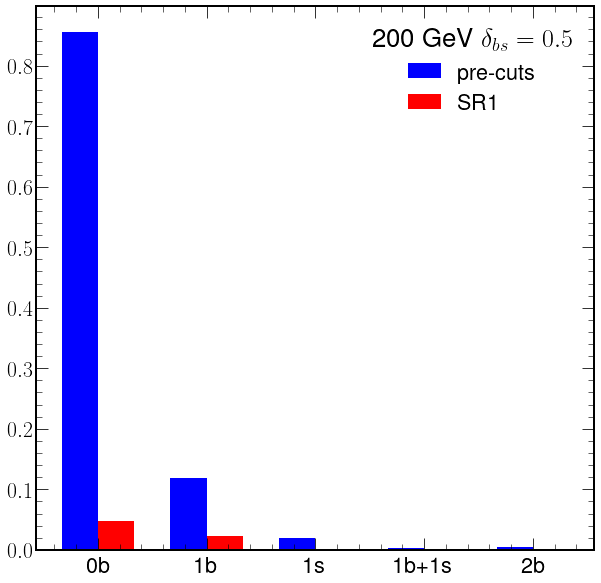

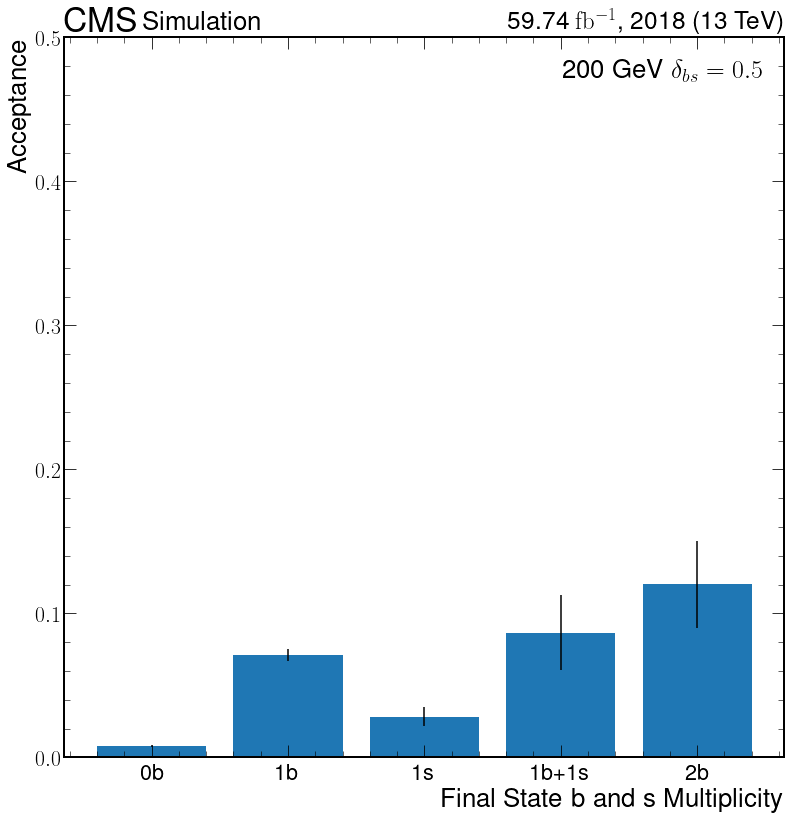

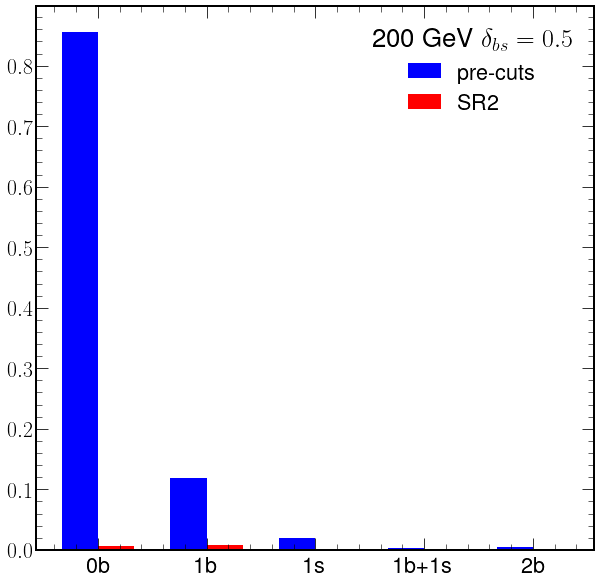

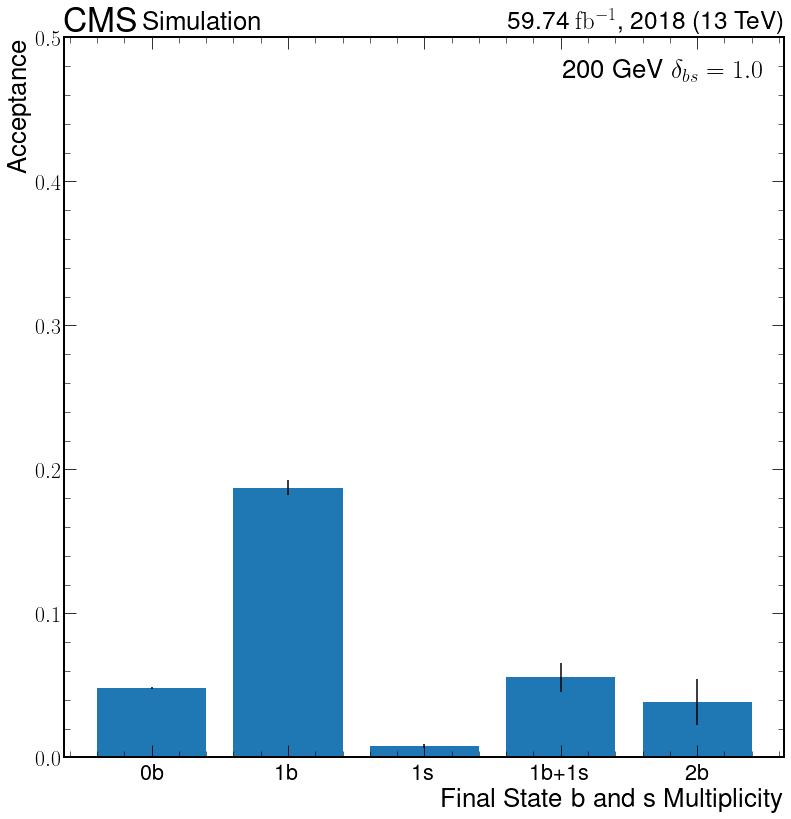

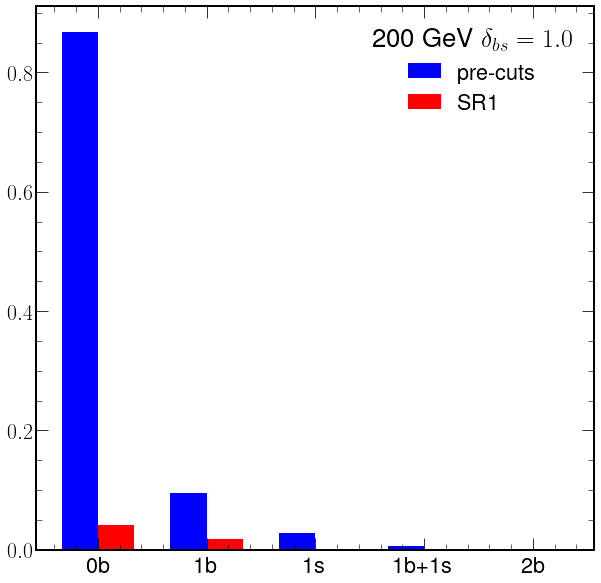

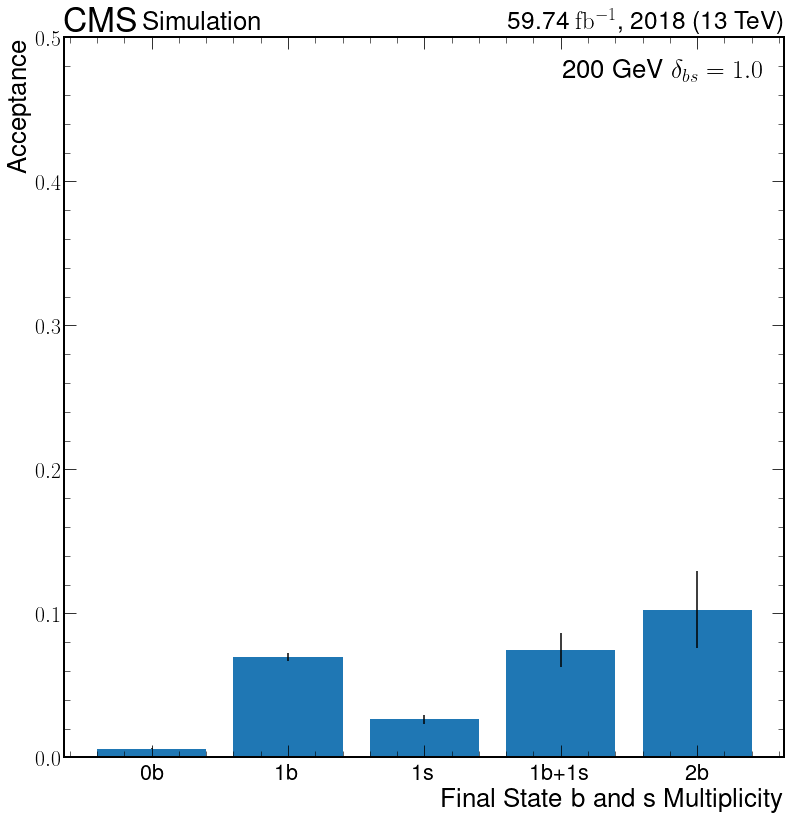

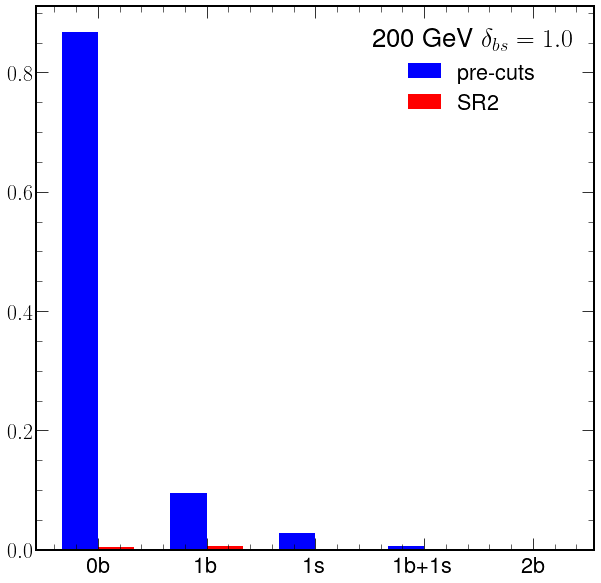

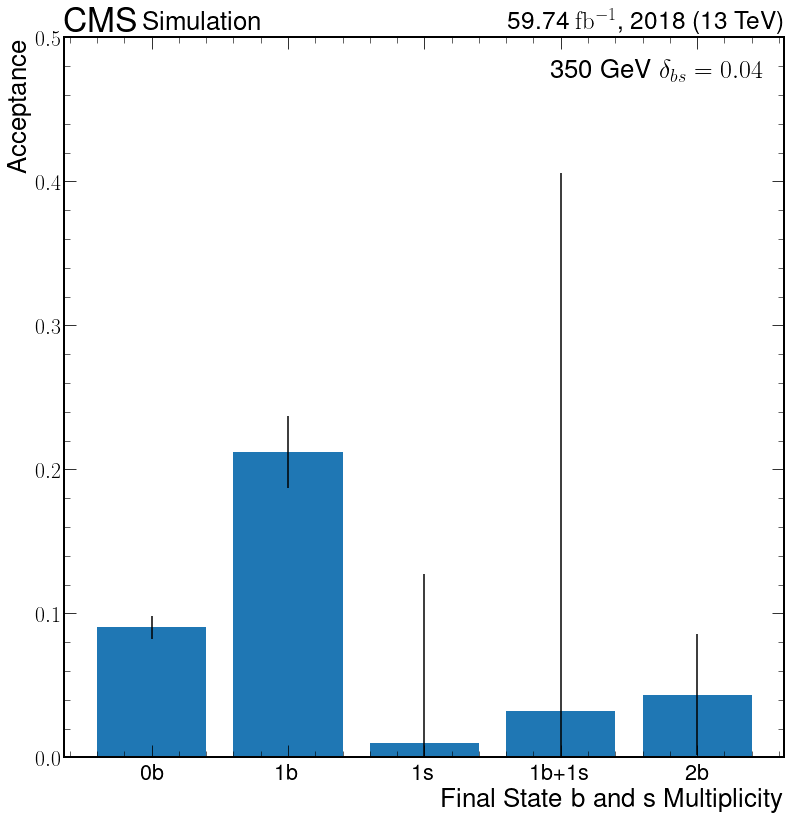

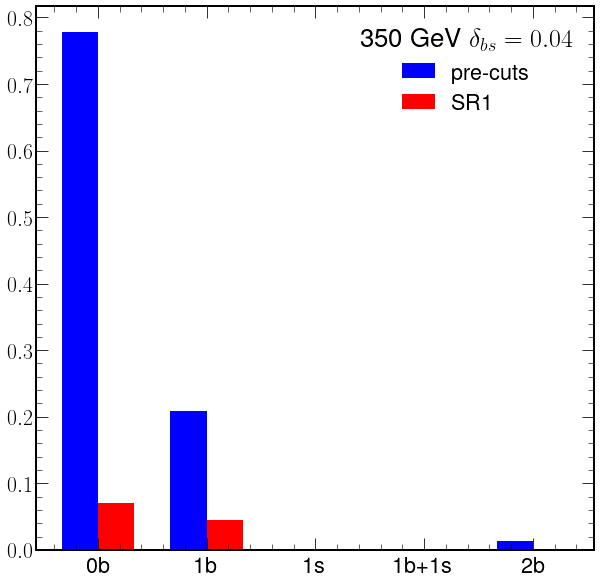

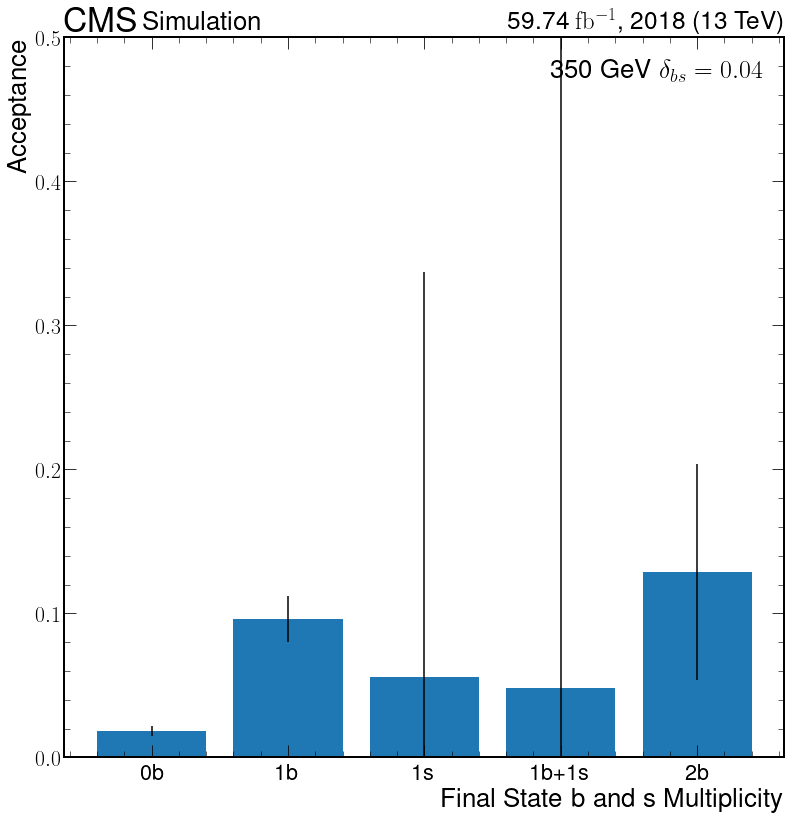

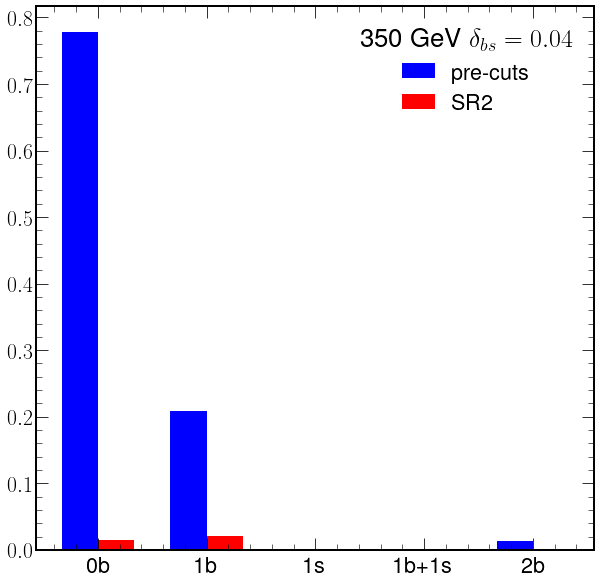

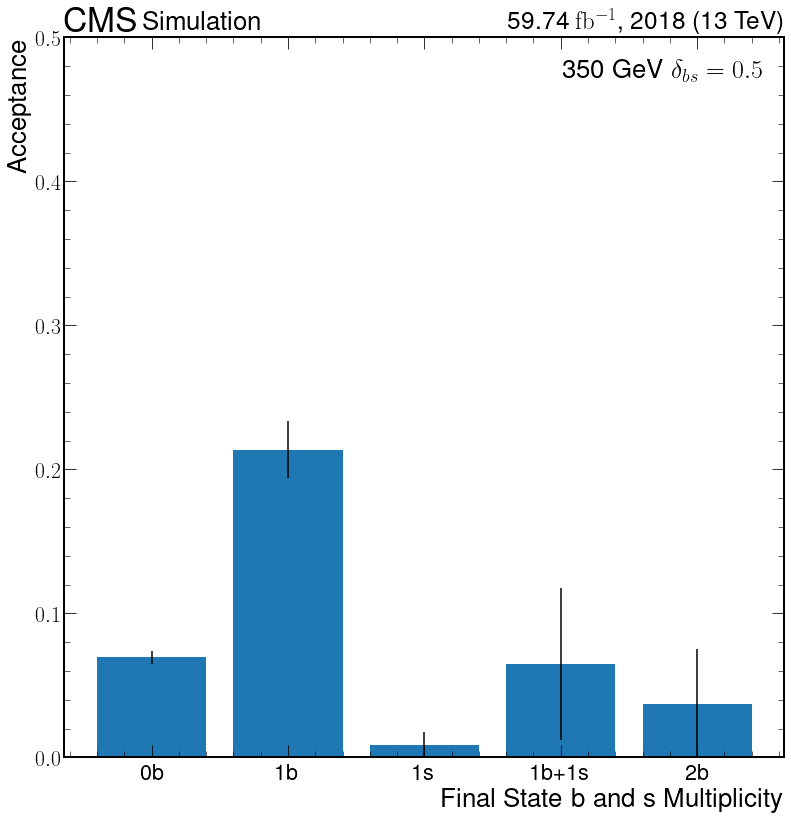

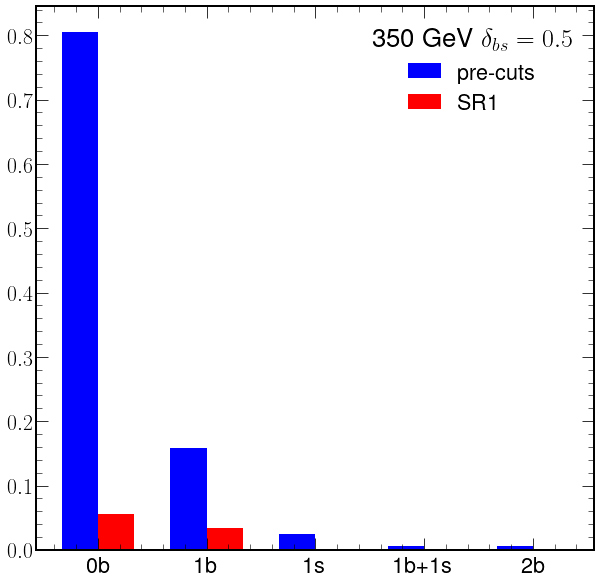

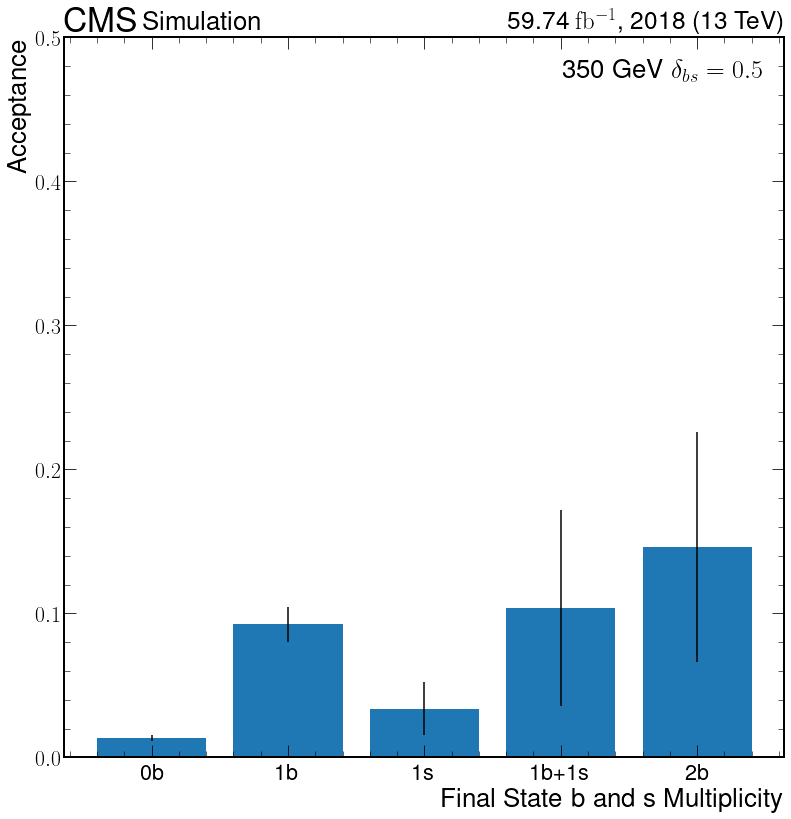

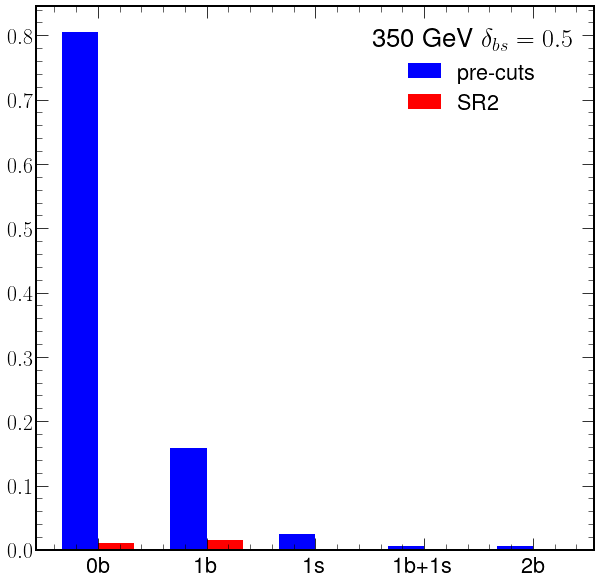

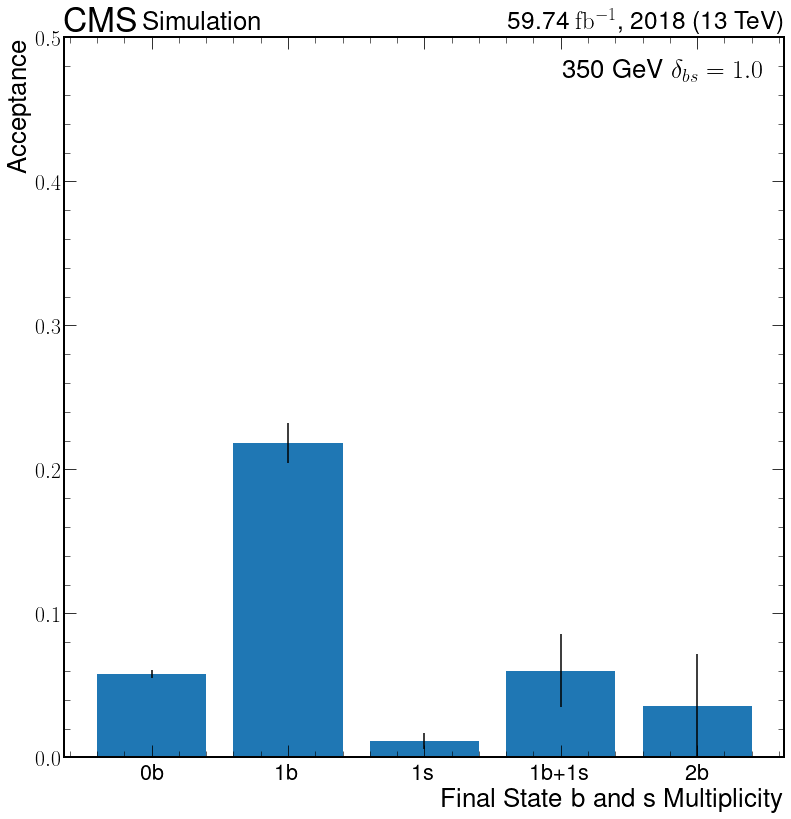

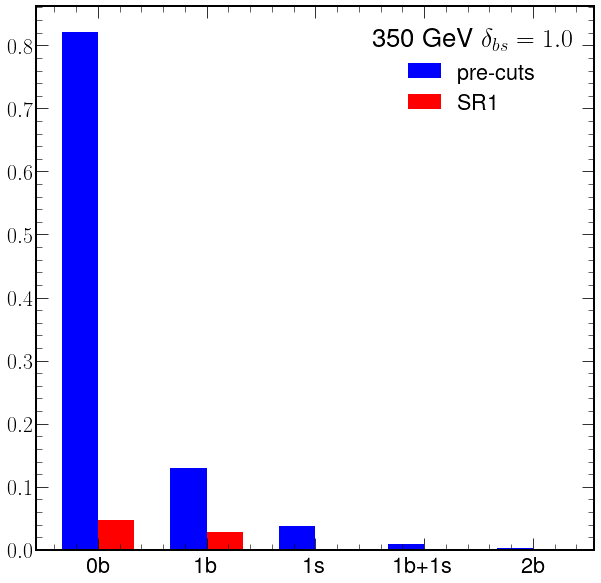

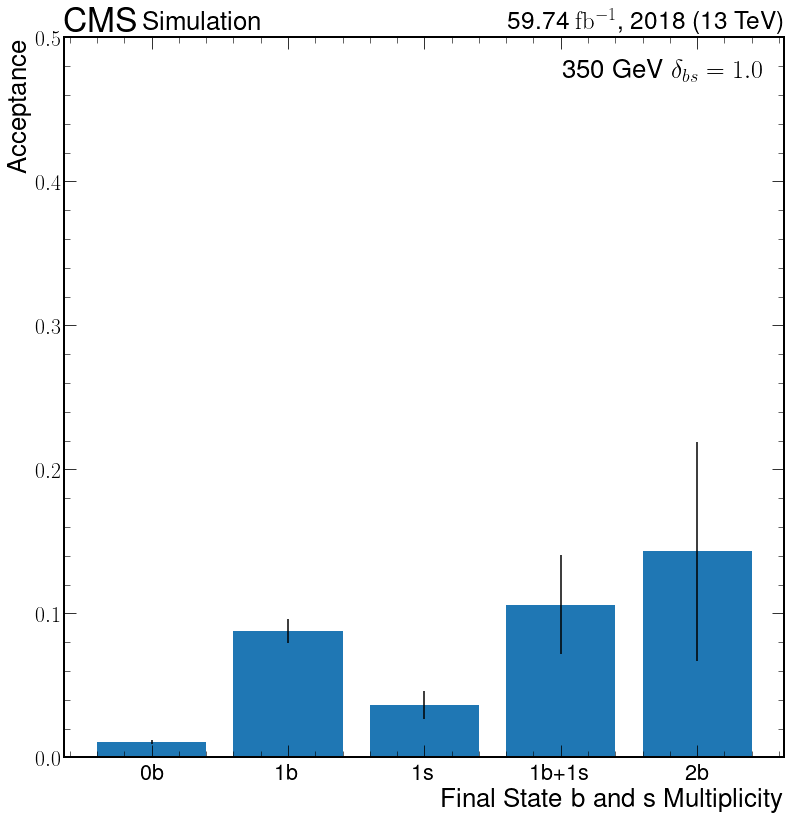

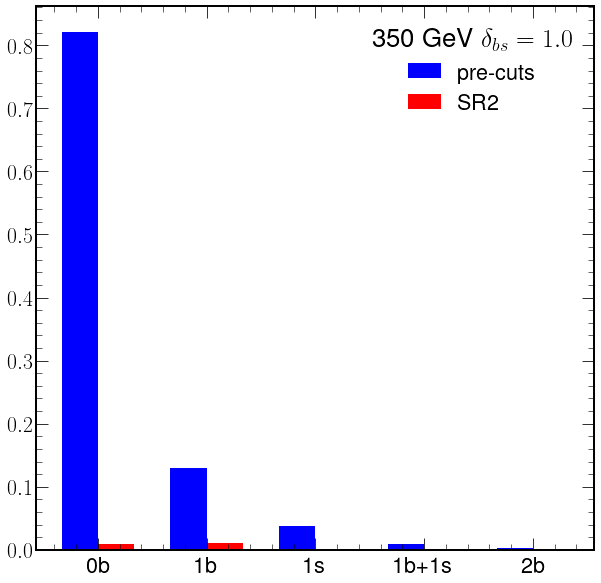

In [23]:
for row_dict in reg_hist:
    era = row_dict['era']
    
    nom = unumpy.uarray(row_dict['region_hist'], row_dict['region_hist']**.5)
    denom = unumpy.uarray(row_dict['uncut_hist'], row_dict['uncut_hist']**.5)
    ratio  = nom/denom
    nom, std = unumpy.nominal_values(ratio), unumpy.std_devs(ratio)
    fig, ax = draw_bar(nom, yerr=std)
    cms_format_fig(str(era), ax)
    ax.set_xlabel("Final State b and s Multiplicity")
    ax.set_ylabel("Acceptance")
    title='{mass} GeV $\delta_{{bs}}={dbs}$'.format(**row_dict)
    ax.legend(title=title)
    
    reg = 'SR1' if 'SR1' in row_dict['reg'] else 'SR2'
    fig, ax = comparison_bar(row_dict['uncut_hist'], row_dict['region_hist'], reg)
    
    ax.legend(title=title)
    
    propreg  = row_dict['region_hist']/np.sum(row_dict['uncut_hist'])
    propunc = row_dict['uncut_hist']/np.sum(row_dict['uncut_hist'])
    print("--------")
    print(title + " " + row_dict['reg'] + " " + str(era))
    for bin_name, reg, unc, rat, std in zip(['0b', '1b', '1s', '1b+1s', '2b'], propreg, propunc, nom, std):
    
        print("{} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(bin_name, reg*100, unc*100, rat*100, std*100))
        

,era,mass,dbs,reg,unlabled,0b,1b,1s,1b+1s,2b
0,2016,125,0.04,SR1,-0.0+/-0,0.0193+/-0.0016,0.060+/-0.008,0.0+/-0,0.1+/-0.5,0.014+/-0.018
1,2016,125,0.04,SR2,-0.0+/-0,0.0026+/-0.0006,0.028+/-0.005,0.02+/-0.10,0.1+/-0.5,0.06+/-0.04


In [60]:
df.keys()

Index(['era', 'mass', 'dbs', 'reg', 'uncut_hist', 'region_hist', 'weight',
       'nom', 'std', 'unlabled', '0b', '1b', '1s', '1b+1s', '2b'],
      dtype='object')